<a id='top'></a>

<a href='#import'>Import &amp; Inspect</a> | <a href='#user'>User Data</a> | <a href='#question'>Question Data</a>  | <a href='#group'>Group Name Data</a> | <a href='#act'>ACT Data</a> | <a href='#gmat'>GMAT Data</a> | <a href='#sat'>SAT Data</a> | <a href='#hypothesis'>Hypothesis Testing</a> | <a href='#summary'>Summary</a>
    
<br>

---

# Predicting Mastery in Academic Assessments - EDA
Students taking advantage of practice exercises through software applications seek an evaluation of their preparedness for formal academic assessments. The goal of this project is to help test developers understand user progress by predicting whether a student answers the next test question correctly.

---
# Data Wrangling
The [Initial Data Exploration](http://nbviewer.jupyter.org/github/humburgc/academic_mastery_study/blob/master/notebooks/initial_data_exploration.ipynb?flush_cache=true) notebook contains the following work: Import and inspect raw training data. Isolate relevant variables, fill or calculate new variables, and organize the dataframe. Resolve missing, invalid, corrupted or duplicate values.

From that notebook, the clean dataframe was saved in the file `clean_training.csv`, which is used for work in this notebook.

---
# Exploratory Data Analysis
Create data visualizations to explain variables. Detect and possibly remove or mark outliers. Explore variable dependence and correlations. Consider a hypothesis to explore. Leverage statistical inference to test the hypothesis. More generally, begin to develop a preliminary likeness of the solution

<a href='#top' id='import'>back to menu</a>

## Import & Inspect Clean Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'

pd.options.display.max_columns = 315

In [2]:
# Read and save CSV file as a dataframe:
df = pd.read_csv('../data/interim/clean_training.csv').drop('Unnamed: 0', axis='columns')

In [3]:
# Inspect the current state of the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846730 entries, 0 to 4846729
Data columns (total 22 columns):
user_id               int64
round_started_at      object
answered_at           object
deactivated_at        object
round_ended_at        object
correct               int64
question_id           int64
group_name            int64
track_name            int64
subtrack_name         int64
tag_string            object
question_type         int64
game_type             int64
num_players           int64
round_duration        object
fast                  int64
slow                  int64
num_questions         int64
few                   int64
many                  int64
prior_attempts        int64
excessive_attempts    int64
dtypes: int64(16), object(6)
memory usage: 813.5+ MB


Relevant variables need to be converted to datetime, timedelta and category types.

In [4]:
# Inspect 5 random observations:
df.sample(5)

user_id     round_started_at          answered_at  \
2519910    89821  2011-02-23 18:22:51  2011-02-23 18:23:08   
2808443    98223  2011-05-02 17:44:09  2011-05-02 17:44:59   
73688      45256  2009-12-28 14:28:52  2009-12-28 14:30:10   
1799810   144275  2011-06-09 07:40:11  2011-06-09 07:40:26   
3905829    12829  2010-03-11 14:49:29                  NaN   

              deactivated_at       round_ended_at  correct  question_id  \
2519910  2011-02-23 18:23:54  2011-02-23 18:23:08        0         5660   
2808443  2011-05-02 17:45:20  2011-05-02 17:44:59        1         5298   
73688    2009-12-28 14:31:01  2009-12-28 14:30:10        1           49   
1799810  2011-06-09 07:40:52  2011-06-09 07:40:26        0         5274   
3905829  2010-03-11 14:49:33  2010-03-11 14:49:33        0          290   

         group_name  track_name  subtrack_name          tag_string  \
2519910           0           1              6       46 82 125 167   
2808443           1           5             14     220 222 228 246   
73688             0           1              6  82 125 169 204 214   
1799810           1           5             11     183 193 194 207   
3905829           2           6              7         131 137 170   

         question_type  game_type  num_players             round_duration  \
2519910              0          7            3  0 days 00:00:17.000000000   
2808443              0          4            3  0 days 00:00:50.000000000   
73688                0          7            3  0 days 00:01:18.000000000   
1799810              0          7            2  0 days 00:00:15.000000000   
3905829              0          7            2  0 days 00:00:04.000000000   

         fast  slow  num_questions  few  many  prior_attempts  \
2519910     0     0            260    0     0               0   
2808443     0     0           1086    0     0               2   
73688       0     0             95    0     0               0   
1799810     0     0             70    0     0               0   
3905829     1     0             65    0     0               0   

         excessive_attempts  
2519910                   0  
2808443                   0  
73688                     0  
1799810                   0  
3905829                   0

## Spruce the Clean Dataframe

In [5]:
# Create and save list of columns to convert to datetime:
time_columns = ['round_started_at', 'answered_at', 'deactivated_at', 'round_ended_at']

# Loop through the time_columns list:
for column in time_columns:
    # Convert date columns to datetime objects; 
    # need to ‘coerce’ errors, since there are known NULL values:
    df[column] = pd.to_datetime(df[column], errors='coerce')

In [6]:
# Convert round_duration to timedelta:
df['round_duration'] = pd.to_timedelta(df.round_duration, unit='s')

In [7]:
# Define a generic replace function -

def code_values(column, code_dictionary):
    """Return a column of codes defined in a dictionary."""
    
    # Initialize the replacement column:
    coded_column = pd.Series(column, copy=True)
    
    # Loop throught the provided dictionary:
    for key, value in code_dictionary.items():
        
        # Replace key with the value within the original column:
        coded_column.replace(key, value, inplace=True)
        
    return coded_column

In [8]:
# Replace group codes with semantic values -

# Save dictionary with codes and semantic values:
groups = {0:'ACT', 1:'GMAT', 2:'SAT'}

# Convert and save:
df.group_name = code_values(df.group_name, groups)

In [9]:
# Add a more semantic column related to the 'correct' column for plot simplicity-

# Save dictionary with codes and semantic values:
outcome = {0: 'Incorrect', 1: 'Correct'}

# Copy the 'correct' column and save, then convert:
df['outcome'] = df.correct
df.outcome = code_values(df.outcome, outcome)

In [10]:
# Re-inspect the state and structure of the dataframe:
df.head()

user_id    round_started_at         answered_at      deactivated_at  \
0    85818 2010-08-18 20:17:13 2010-08-18 20:18:18 2010-08-18 20:18:18   
1    85818 2010-08-18 20:19:12 2010-08-18 20:20:34 2010-08-18 20:20:34   
2    85818 2010-08-18 20:20:42 2010-08-18 20:21:56 2010-08-18 20:21:56   
3    85818 2010-08-18 20:22:03 2010-08-18 20:23:05 2010-08-18 20:23:05   
4    85818 2010-08-18 20:23:11 2010-08-18 20:26:08 2010-08-18 20:26:08   

       round_ended_at  correct  question_id group_name  track_name  \
0 2010-08-18 20:18:18        0         5560       GMAT           5   
1 2010-08-18 20:20:34        1         4681       GMAT           5   
2 2010-08-18 20:21:56        1         1529       GMAT           5   
3 2010-08-18 20:23:05        1         2908       GMAT           5   
4 2010-08-18 20:26:08        1         1773       GMAT           5   

   subtrack_name       tag_string  question_type  game_type  num_players  \
0             14  222 233 240 246              0          7            1   
1              0            24 49              0          7            1   
2              0            31 49              0          7            1   
3              0            31 49              0          7            1   
4             11      183 194 207              0          7            1   

  round_duration  fast  slow  num_questions  few  many  prior_attempts  \
0       00:01:05     0     0            315    0     0               0   
1       00:01:22     0     0            315    0     0               0   
2       00:01:14     0     0            315    0     0               0   
3       00:01:02     0     0            315    0     0               0   
4       00:02:57     0     0            315    0     0               0   

   excessive_attempts    outcome  
0                   0  Incorrect  
1                   0    Correct  
2                   0    Correct  
3                   0    Correct  
4                   0    Correct

## Dataset Statistics

In [11]:
# Display statistics for numerical variables:
df.describe()

user_id       correct   question_id    track_name  subtrack_name  \
count  4.846730e+06  4.846730e+06  4.846730e+06  4.846730e+06   4.846730e+06   
mean   8.976983e+04  5.478667e-01  3.015737e+03  4.857874e+00   7.416266e+00   
std    5.154042e+04  4.977036e-01  1.721481e+03  2.136384e+00   4.719136e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    4.486000e+04  0.000000e+00  1.529000e+03  4.000000e+00   3.000000e+00   
50%    9.061300e+04  1.000000e+00  2.988000e+03  5.000000e+00   7.000000e+00   
75%    1.334800e+05  1.000000e+00  4.480000e+03  6.000000e+00   1.100000e+01   
max    1.791050e+05  1.000000e+00  6.045000e+03  8.000000e+00   1.500000e+01   

       question_type     game_type   num_players          round_duration  \
count   4.846730e+06  4.846730e+06  4.846730e+06                 4846730   
mean    3.812797e-02  6.325401e+00  1.709761e+00  0 days 00:01:07.679064   
std     1.915052e-01  1.879320e+00  1.304478e+00  0 days 00:19:49.418308   
min     0.000000e+00  0.000000e+00  1.000000e+00         0 days 00:00:01   
25%     0.000000e+00  5.000000e+00  1.000000e+00         0 days 00:00:26   
50%     0.000000e+00  7.000000e+00  1.000000e+00         0 days 00:00:51   
75%     0.000000e+00  7.000000e+00  2.000000e+00         0 days 00:01:31   
max     1.000000e+00  1.100000e+01  7.800000e+01        28 days 03:21:38   

               fast          slow  num_questions           few          many  \
count  4.846730e+06  4.846730e+06   4.846730e+06  4.846730e+06  4.846730e+06   
mean   3.366868e-02  9.039084e-04   8.150180e+02  4.577189e-02  3.634554e-02   
std    1.803749e-01  3.005148e-02   1.300247e+03  2.089900e-01  1.871485e-01   
min    0.000000e+00  0.000000e+00   1.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00   3.800000e+01  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00   2.710000e+02  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00   1.017000e+03  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00   1.002600e+04  1.000000e+00  1.000000e+00   

       prior_attempts  excessive_attempts  
count    4.846730e+06        4.846730e+06  
mean     5.538753e-01        5.929771e-04  
std      1.175980e+01        2.434390e-02  
min      0.000000e+00        0.000000e+00  
25%      0.000000e+00        0.000000e+00  
50%      0.000000e+00        0.000000e+00  
75%      0.000000e+00        0.000000e+00  
max      1.205000e+03        1.000000e+00

For all records in the clean dataset the mean percentage of correct answers is 54.8% and the mean round duration is 1 minute, 8 seconds.

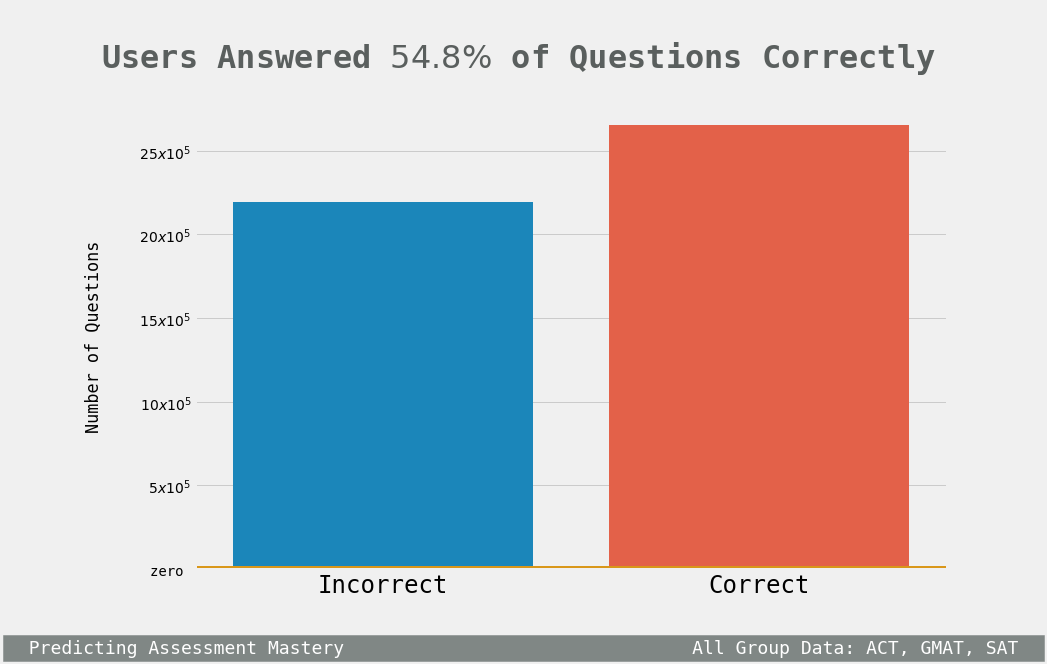

In [12]:
# Create bar plot for outcome distribution:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 8))
outcome_grph = sns.countplot(data=df, x='outcome')
outcome_grph.tick_params(axis='x', which='major', labelsize=24)
outcome_grph.set_yticklabels(labels=['zero ', '    $5x10^5$', '   $10x10^5$', '    $15x10^5$', '    $20x10^5$', '  $25x10^5$'])
outcome_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
outcome_grph.xaxis.label.set_visible(False)
outcome_grph.text(x=-1, y=-500000, 
                  s='  Predicting Assessment Mastery                                All Group Data: ACT, GMAT, SAT  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.ylabel('Number of Questions')

# Add a title bar with some space at the top:
outcome_grph.text(x=0, y=3250000, s=' ', fontsize=24)
outcome_grph.text(x=-0.75, y=3000000, s='Users Answered $54.8\%$ of Questions Correctly', fontsize=32, weight='bold', color='#5A5F5E')

# Save and display the plot:
plt.savefig('../reports/figures/outcome_distribution.png', bbox_inches='tight');

<a href='#top' id='user'>back to menu</a>

---
### USER DATA

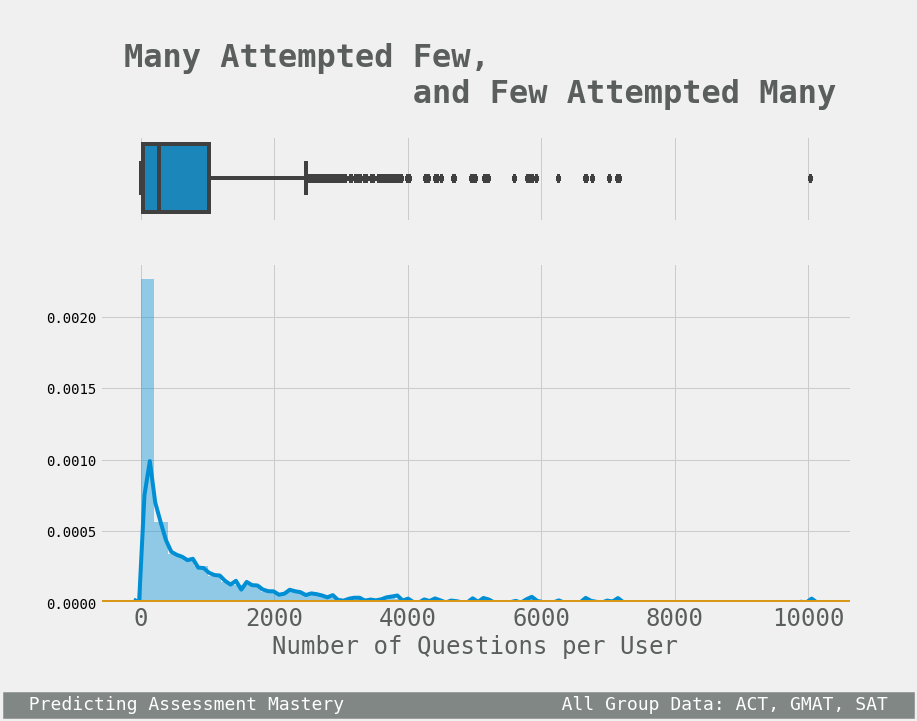

In [13]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=(12, 8))
 
# Add boxplot for correct_ratio:
user_participation_grph = sns.boxplot(df.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
user_participation_grph = sns.distplot(df.num_questions, ax=histogram)

user_participation_grph.tick_params(axis='x', which='major', labelsize=24, colors='#5A5F5E')
user_participation_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
user_participation_grph.text(x=-2000, y=-0.00075, 
                  s='  Predicting Assessment Mastery                    All Group Data: ACT, GMAT, SAT  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.xlabel('Number of Questions per User', fontsize=24, color='#5A5F5E')

user_participation_grph.text(x=-250, y=0.0035, s='\nMany Attempted Few,\n               and Few Attempted Many', fontsize=32, weight='bold', color='#5A5F5E')


# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Save and display the plot:
plt.savefig('../reports/figures/user_participation_distribution.png', bbox_inches='tight');

It looks like a small percent of users attempted a large number of questions and a large percent attempted a small number of questions. Users attempting more than 4000 questions are scarce, but at least one attempted at least 10,000 questions.

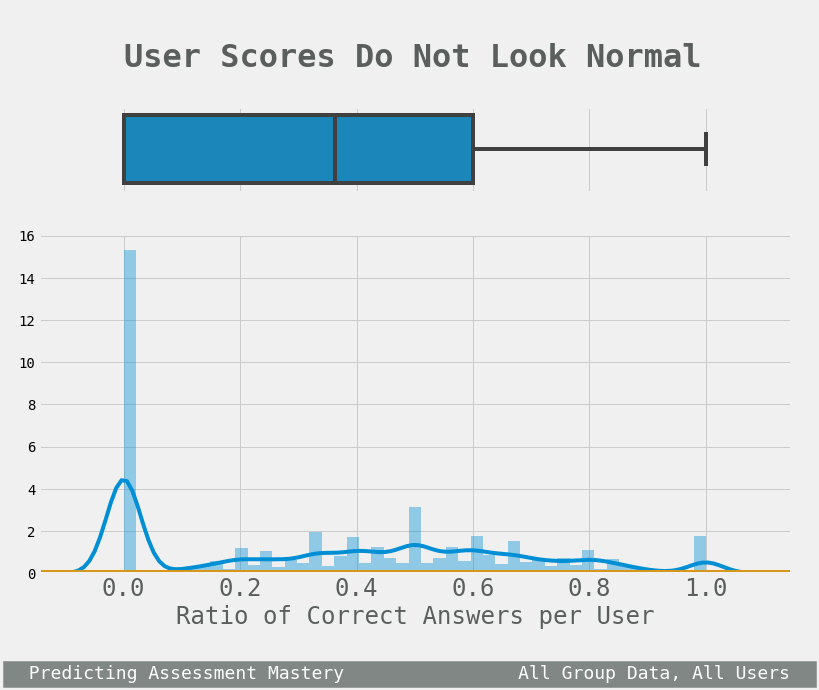

In [14]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=(12, 8))
 
# Add boxplot for correct_ratio:
user_scores_grph = sns.boxplot(df.groupby('user_id').correct.mean(), ax=boxplot)

# Add histogram for correct_ratio:
user_scores_grph = sns.distplot(df.groupby('user_id').correct.mean(), ax=histogram)

user_scores_grph.tick_params(axis='x', which='major', labelsize=24, colors='#5A5F5E')
user_scores_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
user_scores_grph.text(x=-0.2, y=-5, 
                  s='  Predicting Assessment Mastery                All Group Data, All Users  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.xlabel('Ratio of Correct Answers per User', fontsize=24, color='#5A5F5E')

user_scores_grph.text(x=0, y=24, s='\nUser Scores Do Not Look Normal', fontsize=32, weight='bold', color='#5A5F5E')


# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Save and display the plot:
plt.savefig('../reports/figures/user_scores.png', bbox_inches='tight');

In [15]:
atleast_30 = df.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
len(atleast_30)

3783408

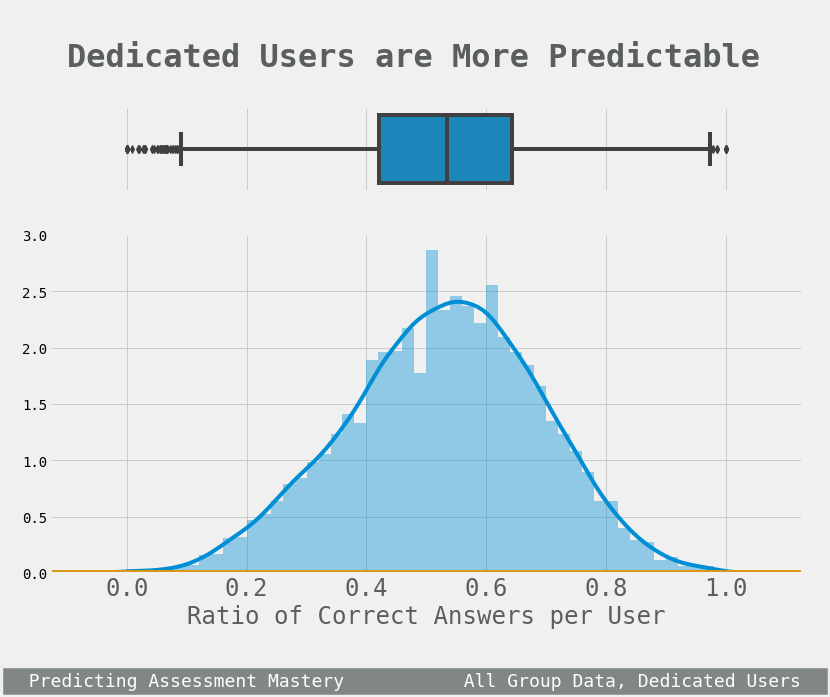

In [16]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=(12, 8))
 
# Add boxplot for correct_ratio:
user_scores30_grph = sns.boxplot(atleast_30.groupby('user_id').correct.mean(), ax=boxplot)

# Add histogram for correct_ratio:
user_scores30_grph = sns.distplot(atleast_30.groupby('user_id').correct.mean(), ax=histogram)

user_scores30_grph.tick_params(axis='x', which='major', labelsize=24, colors='#5A5F5E')
user_scores30_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
user_scores30_grph.text(x=-0.2, y=-1, 
                  s='  Predicting Assessment Mastery           All Group Data, Dedicated Users  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.xlabel('Ratio of Correct Answers per User', fontsize=24, color='#5A5F5E')

user_scores30_grph.text(x=-0.1, y=4.5, s='\nDedicated Users are More Predictable', fontsize=32, weight='bold', color='#5A5F5E')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Save and display the plot:
plt.savefig('../reports/figures/user_scores_30.png', bbox_inches='tight');

<a href='#top' id='question'>back to menu</a>

---
### QUESTION DATA

In [17]:
# Print the number of unique question_id values:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [18]:
# Count and save the number of questions per user:
observations_per_questionid = df.question_id.value_counts()

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
observations_per_question = observations_per_questionid.to_frame('question_count').reset_index().drop('index', axis='columns')

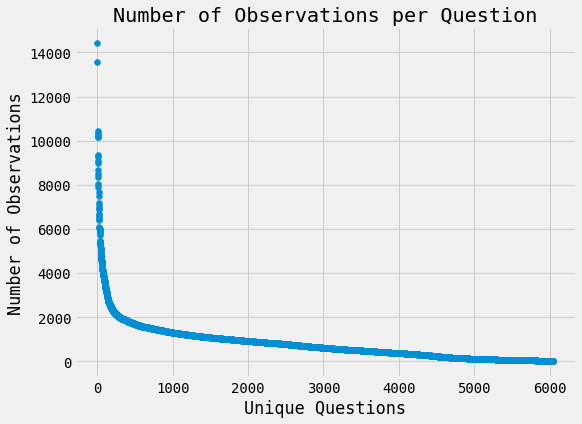

In [19]:
# Create questions_per_user scatter plot:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(observations_per_question.index, observations_per_question.question_count)

# Create the labels and title of the plot:
plt.xlabel('Unique Questions')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Question');

There are a large number of questions underrepresented in the dataset. Perhaps the question groups explain this. First, a look at prior attempts to answer a unique question.

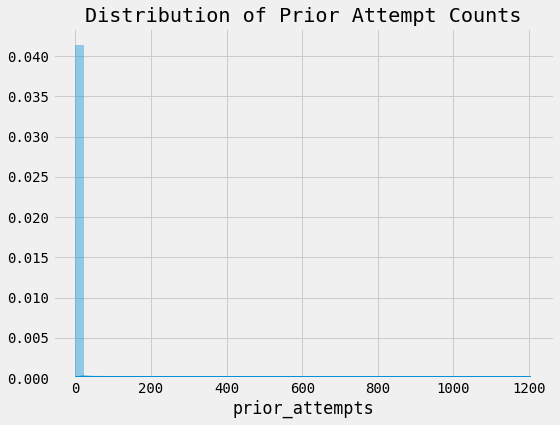

In [20]:
# Create a figure with two plots:
fig, ax = plt.subplots(figsize=(8, 6))
 
# Add histogram for correct_ratio:
sns.distplot(df.prior_attempts)

# Label axes and add title:
plt.title('Distribution of Prior Attempt Counts');

In [21]:
df[df.excessive_attempts == True].user_id.value_counts()

62044     1268
129150     274
3478       260
97572      212
27429      178
51964      170
134049     140
28257      132
114834      90
152666      64
26406       39
102545      32
95483       15
Name: user_id, dtype: int64

Some users had a ridiculous number of prior attempts. Surely only a bot would try to answer a question 1200+ times!?

In [22]:
df[df.user_id == 62044]

user_id    round_started_at         answered_at      deactivated_at  \
2945555    62044 2009-12-01 02:11:22 2009-12-01 02:13:16 2009-12-01 02:13:16   
2945556    62044 2009-12-01 02:13:34 2009-12-01 02:15:13 2009-12-01 02:15:13   
2945557    62044 2009-12-01 02:15:47 2009-12-01 02:18:27 2009-12-01 02:18:27   
2945558    62044 2009-12-01 02:18:36 2009-12-01 02:19:41 2009-12-01 02:19:42   
2945559    62044 2009-12-01 02:19:52                 NaT 2009-12-01 02:19:55   
2945560    62044 2009-12-03 01:08:02 2009-12-03 01:11:03 2009-12-03 01:11:03   
2945561    62044 2009-12-03 01:11:09 2009-12-03 01:12:22 2009-12-03 01:12:22   
2945562    62044 2009-12-03 01:12:46 2009-12-03 01:14:55 2009-12-03 01:14:55   
2945563    62044 2009-12-03 01:15:39 2009-12-03 01:17:02 2009-12-03 01:17:02   
2945564    62044 2009-12-03 01:17:19 2009-12-03 01:20:29 2009-12-03 01:20:29   
2945565    62044 2009-12-03 01:22:54 2009-12-03 01:23:42 2009-12-03 01:23:42   
2945566    62044 2009-12-03 01:23:50 2009-12-03 01:26:01 2009-12-03 01:26:01   
2945567    62044 2009-12-03 01:26:07 2009-12-03 01:26:29 2009-12-03 01:26:29   
2945568    62044 2009-12-03 01:26:34 2009-12-03 01:27:14 2009-12-03 01:27:14   
2945569    62044 2009-12-03 01:27:18 2009-12-03 01:29:13 2009-12-03 01:29:13   
2945570    62044 2009-12-03 01:29:20 2009-12-03 01:31:10 2009-12-03 01:31:10   
2945571    62044 2009-12-03 01:31:19 2009-12-03 01:34:04 2009-12-03 01:34:04   
2945572    62044 2009-12-03 01:34:18 2009-12-03 01:37:22 2009-12-03 01:37:23   
2945573    62044 2009-12-03 01:37:28 2009-12-03 01:38:35 2009-12-03 01:38:35   
2945574    62044 2009-12-03 01:38:43 2009-12-03 01:42:28 2009-12-03 01:42:28   
2945575    62044 2009-12-03 01:42:36 2009-12-03 01:45:18 2009-12-03 01:45:29   
2945576    62044 2009-12-03 01:45:41 2009-12-03 01:46:40 2009-12-03 01:46:40   
2945577    62044 2009-12-03 01:46:56 2009-12-03 01:47:23 2009-12-03 01:47:23   
2945578    62044 2009-12-03 01:47:35 2009-12-03 01:51:01 2009-12-03 01:51:01   
2945579    62044 2009-12-03 01:51:06 2009-12-03 01:54:29 2009-12-03 01:54:29   
2945580    62044 2009-12-03 01:57:29 2009-12-03 01:59:47 2009-12-03 01:59:55   
2945581    62044 2009-12-03 02:00:04 2009-12-03 02:02:39 2009-12-03 02:02:39   
2945582    62044 2009-12-03 02:02:42 2009-12-03 02:06:34 2009-12-03 02:06:34   
2945583    62044 2009-12-03 02:07:03 2009-12-03 02:10:30 2009-12-03 02:10:30   
2945584    62044 2009-12-03 02:10:49 2009-12-03 02:13:42 2009-12-03 02:13:42   
...          ...                 ...                 ...                 ...   
2947320    62044 2009-12-24 22:51:05 2009-12-24 22:51:07 2009-12-24 22:51:07   
2947321    62044 2009-12-24 22:51:08 2009-12-24 22:51:09 2009-12-24 22:51:09   
2947322    62044 2009-12-24 22:51:11 2009-12-24 22:51:12 2009-12-24 22:51:12   
2947323    62044 2009-12-24 22:51:14 2009-12-24 22:51:15 2009-12-24 22:51:15   
2947324    62044 2009-12-24 22:51:17 2009-12-24 22:51:19 2009-12-24 22:51:19   
2947325    62044 2009-12-24 22:51:20 2009-12-24 22:51:22 2009-12-24 22:51:22   
2947326    62044 2009-12-24 22:51:23 2009-12-24 22:51:25 2009-12-24 22:51:25   
2947327    62044 2009-12-24 22:51:26 2009-12-24 22:51:29 2009-12-24 22:51:29   
2947328    62044 2009-12-24 22:51:30 2009-12-24 22:51:32 2009-12-24 22:51:32   
2947329    62044 2009-12-24 22:51:34 2009-12-24 22:51:37 2009-12-24 22:51:37   
2947330    62044 2009-12-24 22:51:41 2009-12-24 22:51:43 2009-12-24 22:51:43   
2947331    62044 2009-12-24 22:51:44 2009-12-24 22:51:46 2009-12-24 22:51:46   
2947332    62044 2009-12-24 22:51:47 2009-12-24 22:51:49 2009-12-24 22:51:49   
2947333    62044 2009-12-24 22:51:50 2009-12-24 22:51:52 2009-12-24 22:51:52   
2947334    62044 2009-12-24 22:51:53 2009-12-24 22:51:56 2009-12-24 22:51:56   
2947335    62044 2009-12-24 22:51:57 2009-12-24 22:51:59 2009-12-24 22:51:59   
2947336    62044 2009-12-24 22:52:00 2009-12-24 22:52:02 2009-12-24 22:52:02   
2947337    62044 2009-12-24 22:52:03 2009-12-24 22:52:04 2009-12-24 22:52:04   
2947338  

The records displayed indicate that the user's `excessive_attempts` rounds were all fast and sucessful. A number of the records don't seem so unusual though. Maybe a look at this user's 'normal' rounds will help.

In [23]:
df[(df.user_id == 62044) & (df.excessive_attempts == False) & (df.fast == False)]

user_id    round_started_at         answered_at      deactivated_at  \
2945555    62044 2009-12-01 02:11:22 2009-12-01 02:13:16 2009-12-01 02:13:16   
2945556    62044 2009-12-01 02:13:34 2009-12-01 02:15:13 2009-12-01 02:15:13   
2945557    62044 2009-12-01 02:15:47 2009-12-01 02:18:27 2009-12-01 02:18:27   
2945558    62044 2009-12-01 02:18:36 2009-12-01 02:19:41 2009-12-01 02:19:42   
2945560    62044 2009-12-03 01:08:02 2009-12-03 01:11:03 2009-12-03 01:11:03   
2945561    62044 2009-12-03 01:11:09 2009-12-03 01:12:22 2009-12-03 01:12:22   
2945562    62044 2009-12-03 01:12:46 2009-12-03 01:14:55 2009-12-03 01:14:55   
2945563    62044 2009-12-03 01:15:39 2009-12-03 01:17:02 2009-12-03 01:17:02   
2945564    62044 2009-12-03 01:17:19 2009-12-03 01:20:29 2009-12-03 01:20:29   
2945565    62044 2009-12-03 01:22:54 2009-12-03 01:23:42 2009-12-03 01:23:42   
2945566    62044 2009-12-03 01:23:50 2009-12-03 01:26:01 2009-12-03 01:26:01   
2945567    62044 2009-12-03 01:26:07 2009-12-03 01:26:29 2009-12-03 01:26:29   
2945568    62044 2009-12-03 01:26:34 2009-12-03 01:27:14 2009-12-03 01:27:14   
2945569    62044 2009-12-03 01:27:18 2009-12-03 01:29:13 2009-12-03 01:29:13   
2945570    62044 2009-12-03 01:29:20 2009-12-03 01:31:10 2009-12-03 01:31:10   
2945571    62044 2009-12-03 01:31:19 2009-12-03 01:34:04 2009-12-03 01:34:04   
2945572    62044 2009-12-03 01:34:18 2009-12-03 01:37:22 2009-12-03 01:37:23   
2945573    62044 2009-12-03 01:37:28 2009-12-03 01:38:35 2009-12-03 01:38:35   
2945574    62044 2009-12-03 01:38:43 2009-12-03 01:42:28 2009-12-03 01:42:28   
2945575    62044 2009-12-03 01:42:36 2009-12-03 01:45:18 2009-12-03 01:45:29   
2945576    62044 2009-12-03 01:45:41 2009-12-03 01:46:40 2009-12-03 01:46:40   
2945577    62044 2009-12-03 01:46:56 2009-12-03 01:47:23 2009-12-03 01:47:23   
2945578    62044 2009-12-03 01:47:35 2009-12-03 01:51:01 2009-12-03 01:51:01   
2945579    62044 2009-12-03 01:51:06 2009-12-03 01:54:29 2009-12-03 01:54:29   
2945580    62044 2009-12-03 01:57:29 2009-12-03 01:59:47 2009-12-03 01:59:55   
2945581    62044 2009-12-03 02:00:04 2009-12-03 02:02:39 2009-12-03 02:02:39   
2945582    62044 2009-12-03 02:02:42 2009-12-03 02:06:34 2009-12-03 02:06:34   
2945583    62044 2009-12-03 02:07:03 2009-12-03 02:10:30 2009-12-03 02:10:30   
2945584    62044 2009-12-03 02:10:49 2009-12-03 02:13:42 2009-12-03 02:13:42   
2945585    62044 2009-12-03 02:13:51 2009-12-03 02:17:46 2009-12-03 02:17:46   
...          ...                 ...                 ...                 ...   
2945782    62044 2009-12-24 20:58:59 2009-12-24 20:59:33 2009-12-24 20:59:33   
2945783    62044 2009-12-24 20:59:44 2009-12-24 21:00:01 2009-12-24 21:00:01   
2945784    62044 2009-12-24 21:00:09 2009-12-24 21:00:17 2009-12-24 21:00:17   
2945785    62044 2009-12-24 21:00:25 2009-12-24 21:00:34 2009-12-24 21:00:34   
2945786    62044 2009-12-24 21:00:44 2009-12-24 21:00:53 2009-12-24 21:00:53   
2945787    62044 2009-12-24 21:01:02 2009-12-24 21:01:20 2009-12-24 21:01:20   
2945799    62044 2009-12-24 21:02:47 2009-12-24 21:02:52 2009-12-24 21:02:52   
2945800    62044 2009-12-24 21:02:57 2009-12-24 21:03:05 2009-12-24 21:03:05   
2945801    62044 2009-12-24 21:03:10 2009-12-24 21:03:28 2009-12-24 21:03:28   
2945802    62044 2009-12-24 21:03:35 2009-12-24 21:03:40 2009-12-24 21:03:40   
2945803    62044 2009-12-24 21:03:46 2009-12-24 21:03:54 2009-12-24 21:03:54   
2945804    62044 2009-12-24 21:04:00 2009-12-24 21:04:05 2009-12-24 21:04:05   
2945805    62044 2009-12-24 21:04:10 2009-12-24 21:04:15 2009-12-24 21:04:15   
2945806    62044 2009-12-24 21:04:20 2009-12-24 21:04:26 2009-12-24 21:04:26   
2945807    62044 2009-12-24 21:04:32 2009-12-24 21:04:39 2009-12-24 21:04:39   
2945808    62044 2009-12-24 21:04:44 2009-12-24 21:04:49 2009-12-24 21:04:49   
2945809    62044 2009-12-24 21:04:54 2009-12-24 21:04:59 2009-12-24 21:04:59   
2945810    62044 2009-12-24 21:05:04 2009-12-24 21:05:09 2009-12-24 21:05:09   
2945811  

There are only 246 of the user's 1795 records which cannot be described by excessive prior attempts or as a fast round. Prior attempts for many of the observations above are still numerous, if not arbitrarily defined as excessive.

In [24]:
246/1795

0.1370473537604457

In [25]:
df[df.user_id == 62044].describe()

user_id      correct  question_id   track_name  subtrack_name  \
count   1795.0  1795.000000  1795.000000  1795.000000    1795.000000   
mean   62044.0     0.933705  2469.242340     6.037883       7.148189   
std        0.0     0.248867   694.014035     0.264411       1.291552   
min    62044.0     0.000000    33.000000     6.000000       3.000000   
25%    62044.0     1.000000  2274.000000     6.000000       7.000000   
50%    62044.0     1.000000  2476.000000     6.000000       7.000000   
75%    62044.0     1.000000  2476.000000     6.000000       7.000000   
max    62044.0     1.000000  6032.000000     8.000000      15.000000   

       question_type    game_type  num_players          round_duration  \
count    1795.000000  1795.000000  1795.000000                    1795   
mean        0.023955     4.291365     1.197772  0 days 00:00:19.157660   
std         0.152953     0.919447     0.768960  0 days 00:00:52.210813   
min         0.000000     1.000000     1.000000         0 days 00:00:01   
25%         0.000000     4.000000     1.000000         0 days 00:00:01   
50%         0.000000     4.000000     1.000000         0 days 00:00:01   
75%         0.000000     4.000000     1.000000         0 days 00:00:02   
max         1.000000     7.000000     8.000000         0 days 00:04:01   

              fast    slow  num_questions     few    many  prior_attempts  \
count  1795.000000  1795.0         1795.0  1795.0  1795.0     1795.000000   
mean      0.836212     0.0         1795.0     0.0     0.0      423.260167   
std       0.370186     0.0            0.0     0.0     0.0      385.352360   
min       0.000000     0.0         1795.0     0.0     0.0        0.000000   
25%       1.000000     0.0         1795.0     0.0     0.0       74.500000   
50%       1.000000     0.0         1795.0     0.0     0.0      308.000000   
75%       1.000000     0.0         1795.0     0.0     0.0      756.500000   
max       1.000000     0.0         1795.0     0.0     0.0     1205.000000   

       excessive_attempts  
count         1795.000000  
mean             0.706407  
std              0.455535  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000

In [26]:
df[(df.user_id == 62044) & (df.excessive_attempts == True)].describe()

user_id      correct  question_id  track_name  subtrack_name  \
count   1268.0  1268.000000  1268.000000      1268.0         1268.0   
mean   62044.0     0.995268  2422.324132         6.0            7.0   
std        0.0     0.068653   150.391459         0.0            0.0   
min    62044.0     0.000000  1903.000000         6.0            7.0   
25%    62044.0     1.000000  2476.000000         6.0            7.0   
50%    62044.0     1.000000  2476.000000         6.0            7.0   
75%    62044.0     1.000000  2476.000000         6.0            7.0   
max    62044.0     1.000000  2476.000000         6.0            7.0   

       question_type  game_type  num_players          round_duration  \
count         1268.0     1268.0  1268.000000                    1268   
mean             0.0        4.0     1.003943  0 days 00:00:01.815457   
std              0.0        0.0     0.062696  0 days 00:00:02.896370   
min              0.0        4.0     1.000000         0 days 00:00:01   
25%              0.0        4.0     1.000000         0 days 00:00:01   
50%              0.0        4.0     1.000000         0 days 00:00:01   
75%              0.0        4.0     1.000000         0 days 00:00:02   
max              0.0        4.0     2.000000         0 days 00:00:49   

              fast    slow  num_questions     few    many  prior_attempts  \
count  1268.000000  1268.0         1268.0  1268.0  1268.0     1268.000000   
mean      0.962145     0.0         1795.0     0.0     0.0      587.215300   
std       0.190921     0.0            0.0     0.0     0.0      343.764225   
min       0.000000     0.0         1795.0     0.0     0.0      101.000000   
25%       1.000000     0.0         1795.0     0.0     0.0      254.750000   
50%       1.000000     0.0         1795.0     0.0     0.0      571.500000   
75%       1.000000     0.0         1795.0     0.0     0.0      888.250000   
max       1.000000     0.0         1795.0     0.0     0.0     1205.000000   

       excessive_attempts  
count              1268.0  
mean                  1.0  
std                   0.0  
min                   1.0  
25%                   1.0  
50%                   1.0  
75%                   1.0  
max                   1.0

In [27]:
df[(df.user_id == 62044) & (df.excessive_attempts == False)].describe()

user_id     correct  question_id  track_name  subtrack_name  \
count    527.0  527.000000   527.000000  527.000000     527.000000   
mean   62044.0    0.785579  2582.130930    6.129032       7.504744   
std        0.0    0.410810  1253.076954    0.476094       2.347128   
min    62044.0    0.000000    33.000000    6.000000       3.000000   
25%    62044.0    1.000000  1903.000000    6.000000       7.000000   
50%    62044.0    1.000000  2212.000000    6.000000       7.000000   
75%    62044.0    1.000000  2495.000000    6.000000       7.000000   
max    62044.0    1.000000  6032.000000    8.000000      15.000000   

       question_type   game_type  num_players          round_duration  \
count     527.000000  527.000000   527.000000                     527   
mean        0.081594    4.992410     1.664137  0 days 00:01:00.884250   
std         0.274005    1.478599     1.303368  0 days 00:01:22.508692   
min         0.000000    1.000000     1.000000         0 days 00:00:01   
25%         0.000000    4.000000     1.000000         0 days 00:00:02   
50%         0.000000    4.000000     1.000000         0 days 00:00:03   
75%         0.000000    7.000000     2.000000         0 days 00:01:55   
max         1.000000    7.000000     8.000000         0 days 00:04:01   

             fast   slow  num_questions    few   many  prior_attempts  \
count  527.000000  527.0          527.0  527.0  527.0      527.000000   
mean     0.533207    0.0         1795.0    0.0    0.0       28.772296   
std      0.499370    0.0            0.0    0.0    0.0       33.171655   
min      0.000000    0.0         1795.0    0.0    0.0        0.000000   
25%      0.000000    0.0         1795.0    0.0    0.0        0.000000   
50%      1.000000    0.0         1795.0    0.0    0.0       13.000000   
75%      1.000000    0.0         1795.0    0.0    0.0       56.500000   
max      1.000000    0.0         1795.0    0.0    0.0      100.000000   

       excessive_attempts  
count               527.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

In [28]:
df[(df.user_id == 62044) & (df.fast == True)].describe()

user_id      correct  question_id   track_name  subtrack_name  \
count   1501.0  1501.000000  1501.000000  1501.000000    1501.000000   
mean   62044.0     0.989340  2377.164557     6.013324       6.980680   
std        0.0     0.102728   230.459585     0.162754       0.245547   
min    62044.0     0.000000   197.000000     6.000000       3.000000   
25%    62044.0     1.000000  2476.000000     6.000000       7.000000   
50%    62044.0     1.000000  2476.000000     6.000000       7.000000   
75%    62044.0     1.000000  2476.000000     6.000000       7.000000   
max    62044.0     1.000000  4830.000000     8.000000       7.000000   

       question_type    game_type  num_players          round_duration  \
count         1501.0  1501.000000  1501.000000                    1501   
mean             0.0     4.008661     1.000666  0 days 00:00:01.540972   
std              0.0     0.112212     0.025811  0 days 00:00:00.808591   
min              0.0     4.000000     1.000000         0 days 00:00:01   
25%              0.0     4.000000     1.000000         0 days 00:00:01   
50%              0.0     4.000000     1.000000         0 days 00:00:01   
75%              0.0     4.000000     1.000000         0 days 00:00:02   
max              0.0     7.000000     2.000000         0 days 00:00:04   

         fast    slow  num_questions     few    many  prior_attempts  \
count  1501.0  1501.0         1501.0  1501.0  1501.0     1501.000000   
mean      1.0     0.0         1795.0     0.0     0.0      488.678215   
std       0.0     0.0            0.0     0.0     0.0      376.126117   
min       1.0     0.0         1795.0     0.0     0.0        0.000000   
25%       1.0     0.0         1795.0     0.0     0.0      132.000000   
50%       1.0     0.0         1795.0     0.0     0.0      428.000000   
75%       1.0     0.0         1795.0     0.0     0.0      819.000000   
max       1.0     0.0         1795.0     0.0     0.0     1205.000000   

       excessive_attempts  
count         1501.000000  
mean             0.812791  
std              0.390209  
min              0.000000  
25%              1.000000  
50%              1.000000  
75%              1.000000  
max              1.000000

In [29]:
df[(df.user_id == 62044) & (df.fast == False)].describe()

user_id    correct  question_id  track_name  subtrack_name  \
count    294.0  294.00000   294.000000  294.000000     294.000000   
mean   62044.0    0.64966  2939.340136    6.163265       8.003401   
std        0.0    0.47789  1553.071292    0.523063       3.004545   
min    62044.0    0.00000    33.000000    6.000000       3.000000   
25%    62044.0    0.00000  1928.250000    6.000000       7.000000   
50%    62044.0    1.00000  2476.000000    6.000000       7.000000   
75%    62044.0    1.00000  4021.750000    6.000000       7.000000   
max    62044.0    1.00000  6032.000000    8.000000      15.000000   

       question_type   game_type  num_players          round_duration   fast  \
count     294.000000  294.000000   294.000000                     294  294.0   
mean        0.146259    5.734694     2.204082  0 days 00:01:49.098639    0.0   
std         0.353968    1.616158     1.549805  0 days 00:01:23.549624    0.0   
min         0.000000    1.000000     1.000000         0 days 00:00:05    0.0   
25%         0.000000    4.000000     1.000000  0 days 00:00:19.750000    0.0   
50%         0.000000    7.000000     1.000000  0 days 00:01:41.500000    0.0   
75%         0.000000    7.000000     3.000000  0 days 00:03:03.750000    0.0   
max         1.000000    7.000000     8.000000         0 days 00:04:01    0.0   

        slow  num_questions    few   many  prior_attempts  excessive_attempts  
count  294.0          294.0  294.0  294.0      294.000000          294.000000  
mean     0.0         1795.0    0.0    0.0       89.272109            0.163265  
std      0.0            0.0    0.0    0.0      226.093492            0.370238  
min      0.0         1795.0    0.0    0.0        0.000000            0.000000  
25%      0.0         1795.0    0.0    0.0        0.000000            0.000000  
50%      0.0         1795.0    0.0    0.0        0.000000            0.000000  
75%      0.0         1795.0    0.0    0.0        2.000000            0.000000  
max      0.0         1795.0    0.0    0.0     1119.000000            1.000000

In [30]:
df[(df.user_id == 62044) & (df.excessive_attempts == True) & (df.fast == True)].describe()

user_id      correct  question_id  track_name  subtrack_name  \
count   1220.0  1220.000000  1220.000000      1220.0         1220.0   
mean   62044.0     0.995902  2420.212295         6.0            7.0   
std        0.0     0.063913   152.938819         0.0            0.0   
min    62044.0     0.000000  1903.000000         6.0            7.0   
25%    62044.0     1.000000  2476.000000         6.0            7.0   
50%    62044.0     1.000000  2476.000000         6.0            7.0   
75%    62044.0     1.000000  2476.000000         6.0            7.0   
max    62044.0     1.000000  2476.000000         6.0            7.0   

       question_type  game_type  num_players          round_duration    fast  \
count         1220.0     1220.0   1220.00000                    1220  1220.0   
mean             0.0        4.0      1.00082  0 days 00:00:01.478688     1.0   
std              0.0        0.0      0.02863  0 days 00:00:00.801171     0.0   
min              0.0        4.0      1.00000         0 days 00:00:01     1.0   
25%              0.0        4.0      1.00000         0 days 00:00:01     1.0   
50%              0.0        4.0      1.00000         0 days 00:00:01     1.0   
75%              0.0        4.0      1.00000         0 days 00:00:02     1.0   
max              0.0        4.0      2.00000         0 days 00:00:04     1.0   

         slow  num_questions     few    many  prior_attempts  \
count  1220.0         1220.0  1220.0  1220.0     1220.000000   
mean      0.0         1795.0     0.0     0.0      589.240984   
std       0.0            0.0     0.0     0.0      346.155547   
min       0.0         1795.0     0.0     0.0      101.000000   
25%       0.0         1795.0     0.0     0.0      243.750000   
50%       0.0         1795.0     0.0     0.0      581.500000   
75%       0.0         1795.0     0.0     0.0      894.250000   
max       0.0         1795.0     0.0     0.0     1205.000000   

       excessive_attempts  
count              1220.0  
mean                  1.0  
std                   0.0  
min                   1.0  
25%                   1.0  
50%                   1.0  
75%                   1.0  
max                   1.0

In [31]:
df[(df.user_id == 62044) & (df.excessive_attempts == False) & (df.fast == False)].describe()

user_id     correct  question_id  track_name  subtrack_name  \
count    246.0  246.000000   246.000000  246.000000     246.000000   
mean   62044.0    0.585366  3029.747967    6.195122       8.199187   
std        0.0    0.493663  1683.545072    0.566530       3.249640   
min    62044.0    0.000000    33.000000    6.000000       3.000000   
25%    62044.0    0.000000  1860.250000    6.000000       7.000000   
50%    62044.0    1.000000  2731.500000    6.000000       7.000000   
75%    62044.0    1.000000  4508.250000    6.000000       7.000000   
max    62044.0    1.000000  6032.000000    8.000000      15.000000   

       question_type   game_type  num_players          round_duration   fast  \
count     246.000000  246.000000   246.000000                     246  246.0   
mean        0.174797    6.073171     2.422764  0 days 00:02:08.361788    0.0   
std         0.380567    1.555350     1.601062  0 days 00:01:17.722657    0.0   
min         0.000000    1.000000     1.000000         0 days 00:00:05    0.0   
25%         0.000000    5.000000     1.000000  0 days 00:01:01.250000    0.0   
50%         0.000000    7.000000     2.000000  0 days 00:02:09.500000    0.0   
75%         0.000000    7.000000     4.000000         0 days 00:03:18    0.0   
max         1.000000    7.000000     8.000000         0 days 00:04:01    0.0   

        slow  num_questions    few   many  prior_attempts  excessive_attempts  
count  246.0          246.0  246.0  246.0      246.000000               246.0  
mean     0.0         1795.0    0.0    0.0        2.158537                 0.0  
std      0.0            0.0    0.0    0.0        7.639537                 0.0  
min      0.0         1795.0    0.0    0.0        0.000000                 0.0  
25%      0.0         1795.0    0.0    0.0        0.000000                 0.0  
50%      0.0         1795.0    0.0    0.0        0.000000                 0.0  
75%      0.0         1795.0    0.0    0.0        0.000000                 0.0  
max      0.0         1795.0    0.0    0.0       67.000000                 0.0

In [32]:
df[df.user_id == 62044].group_name.value_counts()

SAT    1795
Name: group_name, dtype: int64

It's difficult to know what to do about this outlier. Some behavior seems to indicate a bot, but other activity may be legitimate. If not a bot, perhaps this user was just trying to game the score? This user practiced only in the SAT group, so maybe it will become more clear when taking a look at SAT only data.

<a href='#top' id='group'>back to menu</a>

### Groups and Other Question Categories

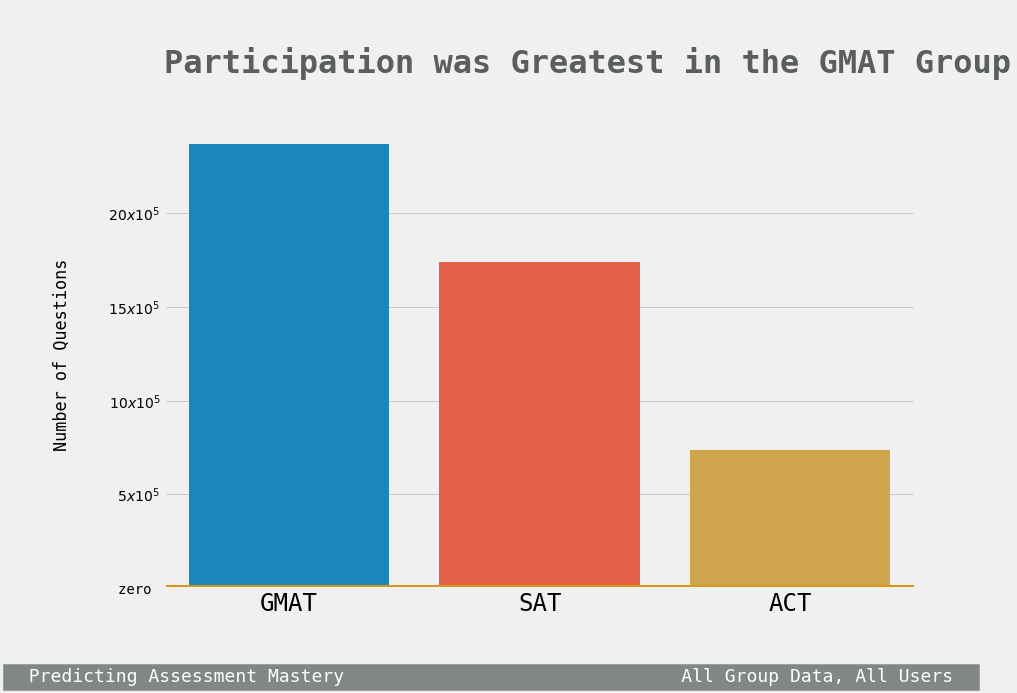

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
group_grph = sns.countplot(data=df, x='group_name')
group_grph.tick_params(axis='x', which='major', labelsize=24)
group_grph.set_yticklabels(labels=['zero ', '    $5x10^5$', '   $10x10^5$', '    $15x10^5$', '    $20x10^5$', '  $25x10^5$'])
group_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
group_grph.xaxis.label.set_visible(False)
group_grph.text(x=-1.125, y=-500000, 
                  s='  Predicting Assessment Mastery                               All Group Data, All Users  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.ylabel('Number of Questions')

# Add a title bar with some space at the top:
group_grph.text(x=0, y=3000000, s=' ', fontsize=24)
group_grph.text(x=-0.5, y=2750000, s='Participation was Greatest in the GMAT Group', fontsize=32, weight='bold', color='#5A5F5E')

# Save and display the plot:
plt.savefig('../reports/figures/group_distribution.png', bbox_inches='tight');

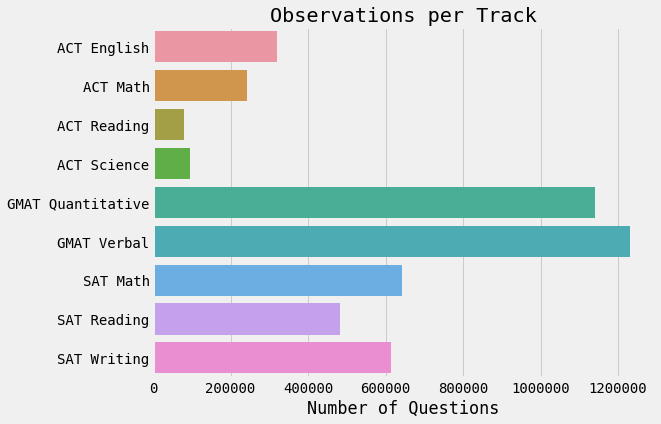

In [34]:
# Create bar plot for track_name distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='track_name')

# Create bar labels:
tracks = ('ACT English', 'ACT Math', 'ACT Reading', 'ACT Science', 'GMAT Quantitative', 
              'GMAT Verbal', 'SAT Math', 'SAT Reading', 'SAT Writing')
plt.yticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('Number of Questions')
plt.ylabel('')
plt.title('Observations per Track');

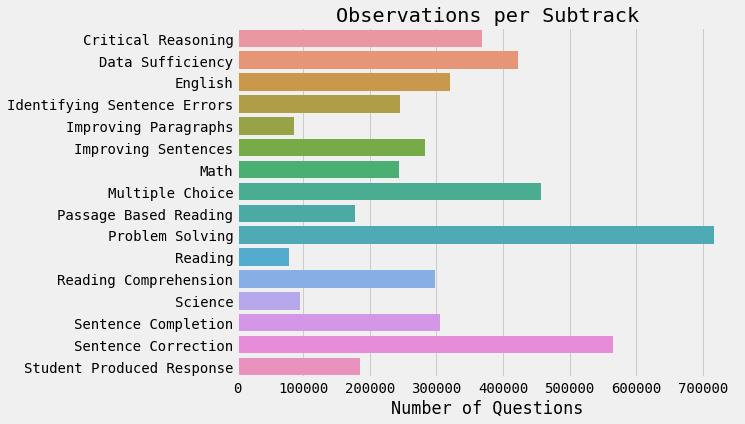

In [35]:
# Create bar plot for subtrack_name distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='subtrack_name')

# Create bar labels:
subtracks = ('Critical Reasoning', 'Data Sufficiency', 'English', 'Identifying Sentence Errors', 
             'Improving Paragraphs', 'Improving Sentences', 'Math', 'Multiple Choice', 
             'Passage Based Reading', 'Problem Solving', 'Reading', 'Reading Comprehension', 
             'Science', 'Sentence Completion', 'Sentence Correction', 'Student Produced Response')
plt.yticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('Number of Questions')
plt.ylabel('')
plt.title('Observations per Subtrack');

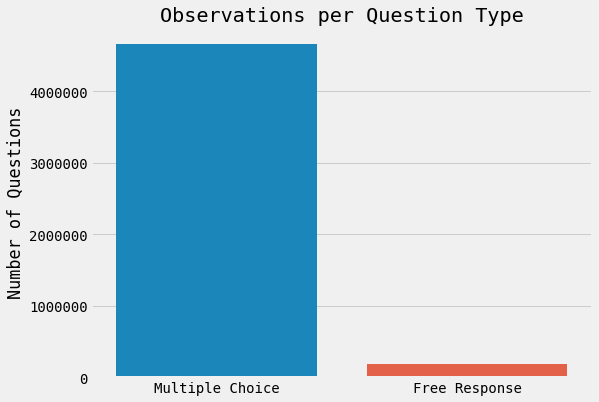

In [36]:
# Create bar plot for question_type distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='question_type')

# Create bar labels:
plt.xticks(np.arange(2), ('Multiple Choice', 'Free Response'))

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Observations per Question Type');

In [37]:
df.question_type.value_counts()

0    4661934
1     184796
Name: question_type, dtype: int64

In [38]:
df[df.question_type == 1]

user_id    round_started_at         answered_at      deactivated_at  \
317       112161 2009-04-30 20:43:34 2009-04-30 20:44:29 2009-04-30 20:45:23   
330        28612 2010-02-20 01:33:03 2010-02-20 01:33:06 2010-02-20 01:33:06   
378        71016 2010-11-17 01:40:32 2010-11-17 01:40:38 2010-11-17 01:40:40   
2016      150602 2011-10-21 14:57:14 2011-10-21 14:58:27 2011-10-21 14:58:31   
2017      150602 2011-10-21 14:58:31 2011-10-21 15:00:14 2011-10-21 15:00:16   
2018      150602 2011-10-21 15:00:16 2011-10-21 15:01:33 2011-10-21 15:01:35   
2019      150602 2011-10-21 15:01:35 2011-10-21 15:04:31 2011-10-21 15:04:34   
2022      150602 2011-10-21 15:07:16 2011-10-21 15:10:02 2011-10-21 15:10:05   
2023      150602 2011-10-21 15:10:05 2011-10-21 15:12:01 2011-10-21 15:12:03   
2026      150602 2011-10-21 15:40:24 2011-10-21 15:41:07 2011-10-21 15:41:09   
2027      150602 2011-10-21 15:41:16 2011-10-21 15:44:37 2011-10-21 15:44:38   
2031      150602 2011-10-21 16:02:56 2011-10-21 16:11:40 2011-10-21 16:11:41   
2032      150602 2011-10-21 16:15:04 2011-10-21 16:16:21 2011-10-21 16:16:22   
2033      150602 2011-10-21 16:20:03 2011-10-21 16:22:38 2011-10-21 16:22:39   
2140      113268 2009-05-15 02:42:23                 NaT 2009-05-15 02:45:06   
2237      143727 2011-05-26 17:38:55 2011-05-26 17:39:00 2011-05-26 17:39:02   
2243      143727 2011-05-26 17:41:54 2011-05-26 17:42:00 2011-05-26 17:42:02   
2347      128637 2010-12-23 02:53:00                 NaT 2010-12-23 02:53:35   
2829       70021 2011-09-07 22:08:55 2011-09-07 22:09:44 2011-09-07 22:09:46   
2830       70021 2011-09-07 22:09:46 2011-09-07 22:11:42 2011-09-07 22:11:44   
2832       70021 2011-09-07 22:11:50 2011-09-07 22:12:23 2011-09-07 22:12:24   
2833       70021 2011-09-07 22:12:24 2011-09-07 22:14:00 2011-09-07 22:14:01   
2834       70021 2011-09-07 22:14:01 2011-09-07 22:14:45 2011-09-07 22:14:47   
2835       70021 2011-09-07 22:14:47 2011-09-07 22:15:43 2011-09-07 22:15:44   
2836       70021 2011-09-07 22:15:44 2011-09-07 22:16:05 2011-09-07 22:16:06   
2841       53359 2009-06-21 12:46:17 2009-06-21 12:47:34 2009-06-21 12:47:34   
2843       53359 2009-06-21 12:48:49 2009-06-21 12:49:09 2009-06-21 12:49:09   
2845       53359 2009-06-21 12:49:28 2009-06-21 12:49:53 2009-06-21 12:49:53   
2851      105795 2011-01-03 04:48:54 2011-01-03 04:49:59 2011-01-03 04:50:03   
2853      105795 2011-01-03 04:53:03 2011-01-03 04:55:50 2011-01-03 04:55:51   
...          ...                 ...                 ...                 ...   
4846144   165825 2010-09-03 15:48:46 2010-09-03 15:52:39 2010-09-03 15:52:41   
4846146   165825 2010-09-03 15:53:33 2010-09-03 15:58:59 2010-09-03 15:59:01   
4846148   165825 2010-09-03 16:01:20 2010-09-03 16:05:01 2010-09-03 16:05:03   
4846151   165825 2010-09-03 16:12:50 2010-09-03 16:14:37 2010-09-03 16:14:39   
4846152   165825 2010-09-03 16:14:51 2010-09-03 16:15:46 2010-09-03 16:15:48   
4846155   165825 2010-09-03 16:18:42 2010-09-03 16:19:39 2010-09-03 16:19:40   
4846176    70942 2010-01-23 00:40:21 2010-01-23 00:44:14 2010-01-23 00:44:21   
4846193   169815 2010-07-22 19:46:05                 NaT 2010-07-22 19:47:13   
4846414   177296 2011-03-26 00:49:45 2011-03-26 00:50:27 2011-03-26 00:50:29   
4846449   111669 2011-01-26 17:34:19 2011-01-26 17:37:17 2011-01-26 17:37:19   
4846451   111669 2011-01-26 17:39:19 2011-01-26 17:42:36 2011-01-26 17:42:37   
4846452   111669 2011-01-26 17:44:23 2011-01-26 17:45:54 2011-01-26 17:45:57   
4846454   111669 2011-01-26 17:48:55 2011-01-26 17:51:58 2011-01-26 17:52:00   
4846464   111669 2011-01-26 18:05:30                 NaT 2011-01-26 18:09:30   
4846467   111669 2011-01-26 18:13:22                 NaT 2011-01-26 18:17:22   
4846524   111669 2011-01-31 17:06:19                 NaT 2011-01-31 17:07:21   
4846527   111669 2011-01-31 19:38:51 2011-01-31 19:39:10 2011-01-31 19:39:11   
4846537   111669 2011-01-31 19:47:41 2011-01-31 19:48:24 2011-01-31 19:48:26   
4846600  

In [39]:
df[df.question_type == 1].group_name.value_counts()

SAT    184796
Name: group_name, dtype: int64

In [40]:
df[df.question_type == 1].subtrack_name.value_counts()

15    184796
Name: subtrack_name, dtype: int64

Inclination was to drop the `question_type` category since most observations are multiple choice, but free response questions belong only to the SAT group, so it could be eliminated for the other two. The only subtrack associated with Free Response is Student Produced Response, which makes sense and could be informative.

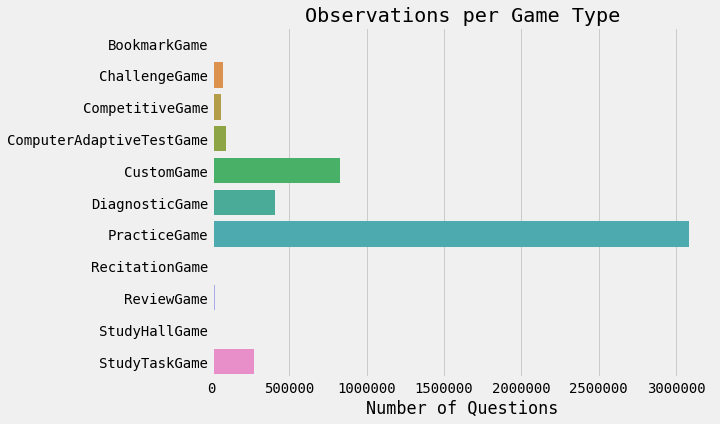

In [41]:
# Create bar plot for game_type distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, y='game_type')

# Create bar labels:
game_types = ('BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 
              'CustomGame', 'DiagnosticGame', 'PracticeGame', 'RecitationGame', 
              'ReviewGame', 'StudyHallGame', 'StudyTaskGame')
plt.yticks(np.arange(len(game_types)), game_types)

# Create axis labels and the title:
plt.xlabel('Number of Questions')
plt.ylabel('')
plt.title('Observations per Game Type');

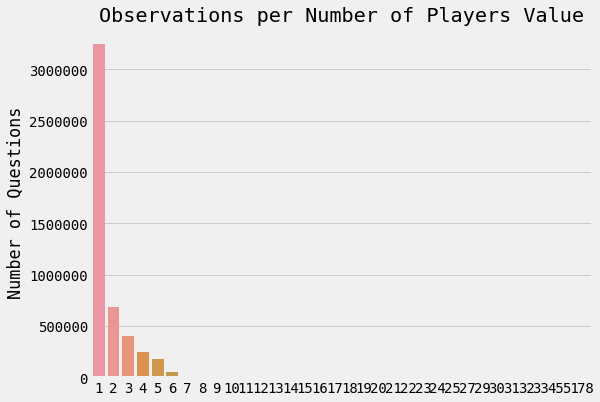

In [42]:
# Create bar plot for num_players distribution:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x='num_players')

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Observations per Number of Players Value');

Intuition and some of the graphs above suggest the test groups are independent.

## Investigate Overlap of Test Groups

In [43]:
# Get a view of tiered variables related to question groups:
group_tracks = pd.crosstab(index=df.subtrack_name,columns=[df.group_name, df.track_name])
group_tracks

group_name        ACT                          GMAT             SAT          \
track_name          0       1      2      3       4       5       6       7   
subtrack_name                                                                 
0                   0       0      0      0       0  368856       0       0   
1                   0       0      0      0  422357       0       0       0   
2              320223       0      0      0       0       0       0       0   
3                   0       0      0      0       0       0       0       0   
4                   0       0      0      0       0       0       0       0   
5                   0       0      0      0       0       0       0       0   
6                   0  242967      0      0       0       0       0       0   
7                   0       0      0      0       0       0  456716       0   
8                   0       0      0      0       0       0       0  178051   
9                   0       0      0      0  717200       0       0       0   
10                  0       0  78771      0       0       0       0       0   
11                  0       0      0      0       0  297284       0       0   
12                  0       0      0  94736       0       0       0       0   
13                  0       0      0      0       0       0       0  305381   
14                  0       0      0      0       0  565691       0       0   
15                  0       0      0      0       0       0  184796       0   

group_name             
track_name          8  
subtrack_name          
0                   0  
1                   0  
2                   0  
3              245322  
4               86282  
5              282097  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0

This confirms that there is no overlap in the tracks or subtracks across groups. There is only one subtrack for each ACT track, so either variable will be fine to explore or drop.

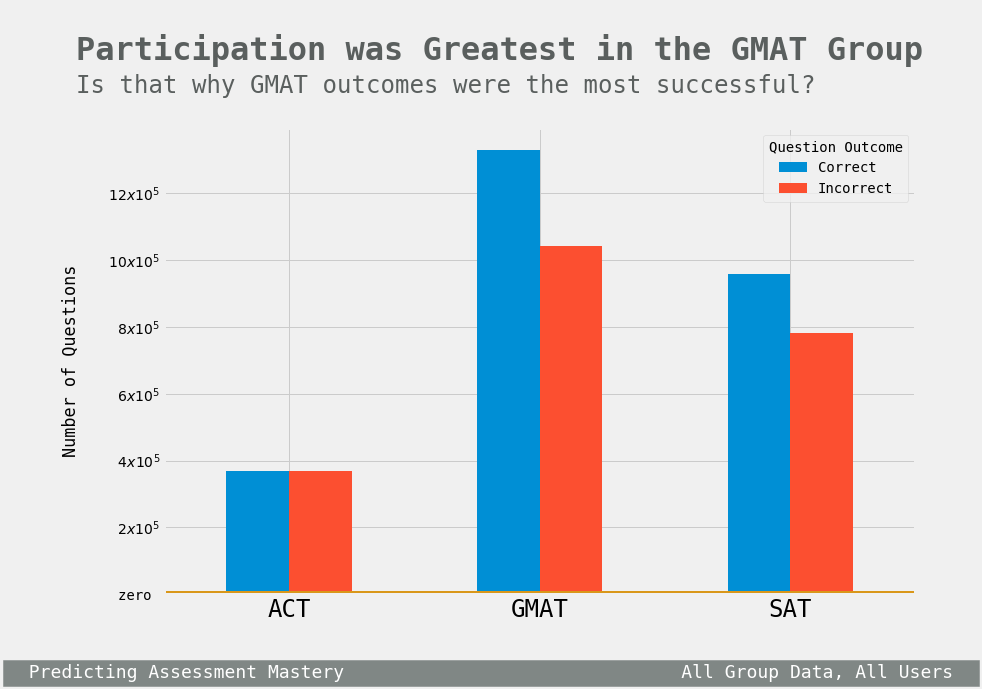

In [44]:
group_grph = pd.crosstab(index=df.group_name, columns=[df.outcome]).plot(kind='bar', stacked=False, figsize=(12, 8))
group_grph.tick_params(axis='x', which='major', labelsize=24, rotation='auto')
group_grph.set_yticklabels(labels=['zero ', '    $2x10^5$', '  $4x10^5$', '   $6x10^5$', '   $8x10^5$', '  $10x10^5$', '  $12x10^5$'])
group_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
group_grph.legend(title='Question Outcome')
group_grph.xaxis.label.set_visible(False)
group_grph.text(x=-1.125, y=-250000, 
                  s='  Predicting Assessment Mastery                               All Group Data, All Users  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.ylabel('Number of Questions')

# Add a title bar with some space at the top:
group_grph.text(x=0, y=1700000, s=' ', fontsize=24)
group_grph.text(x=-0.85, y=1600000, s='Participation was Greatest in the GMAT Group', fontsize=32, weight='bold', color='#5A5F5E')
group_grph.text(x=-0.85, y=1500000, s='Is that why GMAT outcomes were the most successful?', fontsize=24, color='#5A5F5E')

# Save and display the plot:
plt.savefig('../reports/figures/group_outcomes.png', bbox_inches='tight');

## Divide the Dataframe

In [45]:
# Drop selected columns and save results:
df2 = df.drop(['num_questions', 'few', 'many'], axis=1)

In [46]:
def user_stats(df):
    
    # Save the total number of entries per user in the 'correct' column:
    num_questions = df.groupby('user_id')['correct'].count()

    # Save the total number of correct entries per user in the 'correct' column;
    # values are 0 (incorrect) and 1 (correct), so a sum of values in the column will do:
    num_correct = df.groupby('user_id')['correct'].sum()

    # Save the total number of incorrect entries per user by subracting correct from total:
    num_incorrect = num_questions.subtract(num_correct)

    # Save the ratio of correct answers per user, dividing by total:
    correct_ratio = num_correct/num_questions


    # Get and save the sum of each user's round duration:
    total_practice = df.groupby('user_id')['round_duration'].sum()

    # Calculate and save the mean round duration per user:
    round_duration_avg = total_practice/num_questions


    # Build and save the dictionary to look at user data:
    new_data = {
        'num_questions': num_questions,
        'num_correct': num_correct,
        'num_incorrect': num_incorrect,
        'correct_ratio': correct_ratio,
        'total_practice': total_practice,
        'round_duration_avg': round_duration_avg
    }

    # Build dataframe from new_data dictionary:
    user_stats = pd.DataFrame(new_data)
    
    # Convert round_duration to timedelta:
    user_stats['round_duration_avg'] = pd.to_timedelta(user_stats.round_duration_avg)


    user_stats['few'] = np.where(user_stats.num_questions < 6, 1, 0)
    user_stats['many'] = np.where(user_stats.num_questions > 4000, 1, 0)

    user_stats['fast_avg'] = np.where(user_stats.round_duration_avg < '5seconds', 1, 0)
    user_stats['slow_avg'] = np.where(user_stats.round_duration_avg > '10minutes', 1, 0)

    # Reorder the columns:
    user_stats = user_stats[['num_correct', 'num_incorrect', 'num_questions', 'few', 'many', 'correct_ratio', 'total_practice', 'round_duration_avg', 'slow_avg', 'fast_avg']]

    data = user_stats.reset_index(drop=False)
    data = data.rename(columns = {'index':'user_id'})
    

    df = pd.merge(df, data, on='user_id', how='inner')
    
    return df, user_stats

In [47]:
def cdf(data):
    """Compute CDF for a one-dimensional array of measurements."""

    # Number of data points:
    n = len(data)

    # x-data for the CDF:
    x = np.sort(data)

    # y-data for the CDF:
    y = np.arange(1, n+1) / n

    return x, y

In [48]:
# Save and inspect a dataframe of observations for the ACT group only:
act = df2[df2['group_name'] == 'ACT']
act, act_users = user_stats(act)
act.head()

user_id    round_started_at         answered_at      deactivated_at  \
0   121052 2011-11-10 18:32:18 2011-11-10 18:32:44 2011-11-10 18:33:21   
1   121052 2011-11-10 18:34:49 2011-11-10 18:35:45 2011-11-10 18:35:47   
2   121052 2011-11-10 18:36:03 2011-11-10 18:36:50 2011-11-10 18:37:06   
3   121052 2011-11-10 18:37:15 2011-11-10 18:37:31 2011-11-10 18:37:45   
4   121052 2011-11-10 18:37:50 2011-11-10 18:38:15 2011-11-10 18:38:17   

       round_ended_at  correct  question_id group_name  track_name  \
0 2011-11-10 18:32:44        1         3010        ACT           3   
1 2011-11-10 18:35:45        1         4446        ACT           3   
2 2011-11-10 18:36:50        1         1488        ACT           3   
3 2011-11-10 18:37:31        1          787        ACT           3   
4 2011-11-10 18:38:15        1         2526        ACT           3   

   subtrack_name                    tag_string  question_type  game_type  \
0             12           22 51 56 61 114 243              0          7   
1             12           16 22 50 51 123 243              0          7   
2             12  34 51 61 114 123 146 152 243              0          7   
3             12    6 34 50 51 102 114 152 243              0          7   
4             12         34 50 152 162 212 243              0          7   

   num_players round_duration  fast  slow  prior_attempts  excessive_attempts  \
0            3       00:00:26     0     0               0                   0   
1            2       00:00:56     0     0               0                   0   
2            2       00:00:47     0     0               0                   0   
3            2       00:00:16     0     0               0                   0   
4            2       00:00:25     0     0               0                   0   

   outcome  num_correct  num_incorrect  num_questions  few  many  \
0  Correct            6              0              6    0     0   
1  Correct            6              0              6    0     0   
2  Correct            6              0              6    0     0   
3  Correct            6              0              6    0     0   
4  Correct            6              0              6    0     0   

   correct_ratio total_practice round_duration_avg  slow_avg  fast_avg  
0            1.0       00:03:20    00:00:33.333333         0         0  
1            1.0       00:03:20    00:00:33.333333         0         0  
2            1.0       00:03:20    00:00:33.333333         0         0  
3            1.0       00:03:20    00:00:33.333333         0         0  
4            1.0       00:03:20    00:00:33.333333         0         0

In [49]:
# Save and inspect a dataframe of observations for the GMAT group only:
gmat = df2[df2['group_name'] == 'GMAT']
gmat, gmat_users = user_stats(gmat)
gmat.head()

user_id    round_started_at         answered_at      deactivated_at  \
0    85818 2010-08-18 20:17:13 2010-08-18 20:18:18 2010-08-18 20:18:18   
1    85818 2010-08-18 20:19:12 2010-08-18 20:20:34 2010-08-18 20:20:34   
2    85818 2010-08-18 20:20:42 2010-08-18 20:21:56 2010-08-18 20:21:56   
3    85818 2010-08-18 20:22:03 2010-08-18 20:23:05 2010-08-18 20:23:05   
4    85818 2010-08-18 20:23:11 2010-08-18 20:26:08 2010-08-18 20:26:08   

       round_ended_at  correct  question_id group_name  track_name  \
0 2010-08-18 20:18:18        0         5560       GMAT           5   
1 2010-08-18 20:20:34        1         4681       GMAT           5   
2 2010-08-18 20:21:56        1         1529       GMAT           5   
3 2010-08-18 20:23:05        1         2908       GMAT           5   
4 2010-08-18 20:26:08        1         1773       GMAT           5   

   subtrack_name       tag_string  question_type  game_type  num_players  \
0             14  222 233 240 246              0          7            1   
1              0            24 49              0          7            1   
2              0            31 49              0          7            1   
3              0            31 49              0          7            1   
4             11      183 194 207              0          7            1   

  round_duration  fast  slow  prior_attempts  excessive_attempts    outcome  \
0       00:01:05     0     0               0                   0  Incorrect   
1       00:01:22     0     0               0                   0    Correct   
2       00:01:14     0     0               0                   0    Correct   
3       00:01:02     0     0               0                   0    Correct   
4       00:02:57     0     0               0                   0    Correct   

   num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
0          169            146            315    0     0       0.536508   
1          169            146            315    0     0       0.536508   
2          169            146            315    0     0       0.536508   
3          169            146            315    0     0       0.536508   
4          169            146            315    0     0       0.536508   

  total_practice round_duration_avg  slow_avg  fast_avg  
0       07:42:42    00:01:28.133333         0         0  
1       07:42:42    00:01:28.133333         0         0  
2       07:42:42    00:01:28.133333         0         0  
3       07:42:42    00:01:28.133333         0         0  
4       07:42:42    00:01:28.133333         0         0

In [50]:
# Save and inspect a dataframe of observations for the SAT group only:
sat = df2[df2['group_name'] == 'SAT']
sat, sat_users = user_stats(sat)
sat.head()

user_id    round_started_at         answered_at      deactivated_at  \
0   112161 2009-04-30 20:41:56 2009-04-30 20:42:37 2009-04-30 20:42:37   
1   112161 2009-04-30 20:42:50 2009-04-30 20:43:19 2009-04-30 20:43:21   
2   112161 2009-04-30 20:43:34 2009-04-30 20:44:29 2009-04-30 20:45:23   
3   154786 2011-05-27 17:04:44 2011-05-27 17:06:24 2011-05-27 17:08:44   
4   154786 2011-05-27 17:10:59 2011-05-27 17:11:43 2011-05-27 17:11:47   

       round_ended_at  correct  question_id group_name  track_name  \
0 2009-04-30 20:42:37        1         4814        SAT           6   
1 2009-04-30 20:43:19        1         2884        SAT           6   
2 2009-04-30 20:44:29        0          994        SAT           6   
3 2011-05-27 17:06:24        0         5706        SAT           6   
4 2011-05-27 17:11:43        1          225        SAT           6   

   subtrack_name                  tag_string  question_type  game_type  \
0              7  83 131 150 169 215 257 279              0          7   
1              7                  53 131 159              0          7   
2             15                   5 218 261              1          7   
3              7          53 131 137 159 279              0          7   
4              7                   5 131 138              0          7   

   num_players round_duration  fast  slow  prior_attempts  excessive_attempts  \
0            1       00:00:41     0     0               0                   0   
1            2       00:00:29     0     0               0                   0   
2            3       00:00:55     0     0               0                   0   
3            2       00:01:40     0     0               0                   0   
4            1       00:00:44     0     0               0                   0   

     outcome  num_correct  num_incorrect  num_questions  few  many  \
0    Correct            2              1              3    1     0   
1    Correct            2              1              3    1     0   
2  Incorrect            2              1              3    1     0   
3  Incorrect            2              2              4    1     0   
4    Correct            2              2              4    1     0   

   correct_ratio total_practice round_duration_avg  slow_avg  fast_avg  
0       0.666667       00:02:05    00:00:41.666666         0         0  
1       0.666667       00:02:05    00:00:41.666666         0         0  
2       0.666667       00:02:05    00:00:41.666666         0         0  
3       0.500000       00:04:39    00:01:09.750000         0         0  
4       0.500000       00:04:39    00:01:09.750000         0         0

### Overlap of Other Variables across Test Groups

#### USERS
---

In [51]:
act_unique_users = set(act.user_id)
print('Number of Users Preparing for ACT:', len(act_unique_users))

gmat_unique_users = set(gmat.user_id)
print('Number of Users Preparing for GMAT:', len(gmat_unique_users))

sat_unique_users = set(sat.user_id)
print('Number of Users Preparing for SAT:', len(sat_unique_users))

Number of Users Preparing for ACT: 38518
Number of Users Preparing for GMAT: 78488
Number of Users Preparing for SAT: 64834


In [52]:
print('Number of Users Preparing for All Test Groups:', len(act_unique_users.intersection(gmat_unique_users, sat_unique_users)))
print('Number of Users Preparing for ACT & GMAT:', len(act_unique_users.intersection(gmat_unique_users)))
print('Number of Users Preparing for ACT & SAT:', len(act_unique_users.intersection(sat_unique_users)))
print('Number of Users Preparing for GMAT & SAT:', len(gmat_unique_users.intersection(sat_unique_users)))

Number of Users Preparing for All Test Groups: 228
Number of Users Preparing for ACT & GMAT: 377
Number of Users Preparing for ACT & SAT: 1638
Number of Users Preparing for GMAT & SAT: 1020


#### UNIQUE QUESTIONS
---

In [53]:
act_unique_questions = set(act.question_id)
print('Number of Unique Questions in the ACT Group:', len(act_unique_questions))

gmat_unique_questions = set(gmat.question_id)
print('Number of Unique Questions in the GMAT Group:', len(gmat_unique_questions))

sat_unique_questions = set(sat.question_id)
print('Number of Unique Questions in the SAT Group:', len(sat_unique_questions))

Number of Unique Questions in the ACT Group: 2094
Number of Unique Questions in the GMAT Group: 2203
Number of Unique Questions in the SAT Group: 1748


In [54]:
print('Number of Unique Questions in All Test Groups:', len(act_unique_questions.intersection(gmat_unique_questions, sat_unique_questions)))
print('Number of Unique Questions in the ACT & GMAT Test Groups:', len(act_unique_questions.intersection(gmat_unique_questions)))
print('Number of Unique Questions in the ACT & SAT Test Groups:', len(act_unique_questions.intersection(sat_unique_questions)))
print('Number of Unique Questions in the GMAT & SAT Test Groups:', len(gmat_unique_questions.intersection(sat_unique_questions)))

Number of Unique Questions in All Test Groups: 0
Number of Unique Questions in the ACT & GMAT Test Groups: 0
Number of Unique Questions in the ACT & SAT Test Groups: 0
Number of Unique Questions in the GMAT & SAT Test Groups: 0


Unique values for each group name: 2094 + 2203 + 1748 = 6045

<a href='#top' id='act'>back to menu</a>

---
## ACT EDA

In [55]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    act[column] = act[column].astype('category')

# Convert ordered categorical variables:
act['num_players'] = pd.Categorical(act['num_players'], ordered=True)
act['prior_attempts'] = pd.Categorical(act['prior_attempts'], ordered=True)

In [56]:
print('Group name counts associated with excessive prior attempts:')
act[act.excessive_attempts == True].group_name.value_counts()

Group name counts associated with excessive prior attempts:


ACT    0
Name: group_name, dtype: int64

## All Observations (ACT)

In [57]:
# Display statistics for numerical variables:
act.describe()

correct          round_duration    num_correct  num_incorrect  \
count  736697.000000                  736697  736697.000000  736697.000000   
mean        0.500982  0 days 00:00:53.109867     150.993183     122.193271   
std         0.499999  0 days 00:05:31.306196     365.151758     276.460689   
min         0.000000         0 days 00:00:01       0.000000       0.000000   
25%         0.000000         0 days 00:00:19       9.000000       9.000000   
50%         1.000000         0 days 00:00:36      32.000000      31.000000   
75%         1.000000         0 days 00:01:07     123.000000     105.000000   
max         1.000000         3 days 04:29:45    2911.000000    2298.000000   

       num_questions  correct_ratio          total_practice  \
count  736697.000000  736697.000000                  736697   
mean      273.186454       0.500982  0 days 03:42:10.424261   
std       623.009494       0.196787  0 days 08:30:10.813180   
min         1.000000       0.000000         0 days 00:00:01   
25%        19.000000       0.375000         0 days 00:14:44   
50%        66.000000       0.516129         0 days 00:49:24   
75%       234.000000       0.639085         0 days 03:04:25   
max      5209.000000       1.000000         3 days 04:29:45   

           round_duration_avg  
count                  736697  
mean   0 days 00:00:53.109867  
std    0 days 00:05:22.732728  
min           0 days 00:00:01  
25%    0 days 00:00:35.148648  
50%    0 days 00:00:48.424242  
75%    0 days 00:01:03.831615  
max           3 days 04:29:45

In [58]:
# Filter columns for category datatype and display the statistics:
categorical = act.dtypes[act.dtypes == 'category'].index
act[categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count    736697       736697     736697      736697         736697   
unique    38518         2094          1           4              4   
top      132295         5813        ACT           0              2   
freq       5209         7492     736697      320223         320223   

        question_type  game_type  num_players    fast    slow  prior_attempts  \
count          736697     736697       736697  736697  736697          736697   
unique              1         10           25       2       2              42   
top                 0          7            1       0       0               0   
freq           736697     562789       566185  696984  736182          688641   

        excessive_attempts  outcome     few    many  slow_avg  fast_avg  
count               736697   736697  736697  736697    736697    736697  
unique                   1        2       2       2         2         2  
top                      0  Correct       0       0         0         0  
freq                736697   369072  696834  731488    736596    732866

## At least 30 Questions per User (ACT)

In [59]:
# Save and inspect a dataframe of observations for the ACT group only:
act2 = df2[df2['group_name'] == 'ACT']
act_30 = act2.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
act_30, act_users_30 = user_stats(act_30)
act_30.head()

user_id    round_started_at         answered_at      deactivated_at  \
0   130429 2010-10-21 17:16:52                 NaT 2010-10-21 17:18:01   
1   130429 2010-10-21 17:26:30 2010-10-21 17:26:40 2010-10-21 17:27:38   
2   130429 2010-10-21 17:28:24 2010-10-21 17:28:59 2010-10-21 17:29:02   
3   130429 2010-10-21 17:29:32 2010-10-21 17:29:48 2010-10-21 17:30:45   
4   130429 2010-10-21 17:30:59                 NaT 2010-10-21 17:32:02   

       round_ended_at  correct  question_id group_name  track_name  \
0 2010-10-21 17:18:01        0         3115        ACT           3   
1 2010-10-21 17:26:40        0         1530        ACT           0   
2 2010-10-21 17:28:59        0         3488        ACT           1   
3 2010-10-21 17:29:48        0         2505        ACT           1   
4 2010-10-21 17:32:02        0         3945        ACT           1   

   subtrack_name                tag_string  question_type  game_type  \
0             12  16 34 39 123 152 212 243              0          7   
1              2                    65 172              0          7   
2              6      46 64 86 125 254 268              0          7   
3              6           125 135 155 209              0          7   
4              6          21 64 81 112 125              0          7   

   num_players round_duration  fast  slow  prior_attempts  excessive_attempts  \
0            1       00:01:09     0     0               0                   0   
1            2       00:00:10     0     0               0                   0   
2            3       00:00:35     0     0               0                   0   
3            4       00:00:16     0     0               0                   0   
4            4       00:01:03     0     0               0                   0   

     outcome  num_correct  num_incorrect  num_questions  few  many  \
0  Incorrect           10             23             33    0     0   
1  Incorrect           10             23             33    0     0   
2  Incorrect           10             23             33    0     0   
3  Incorrect           10             23             33    0     0   
4  Incorrect           10             23             33    0     0   

   correct_ratio total_practice round_duration_avg  slow_avg  fast_avg  
0        0.30303       00:28:55    00:00:52.575757         0         0  
1        0.30303       00:28:55    00:00:52.575757         0         0  
2        0.30303       00:28:55    00:00:52.575757         0         0  
3        0.30303       00:28:55    00:00:52.575757         0         0  
4        0.30303       00:28:55    00:00:52.575757         0         0

In [60]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    act_30[column] = act_30[column].astype('category')

# Convert ordered categorical variables:
act_30['num_players'] = pd.Categorical(act_30['num_players'], ordered=True)
act_30['prior_attempts'] = pd.Categorical(act_30['prior_attempts'], ordered=True)

## User Data (ACT)

In [61]:
act_users.head()

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
0                  5              2              7    0     0       0.714286   
2                  2              6              8    0     0       0.250000   
6                 19             21             40    0     0       0.475000   
9                 19              9             28    0     0       0.678571   
18                 0              3              3    1     0       0.000000   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
0             00:03:07    00:00:26.714285         0         0  
2             00:07:47    00:00:58.375000         0         0  
6             00:37:18    00:00:55.950000         0         0  
9             00:29:03    00:01:02.250000         0         0  
18            00:06:12           00:02:04         0         0

In [62]:
# Confirm the count of users in the group_name dataframe:
print( ("Number of ACT Users: "), len(act.user_id.value_counts()) )

Number of ACT Users:  38518


In [63]:
# Quick sanity check that dataframes were created appropriately - 
# Confirm the count of users in the user_stats dataframe:
print( ("Number of ACT Users: "), len(act_users) )

Number of ACT Users:  38518


In [64]:
act_users.describe()

num_correct  num_incorrect  num_questions           few          many  \
count  38518.000000   38518.000000   38518.000000  38518.000000  38518.000000   
mean       9.581806       9.544239      19.126045      0.438055      0.000026   
std       40.229642      32.684857      69.708658      0.496154      0.005095   
min        0.000000       0.000000       1.000000      0.000000      0.000000   
25%        0.000000       1.000000       2.000000      0.000000      0.000000   
50%        3.000000       3.000000       6.000000      0.000000      0.000000   
75%        7.000000       8.000000      15.000000      1.000000      0.000000   
max     2911.000000    2298.000000    5209.000000      1.000000      1.000000   

       correct_ratio          total_practice      round_duration_avg  \
count   38518.000000                   38518                   38518   
mean        0.347707  0 days 00:16:55.781712  0 days 00:01:12.431226   
std         0.295304  0 days 01:06:40.112800  0 days 00:23:25.677144   
min         0.000000         0 days 00:00:01         0 days 00:00:01   
25%         0.000000         0 days 00:02:13         0 days 00:00:35   
50%         0.360000         0 days 00:05:23  0 days 00:00:53.500000   
75%         0.576923         0 days 00:13:04  0 days 00:01:18.037660   
max         1.000000         3 days 04:29:45         3 days 04:29:45   

           slow_avg      fast_avg  
count  38518.000000  38518.000000  
mean       0.000623      0.004517  
std        0.024954      0.067060  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

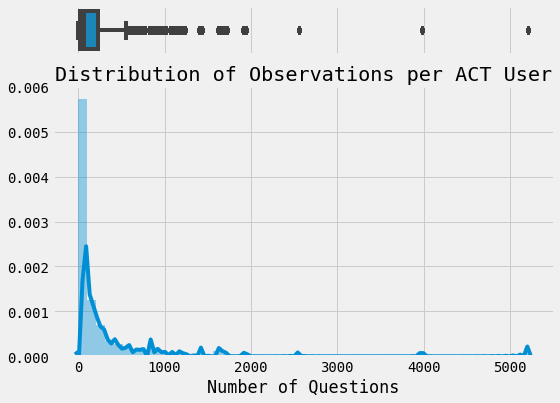

In [65]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per ACT User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [66]:
act_users['many'] = np.where(act_users.num_questions > 1250, 1, 0)

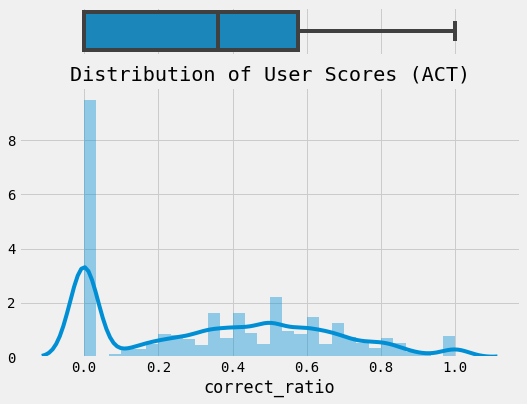

In [67]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act_users.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act_users.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (ACT)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [68]:
# Number of users with score == 0
print(('Number of ACT users with no correct answers:'), len(act_users[act_users.correct_ratio == 0])) 

Number of ACT users with no correct answers: 12198


In [69]:
# ACT users with more than a few attempts and no correct answers:
act_users[(act_users.correct_ratio == act_users.correct_ratio.min()) & (act_users.few == False)]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
70                 0              9              9    0     0            0.0   
99                 0              6              6    0     0            0.0   
808                0              6              6    0     0            0.0   
1187               0             10             10    0     0            0.0   
1286               0              8              8    0     0            0.0   
1353               0             19             19    0     0            0.0   
1364               0              8              8    0     0            0.0   
1447               0             10             10    0     0            0.0   
1701               0              6              6    0     0            0.0   
2024               0              8              8    0     0            0.0   
2633               0              6              6    0     0            0.0   
2806               0              6              6    0     0            0.0   
3247               0              7              7    0     0            0.0   
3542               0              6              6    0     0            0.0   
4164               0              8              8    0     0            0.0   
4198               0             10             10    0     0            0.0   
4294               0              7              7    0     0            0.0   
4352               0              7              7    0     0            0.0   
4703               0             12             12    0     0            0.0   
4736               0              7              7    0     0            0.0   
4953               0              7              7    0     0            0.0   
5770               0              7              7    0     0            0.0   
5991               0              6              6    0     0            0.0   
5997               0              6              6    0     0            0.0   
6028               0              6              6    0     0            0.0   
6037               0              8              8    0     0            0.0   
6092               0              6              6    0     0            0.0   
6653               0              6              6    0     0            0.0   
7051               0              7              7    0     0            0.0   
7086               0             10             10    0     0            0.0   
...              ...            ...            ...  ...   ...            ...   
167841             0             12             12    0     0            0.0   
167868             0              8              8    0     0            0.0   
168289             0              6              6    0     0            0.0   
168353             0              6              6    0     0            0.0   
168846             0             10             10    0     0            0.0   
169261             0              6              6    0     0            0.0   
169558             0              9              9    0     0            0.0   
169690             0              7              7    0     0            0.0   
169936             0              6              6    0     0            0.0   
169955             0              6              6    0     0            0.0   
170198             0              7              7    0     0            0.0   
170260             0              7              7    0     0            0.0   
171239             0              8              8    0     0            0.0   
171426             0              7              7    0     0            0.0   
172900             0              6              6    0     0            0.0   
173669             0              9              9    0     0            0.0   
173788             0              6              6    0     0            0.0   
174061   

In [70]:
# For users with no correct answers, view the number of users attempting each num_question value:
act_users[act_users.correct_ratio == 0].num_questions.value_counts()

1      7358
2      2334
3      1014
4       500
5       416
6       216
7       106
8        73
9        50
10       35
11       28
13       13
16        9
12        9
17        7
19        6
14        3
23        3
15        3
20        3
30        2
59        1
29        1
34        1
18        1
233       1
69        1
62        1
24        1
21        1
37        1
Name: num_questions, dtype: int64

One user attempted 233 questions and didn't answer any of them correctly. 

In [71]:
act_users[(act_users.correct_ratio == 0) & (act_users.num_questions == 233)]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
100283             0            233            233    0     0            0.0   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
100283        00:36:04    00:00:09.287553         0         0

In [72]:
df[df.user_id.isin(act_users[(act_users.correct_ratio == 0) & (act_users.num_questions == 233)].index.values)]

user_id    round_started_at         answered_at      deactivated_at  \
3253509   100283 2011-07-01 03:34:51                 NaT 2011-07-01 03:38:51   
3253510   100283 2011-07-01 03:40:09 2011-07-01 03:41:02 2011-07-01 03:41:23   
3253511   100283 2011-07-01 03:41:23 2011-07-01 03:41:55 2011-07-01 03:41:58   
3253512   100283 2011-07-01 03:41:58 2011-07-01 03:42:29 2011-07-01 03:42:32   
3253513   100283 2011-07-01 03:42:32 2011-07-01 03:43:03 2011-07-01 03:43:07   
3253514   100283 2011-07-01 03:43:07 2011-07-01 03:43:44 2011-07-01 03:43:47   
3253515   100283 2011-07-01 03:43:47 2011-07-01 03:44:24 2011-07-01 03:44:26   
3253516   100283 2011-07-01 03:44:26 2011-07-01 03:45:00 2011-07-01 03:45:03   
3253517   100283 2011-07-01 03:45:03 2011-07-01 03:45:26 2011-07-01 03:45:28   
3253518   100283 2011-07-01 03:45:28 2011-07-01 03:45:52 2011-07-01 03:45:55   
3253519   100283 2011-07-01 03:45:55 2011-07-01 03:46:26 2011-07-01 03:46:32   
3253520   100283 2011-07-01 03:46:32 2011-07-01 03:46:49 2011-07-01 03:46:52   
3253521   100283 2011-07-01 03:46:52 2011-07-01 03:48:59 2011-07-01 03:49:02   
3253522   100283 2011-07-01 03:49:02 2011-07-01 03:49:25 2011-07-01 03:49:28   
3253523   100283 2011-07-01 03:49:28 2011-07-01 03:49:57 2011-07-01 03:50:00   
3253524   100283 2011-07-01 03:50:00 2011-07-01 03:50:18 2011-07-01 03:50:21   
3253525   100283 2011-07-01 03:50:21 2011-07-01 03:50:30 2011-07-01 03:50:37   
3253526   100283 2011-07-01 03:50:37 2011-07-01 03:50:41 2011-07-01 03:50:44   
3253527   100283 2011-07-01 03:50:44 2011-07-01 03:50:50 2011-07-01 03:50:52   
3253528   100283 2011-07-01 03:50:52 2011-07-01 03:50:59 2011-07-01 03:51:01   
3253529   100283 2011-07-01 03:51:01 2011-07-01 03:51:04 2011-07-01 03:51:07   
3253530   100283 2011-07-01 03:51:07 2011-07-01 03:51:10 2011-07-01 03:51:12   
3253531   100283 2011-07-01 03:51:12 2011-07-01 03:51:16 2011-07-01 03:51:18   
3253532   100283 2011-07-01 03:51:18 2011-07-01 03:51:23 2011-07-01 03:51:26   
3253533   100283 2011-07-01 03:51:26 2011-07-01 03:51:29 2011-07-01 03:51:32   
3253534   100283 2011-07-01 03:51:32 2011-07-01 03:51:45 2011-07-01 03:51:47   
3253535   100283 2011-07-01 03:51:47 2011-07-01 03:51:51 2011-07-01 03:51:52   
3253536   100283 2011-07-01 03:51:52 2011-07-01 03:52:00 2011-07-01 03:52:03   
3253537   100283 2011-07-01 03:52:03 2011-07-01 03:52:06 2011-07-01 03:52:12   
3253538   100283 2011-07-01 03:52:12 2011-07-01 03:52:20 2011-07-01 03:52:22   
...          ...                 ...                 ...                 ...   
3253712   100283 2011-07-01 04:05:14                 NaT 2011-07-01 04:05:56   
3253713   100283 2011-07-01 04:05:56                 NaT 2011-07-01 04:05:57   
3253714   100283 2011-07-01 04:05:57                 NaT 2011-07-01 04:05:59   
3253715   100283 2011-07-01 04:05:59                 NaT 2011-07-01 04:06:00   
3253716   100283 2011-07-01 04:06:00                 NaT 2011-07-01 04:06:01   
3253717   100283 2011-07-01 04:06:01                 NaT 2011-07-01 04:06:02   
3253718   100283 2011-07-01 04:06:02                 NaT 2011-07-01 04:06:03   
3253719   100283 2011-07-01 04:06:03                 NaT 2011-07-01 04:06:05   
3253720   100283 2011-07-01 04:06:05                 NaT 2011-07-01 04:06:06   
3253721   100283 2011-07-01 04:06:06                 NaT 2011-07-01 04:06:07   
3253722   100283 2011-07-01 04:06:07                 NaT 2011-07-01 04:07:13   
3253723   100283 2011-07-01 04:06:16                 NaT 2011-07-01 04:06:26   
3253724   100283 2011-07-01 04:06:26                 NaT 2011-07-01 04:06:29   
3253725   100283 2011-07-01 04:06:29                 NaT 2011-07-01 04:06:30   
3253726   100283 2011-07-01 04:06:30                 NaT 2011-07-01 04:06:32   
3253727   100283 2011-07-01 04:06:32                 NaT 2011-07-01 04:06:43   
3253728   100283 2011-07-01 04:06:43                 NaT 2011-07-01 04:06:58   
3253729   100283 2011-07-01 04:06:58                 NaT 2011-07-01 04:07:08   
3253730  

This user was borderline slow in attempting questions, but nothing stands out to help explain the poor performance. 

In [73]:
act_users_30.describe()

num_correct  num_incorrect  num_questions     few         many  \
count  4815.000000    4815.000000    4815.000000  4815.0  4815.000000   
mean     53.737279      48.241121     101.978401     0.0     0.000208   
std     103.003859      82.068733     175.290142     0.0     0.014411   
min       0.000000       0.000000      30.000000     0.0     0.000000   
25%      18.000000      19.000000      39.000000     0.0     0.000000   
50%      28.000000      28.000000      55.000000     0.0     0.000000   
75%      51.000000      49.000000      98.000000     0.0     0.000000   
max    2911.000000    2298.000000    5209.000000     0.0     1.000000   

       correct_ratio          total_practice      round_duration_avg  \
count    4815.000000                    4815                    4815   
mean        0.507080  0 days 01:25:56.633437  0 days 00:00:50.990146   
std         0.166283  0 days 02:39:00.641478  0 days 00:00:24.816683   
min         0.000000         0 days 00:01:41  0 days 00:00:01.304347   
25%         0.385965         0 days 00:28:50  0 days 00:00:34.942653   
50%         0.511628         0 days 00:45:28  0 days 00:00:47.684210   
75%         0.628571         0 days 01:24:25  0 days 00:01:01.927055   
max         1.000000         3 days 02:22:31  0 days 00:05:33.343750   

       slow_avg     fast_avg  
count    4815.0  4815.000000  
mean        0.0     0.004154  
std         0.0     0.064322  
min         0.0     0.000000  
25%         0.0     0.000000  
50%         0.0     0.000000  
75%         0.0     0.000000  
max         0.0     1.000000

In [74]:
n = len(act_users_30.correct_ratio)
M = np.mean(act_users_30.correct_ratio)
s = np.std(act_users_30.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

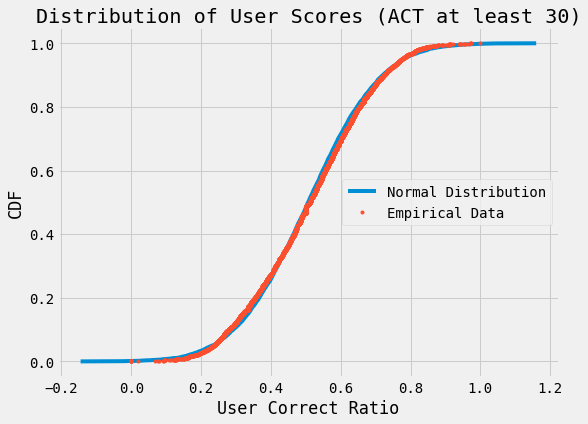

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(act_users_30.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='center right')
fig = plt.title('Distribution of User Scores (ACT at least 30)');

In [76]:
# Number of users with score == 0
print(('Number of ACT users with no correct answers:'), len(act_users_30[act_users_30.correct_ratio == 0])) 

Number of ACT users with no correct answers: 8


In [77]:
act_users_30[act_users_30.correct_ratio == act_users_30.correct_ratio.min()]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
45031              0             30             30    0     0            0.0   
56124              0             37             37    0     0            0.0   
64390              0             30             30    0     0            0.0   
100283             0            233            233    0     0            0.0   
106065             0             62             62    0     0            0.0   
122241             0             59             59    0     0            0.0   
143737             0             69             69    0     0            0.0   
158712             0             34             34    0     0            0.0   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
45031         01:07:46    00:02:15.533333         0         0  
56124         00:32:44    00:00:53.081081         0         0  
64390         00:38:51    00:01:17.700000         0         0  
100283        00:36:04    00:00:09.287553         0         0  
106065        00:05:22    00:00:05.193548         0         0  
122241        00:44:49    00:00:45.576271         0         0  
143737        00:06:47    00:00:05.898550         0         0  
158712        00:42:18    00:01:14.647058         0         0

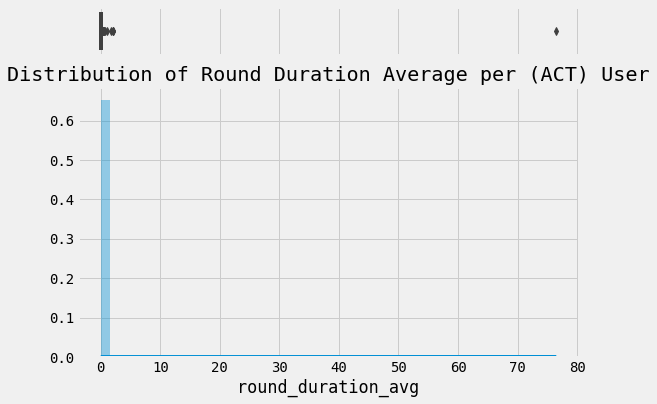

In [78]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act_users.round_duration_avg/np.timedelta64(1, 'h'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act_users.round_duration_avg/np.timedelta64(1, 'h'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (ACT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

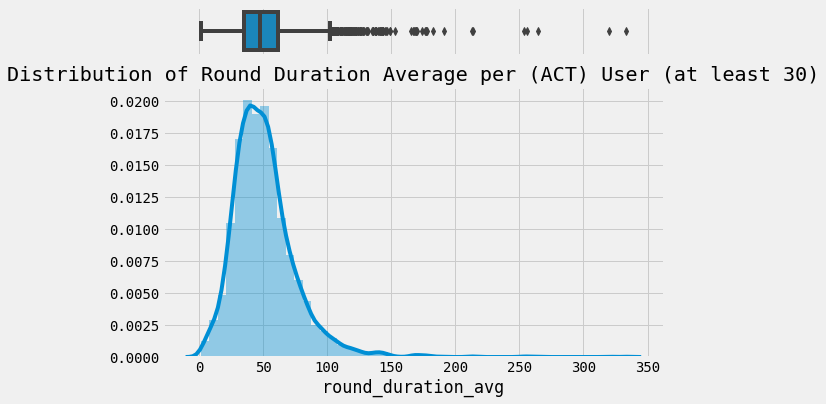

In [79]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(act_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(act_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (ACT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

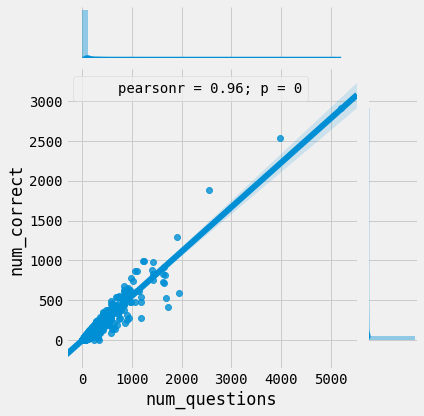

In [80]:
sns.jointplot(act_users.num_questions, act_users.num_correct, kind='reg', size=6);

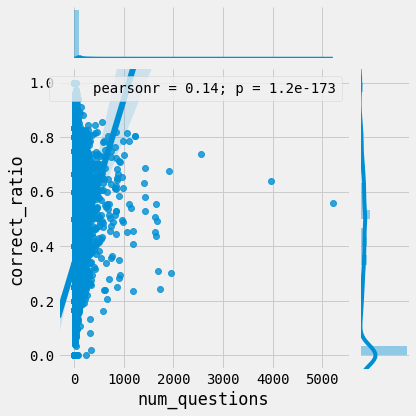

In [81]:
sns.jointplot(act_users.num_questions, act_users.correct_ratio, kind='reg', size=6)
plt.ylim(-0.05, 1.05);

The number of correct answers has an expected strong positive relationship with the number of questions attempted. However, the ratio of correct answers most definitely does not. There are obvious outliers above the 2000 question mark with scores below 80% correct.

In [82]:
act_users[act_users['num_questions'] > 2000]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
38941           1889            663           2552    0     1       0.740204   
47833           2541           1435           3976    0     1       0.639085   
132295          2911           2298           5209    0     1       0.558840   

         total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                         
38941   1 days 06:55:39    00:00:43.628134         0         0  
47833   0 days 18:16:21    00:00:16.544517         0         0  
132295  3 days 02:22:31    00:00:51.401612         0         0

The user with the most questions had the lowest score. A look at that user's statistics follows:

In [83]:
act[act.user_id == 132295][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count      5209         5209       5209        5209           5209   
unique        1         1981          1           4              4   
top      132295         4315        ACT           0              2   
freq       5209           10       5209        3111           3111   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count            5209       5209         5209  5209  5209            5209   
unique              1          6            7     2     2              10   
top                 0          7            1     0     0               0   
freq             5209       4701         3402  5095  5208            1981   

        excessive_attempts  outcome   few  many  slow_avg  fast_avg  
count                 5209     5209  5209  5209      5209      5209  
unique                   1        2     1     1         1         1  
top                      0  Correct     0     1         0         0  
freq                  5209     2911  5209  5209      5209      5209

In [84]:
act[(act.user_id == 132295) & (act.num_players == 1)].describe()

correct          round_duration  num_correct  num_incorrect  \
count  3402.000000                    3402       3402.0         3402.0   
mean      0.557907  0 days 00:00:38.325984       2911.0         2298.0   
std       0.496708  0 days 00:00:38.172573          0.0            0.0   
min       0.000000         0 days 00:00:01       2911.0         2298.0   
25%       0.000000         0 days 00:00:13       2911.0         2298.0   
50%       1.000000         0 days 00:00:25       2911.0         2298.0   
75%       1.000000         0 days 00:00:50       2911.0         2298.0   
max       1.000000         0 days 00:10:35       2911.0         2298.0   

       num_questions  correct_ratio   total_practice      round_duration_avg  
count         3402.0   3.402000e+03             3402                    3402  
mean          5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
std              0.0   5.063361e-14  0 days 00:00:00         0 days 00:00:00  
min           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
25%           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
50%           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
75%           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
max           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612

In [85]:
act[(act.user_id == 132295) & (act.num_players > 1)].describe()

correct          round_duration  num_correct  num_incorrect  \
count  1807.000000                    1807       1807.0         1807.0   
mean      0.560598  0 days 00:01:16.018815       2911.0         2298.0   
std       0.496452  0 days 00:01:00.242906          0.0            0.0   
min       0.000000         0 days 00:00:01       2911.0         2298.0   
25%       0.000000         0 days 00:00:28       2911.0         2298.0   
50%       1.000000         0 days 00:00:57       2911.0         2298.0   
75%       1.000000         0 days 00:01:54       2911.0         2298.0   
max       1.000000         0 days 00:05:42       2911.0         2298.0   

       num_questions  correct_ratio   total_practice      round_duration_avg  
count         1807.0   1.807000e+03             1807                    1807  
mean          5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
std              0.0   1.776849e-15  0 days 00:00:00         0 days 00:00:00  
min           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
25%           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
50%           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
75%           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612  
max           5209.0   5.588405e-01  3 days 02:22:31  0 days 00:00:51.401612

Practicing with other users, this user performed slightly better albeit slower than practicing alone. Nothing indicates this user or the other outliers above should be eliminated.

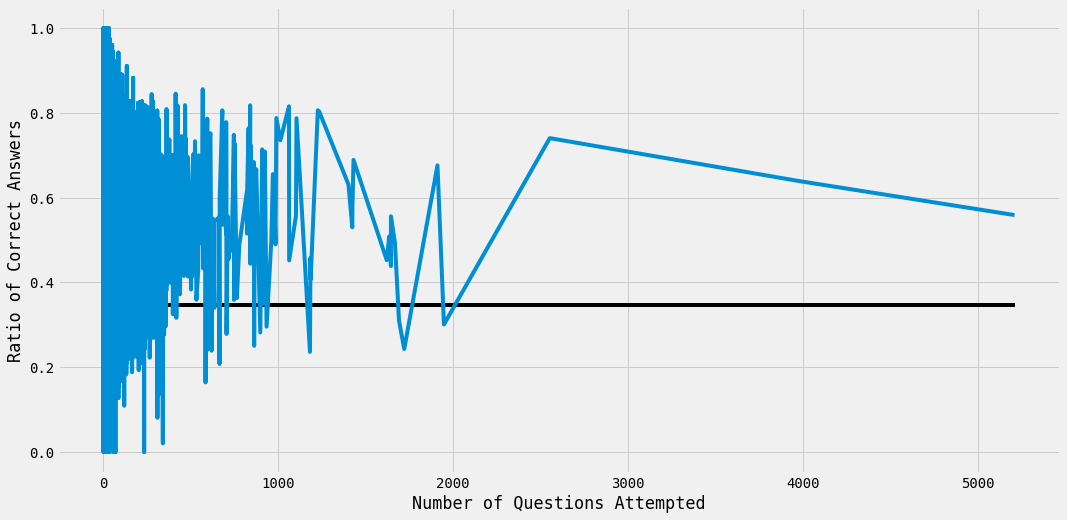

In [86]:
scores_by_num_questions = act_users.sort_values('num_questions')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean())
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers');

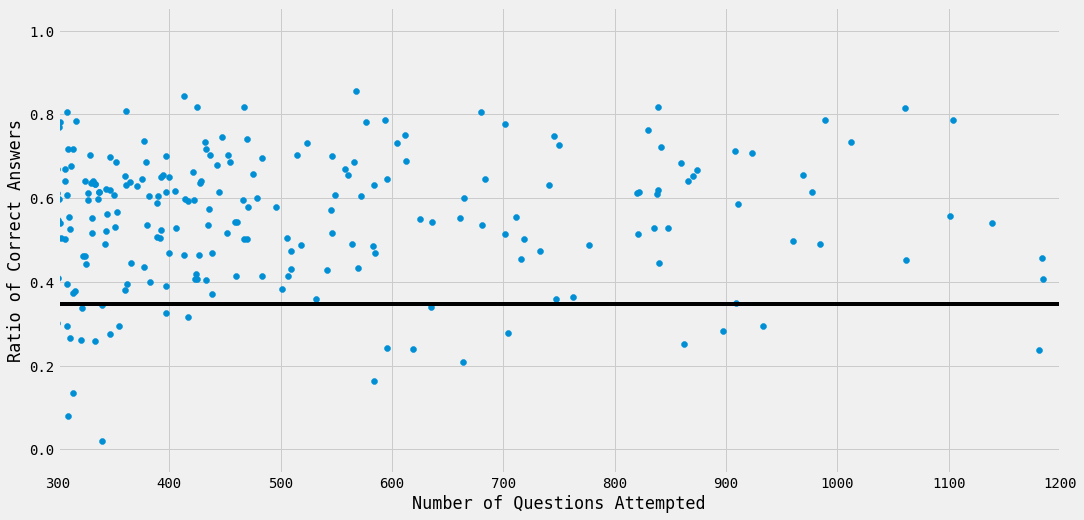

In [87]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean())
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(300, 1200);

Users attempting about 350 to about 575 questions consistently perform above the average ratio of correct answers.

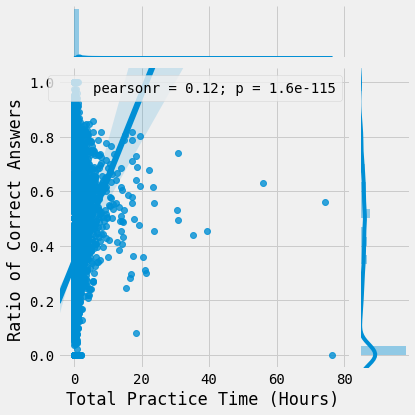

In [88]:
sns.jointplot(act_users['total_practice']/np.timedelta64(1, 'h'), act_users.correct_ratio, kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.ylim(-0.05, 1.05);

So far this looks a lot like the `num_questions` comparisons, but there is one user who spent a lot of time on the test application with no correct answers.

In [89]:
act_users[act_users['total_practice']/np.timedelta64(1, 'h') > 40]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
57389            884            517           1401    0     1       0.630978   
75348              0              1              1    1     0       0.000000   
132295          2911           2298           5209    0     1       0.558840   

         total_practice     round_duration_avg  slow_avg  fast_avg  
user_id                                                             
57389   2 days 07:49:45 0 days 00:02:23.458244         0         0  
75348   3 days 04:29:45        3 days 04:29:45         1         0  
132295  3 days 02:22:31 0 days 00:00:51.401612         0         0

In [90]:
# Inspect this user's data, but also make sure the user participated only in this group:
df[df.user_id == 75348]

user_id    round_started_at answered_at      deactivated_at  \
788661    75348 2010-01-07 18:37:22         NaT 2010-01-10 23:07:07   

            round_ended_at  correct  question_id group_name  track_name  \
788661 2010-01-10 23:07:07        0         4004        ACT           3   

        subtrack_name                 tag_string  question_type  game_type  \
788661             12  34 90 102 114 146 212 243              0          7   

        num_players  round_duration  fast  slow  num_questions  few  many  \
788661            5 3 days 04:29:45     0     1              1    1     0   

        prior_attempts  excessive_attempts    outcome  
788661               0                   0  Incorrect

In [91]:
act[act.question_id == 4004].describe()

correct          round_duration  num_correct  num_incorrect  \
count  238.000000                     238   238.000000     238.000000   
mean     0.218487  0 days 00:19:58.584033   227.722689     175.642857   
std      0.414091  0 days 04:57:27.911950   405.031768     303.572433   
min      0.000000         0 days 00:00:01     0.000000       1.000000   
25%      0.000000         0 days 00:00:12    17.250000      22.500000   
50%      0.000000         0 days 00:00:30    71.000000      78.000000   
75%      0.000000         0 days 00:00:56   242.000000     174.000000   
max      1.000000         3 days 04:29:45  2911.000000    2298.000000   

       num_questions  correct_ratio          total_practice  \
count     238.000000     238.000000                     238   
mean      403.365546       0.489929  0 days 05:57:28.495798   
std       675.311652       0.189344  0 days 10:57:28.768407   
min         1.000000       0.000000         0 days 00:00:21   
25%        43.250000       0.363636         0 days 00:24:23   
50%       164.500000       0.501043  0 days 01:46:20.500000   
75%       420.000000       0.625548  0 days 05:59:11.250000   
max      5209.000000       0.837838         3 days 04:29:45   

           round_duration_avg  
count                     238  
mean   0 days 00:20:03.232930  
std    0 days 04:57:27.567200  
min    0 days 00:00:04.477561  
25%    0 days 00:00:32.647899  
50%    0 days 00:00:44.756933  
75%    0 days 00:00:58.381395  
max           3 days 04:29:45

In [92]:
act[act.question_id == 4004][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count       238          238        238         238            238   
unique      211            1          1           1              1   
top      147414         4004        ACT           3             12   
freq          3          238        238         238            238   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count             238        238          238   238   238             238   
unique              1          4            5     2     2               3   
top                 0          7            1     0     0               0   
freq              238        203          189   206   237             211   

        excessive_attempts    outcome  few  many  slow_avg  fast_avg  
count                  238        238  238   238       238       238  
unique                   1          2    2     2         2         2  
top                      0  Incorrect    0     0         0         0  
freq                   238        186  229   236       237       237

The question the user attempted may be problematic. Users answered it correctly for little more than 20% of the attempts and the average `round_duration` for the question is almost 20 minutes. One of 238 attempts shouldn't change the score much, but a round of 3 days would certainly skew the average. It seems this user gave up and never logged out.

In [93]:
# Redefine the dataframe without the user scrutinized above:
act = df2[df2['group_name'] == 'ACT']
act = act[act.user_id != 75348]
act, act_users = user_stats(act)

In [94]:
print(len(df2.user_id.value_counts()))

# Remove this user from the full dataframe too:
df2 = df2[df2.user_id != 75348]
len(df2.user_id.value_counts())

179033


179032

In [95]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    act[column] = act[column].astype('category')

# Convert ordered categorical variables:
act['num_players'] = pd.Categorical(act['num_players'], ordered=True)
act['prior_attempts'] = pd.Categorical(act['prior_attempts'], ordered=True)

In [96]:
act[act.question_id == 4004][['correct', 'round_duration']].describe()

correct          round_duration
count  237.000000                     237
mean     0.219409  0 days 00:00:41.679324
std      0.414722  0 days 00:00:44.555223
min      0.000000         0 days 00:00:01
25%      0.000000         0 days 00:00:12
50%      0.000000         0 days 00:00:30
75%      0.000000         0 days 00:00:56
max      1.000000         0 days 00:04:00

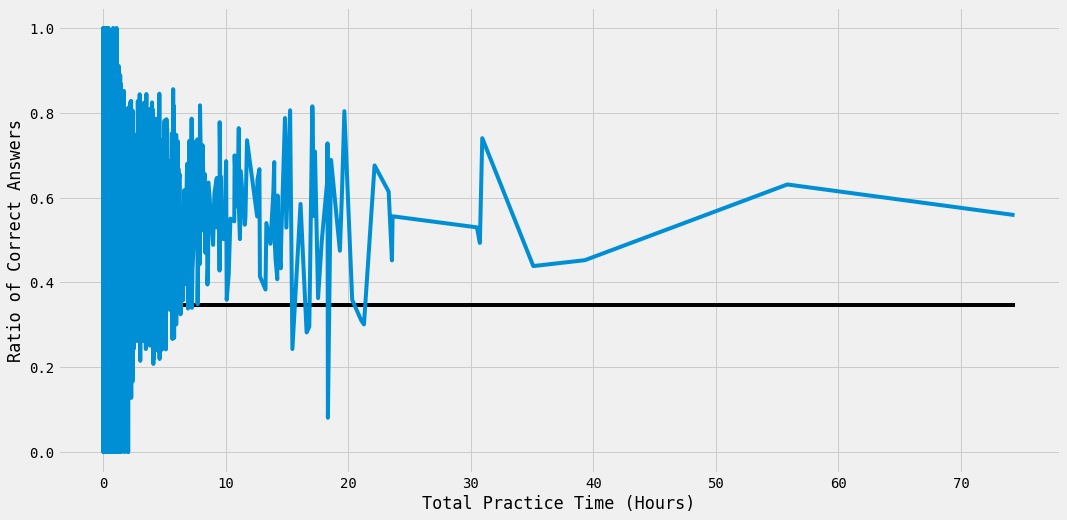

In [97]:
scores_by_total_practice = act_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers');

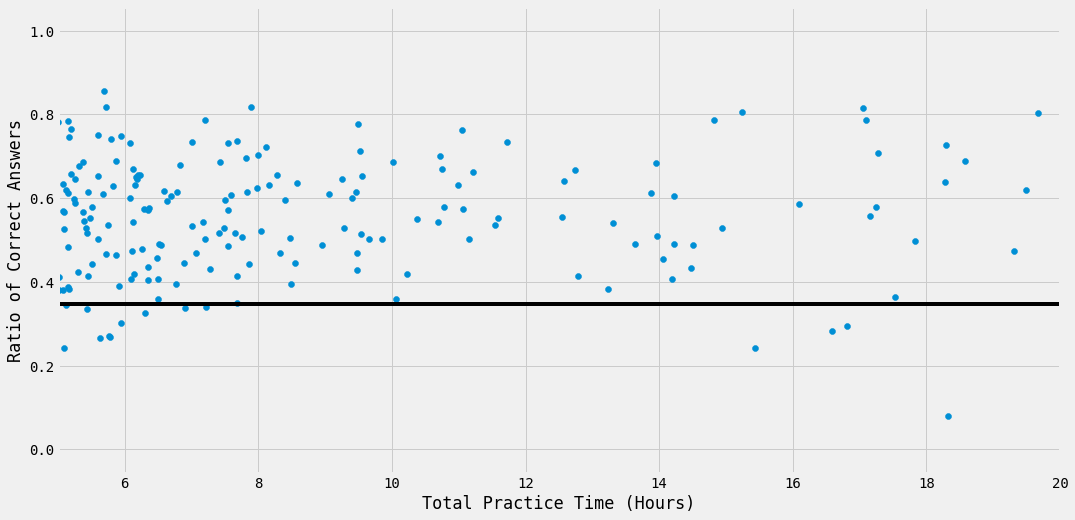

In [98]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(5, 20);

Users practicing for 6 to about 15 hours consistently perform above the average ratio of correct answers.

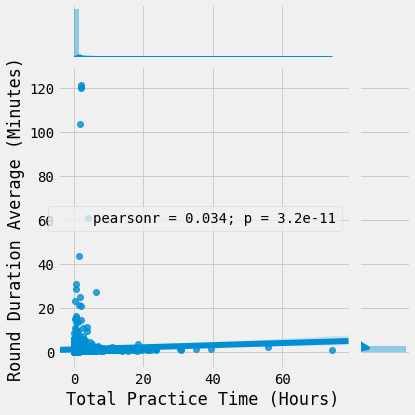

In [99]:
sns.jointplot(act_users['total_practice']/np.timedelta64(1, 'h'), act_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)');

In [100]:
act_users[act_users['round_duration_avg']/np.timedelta64(1, 'm') > 40]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
44639              0              1              1    1     0            0.0   
53471              0              1              1    1     0            0.0   
61625              2              2              4    1     0            0.5   
108137             0              2              2    1     0            0.0   
120180             0              1              1    1     0            0.0   
171707             0              1              1    1     0            0.0   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
44639         02:00:16           02:00:16         1         0  
53471         02:00:08           02:00:08         1         0  
61625         04:02:41    01:00:40.250000         1         0  
108137        01:27:14           00:43:37         1         0  
120180        01:43:32           01:43:32         1         0  
171707        02:01:23           02:01:23         1         0

The user dropped earlier was revealed to be an outlier based on `round_duration_avg`. That value was so extreme, the other abnormally high averages were missed.

In [101]:
act[act.user_id.isin(act_users[act_users['round_duration_avg']/np.timedelta64(1, 'm') > 40].index.values)]

user_id    round_started_at         answered_at      deactivated_at  \
47350   108137 2011-10-31 16:49:05 2011-10-31 18:15:00 2011-10-31 18:15:03   
47351   108137 2011-10-31 18:15:12                 NaT 2011-10-31 18:16:31   
99417    61625 2011-09-19 19:19:52                 NaT 2011-09-19 21:20:08   
99418    61625 2011-09-19 22:09:30 2011-09-19 22:11:52 2011-09-19 22:11:54   
99419    61625 2011-09-19 22:12:10 2011-09-19 22:12:13 2011-09-19 22:12:14   
99420    61625 2011-09-19 22:12:16                 NaT 2011-09-20 00:12:16   
226341   53471 2011-10-01 02:34:22                 NaT 2011-10-01 04:34:30   
316161   44639 2011-05-22 23:51:35                 NaT 2011-05-23 01:51:51   
354486  120180 2011-06-30 16:52:55                 NaT 2011-06-30 18:36:27   
583005  171707 2011-10-19 00:16:01                 NaT 2011-10-19 02:17:24   

            round_ended_at  correct question_id group_name track_name  \
47350  2011-10-31 18:15:00        0        3836        ACT          0   
47351  2011-10-31 18:16:31        0        4658        ACT          0   
99417  2011-09-19 21:20:08        0        5937        ACT          2   
99418  2011-09-19 22:11:52        1        3836        ACT          0   
99419  2011-09-19 22:12:13        1        4658        ACT          0   
99420  2011-09-20 00:12:16        0          28        ACT          0   
226341 2011-10-01 04:34:30        0        3836        ACT          0   
316161 2011-05-23 01:51:51        0        2632        ACT          3   
354486 2011-06-30 18:36:27        0        1064        ACT          0   
583005 2011-10-19 02:17:24        0        4559        ACT          1   

       subtrack_name                tag_string question_type game_type  \
47350              2              63 65 70 173             0         7   
47351              2                65 133 274             0         7   
99417             10            17 122 171 206             0         7   
99418              2              63 65 70 173             0         7   
99419              2                65 133 274             0         7   
99420              2            65 133 247 274             0         7   
226341             2              63 65 70 173             0         7   
316161            12          34 51 61 212 243             0         7   
354486             2            65 247 274 280             0         7   
583005             6  8 82 125 148 167 204 279             0        11   

       num_players round_duration fast slow prior_attempts excessive_attempts  \
47350            1       01:25:55    0    1              0                  0   
47351            1       00:01:19    0    0              0                  0   
99417            1       02:00:16    0    1              0                  0   
99418            1       00:02:22    0    0              0                  0   
99419            1       00:00:03    1    0              0                  0   
99420            1       02:00:00    0    1              0                  0   
226341           1       02:00:08    0    1              0                  0   
316161           1       02:00:16    0    1              0                  0   
354486           1       01:43:32    0    1              0                  0   
583005           1       02:01:23    0    1              0                  0   

          outcome  num_correct  num_incorrect  num_questions few many  \
47350   Incorrect            0              2              2   1    0   
47351   Incorrect            0              2              2   1    0   
99417   Incorrect            2              2              4   1    0   
99418     Correct            2              2              4   1    0   
99419     Correct            2              2              4   1    0   
99420   Incorrect            2              2              4   1    0   
226341  Incorrect            0              1              1   1    0   
316161  Incorrect            0              1        

This seems to point to a couple of problematic questions within one problematic subtrack. These users are kept since the questions they attempted could be a predictor of outcome.

---
Outliers aside, one might expect users to become more efficient and consistent with more practice. The extreme values are somewhat understood, so a narrower view of `round_duration_avg` across total practice time follows.

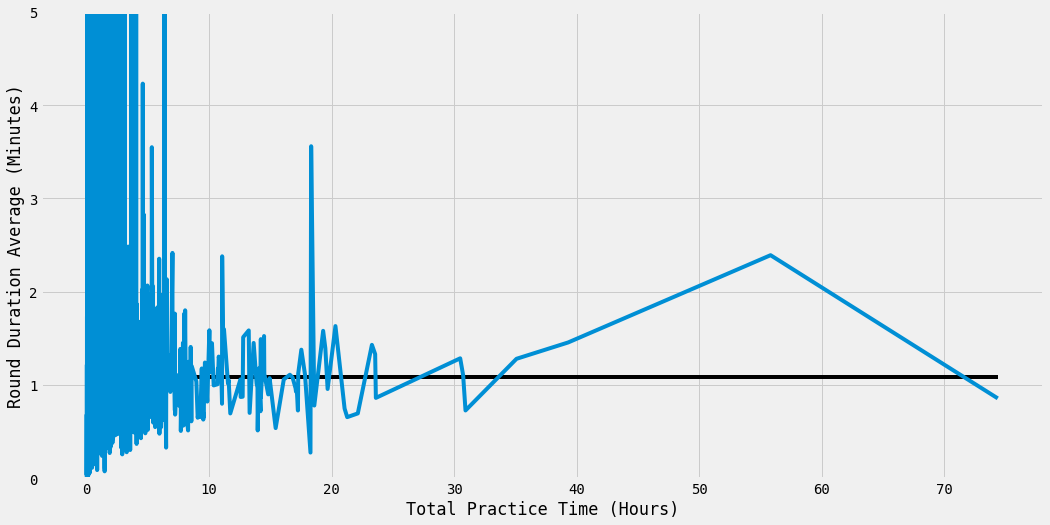

In [102]:
round_by_total_practice = act_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)')
plt.ylim(0, 5);

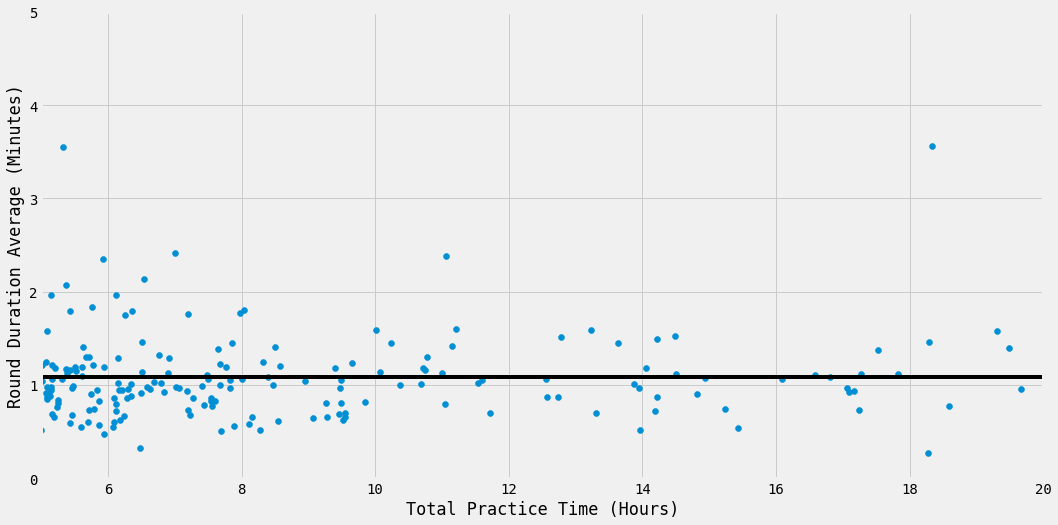

In [103]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)')
plt.xlim(5, 20), plt.ylim(0, 5);

Users practicing between 7 and 18 hours more consistently approached the average amount of time attempting a question.

## Question Data (ACT)

In [104]:
# Question statistics for users attempting a few rounds at a slow pace:
act[act.user_id.isin(act_users[(act_users.slow_avg == True) & (act_users.few == True)].index.values)][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count        39           39         39          39             39   
unique       18           30          1           4              4   
top       49102         5937        ACT           0              2   
freq          5            5         39          12             12   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count              39         39           39    39    39              39   
unique              1          3            1     2     2               2   
top                 0          7            1     0     0               0   
freq               39         33           39    38    20              38   

        excessive_attempts    outcome  few  many  slow_avg  fast_avg  
count                   39         39   39    39        39        39  
unique                   1          2    1     1         1         1  
top                      0  Incorrect    1     0         1         0  
freq                    39         29   39    39        39        39

Other than slow and few, nothing stands out much. At least one question is represented more than once in this group. The following may be some of the most difficult questions.

In [105]:
act[act.user_id.isin(act_users[(act_users.slow_avg == True) & (act_users.few == True)].index.values)].question_id.value_counts().head(5)

5937    5
3836    4
4658    2
5528    2
2791    1
Name: question_id, dtype: int64

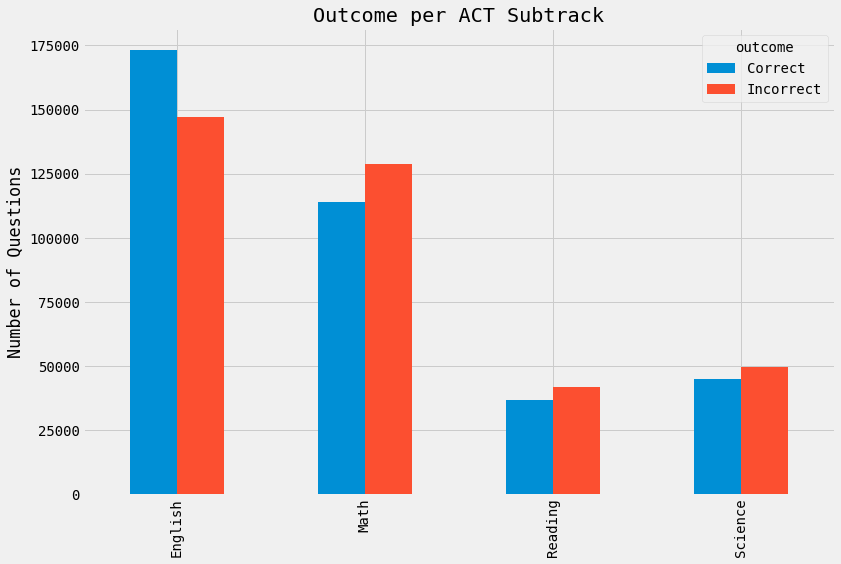

In [106]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=act.subtrack_name, columns=[act.outcome]).plot(kind='bar', figsize=(12, 8))

# Create bar labels:
subtracks = ('English', 'Math', 'Reading', 'Science')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per ACT Subtrack');

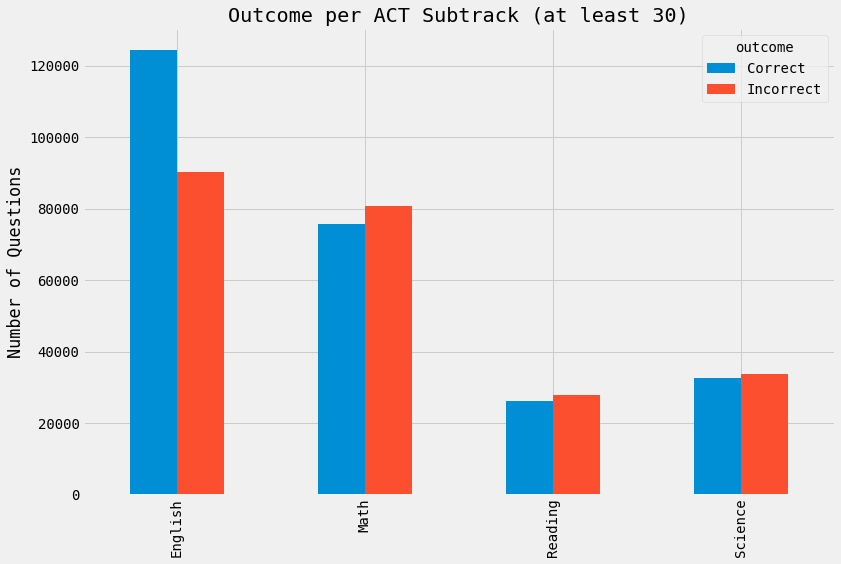

In [107]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=act_30.subtrack_name, columns=[act_30.outcome]).plot(kind='bar', figsize=(12, 8))

# Create bar labels:
subtracks = ('English', 'Math', 'Reading', 'Science')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per ACT Subtrack (at least 30)');

Outcomes are better across all subjects for users attempting at least questions.

In [108]:
# Save the clean dataframe to the interim data directory:
act.to_csv('../data/interim/clean_act.csv')

<a href='#top' id='gmat'>back to menu</a>

---
## GMAT EDA

In [109]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    gmat[column] = gmat[column].astype('category')

# Convert ordered categorical variables:
gmat['num_players'] = pd.Categorical(gmat['num_players'], ordered=True)
gmat['prior_attempts'] = pd.Categorical(gmat['prior_attempts'], ordered=True)

In [110]:
print('Group name statistics associated with excessive prior attempts:')
gmat[gmat.excessive_attempts == True].group_name.describe()

Group name statistics associated with excessive prior attempts:


count     0
unique    0
Name: group_name, dtype: int64

## All Observations (GMAT)

In [111]:
# Display statistics for numerical variables:
gmat.describe()

correct          round_duration   num_correct  num_incorrect  \
count  2.371388e+06                 2371388  2.371388e+06   2.371388e+06   
mean   5.606400e-01  0 days 00:01:18.064992  5.459370e+02   3.349056e+02   
std    4.963093e-01  0 days 00:01:57.622049  7.341407e+02   4.219883e+02   
min    0.000000e+00         0 days 00:00:01  0.000000e+00   0.000000e+00   
25%    0.000000e+00         0 days 00:00:37  2.900000e+01   2.500000e+01   
50%    1.000000e+00         0 days 00:01:06  2.660000e+02   1.900000e+02   
75%    1.000000e+00         0 days 00:01:47  7.610000e+02   4.750000e+02   
max    1.000000e+00         0 days 19:44:07  4.589000e+03   2.677000e+03   

       num_questions  correct_ratio          total_practice  \
count   2.371388e+06   2.371388e+06                 2371388   
mean    8.808426e+02   5.606400e-01  0 days 18:52:32.530209   
std     1.113559e+03   1.727462e-01  0 days 23:14:14.481460   
min     1.000000e+00   0.000000e+00         0 days 00:00:01   
25%     5.700000e+01   4.796748e-01         0 days 01:09:19   
50%     4.780000e+02   5.833333e-01         0 days 10:10:14   
75%     1.264000e+03   6.699387e-01         1 days 04:08:32   
max     6.666000e+03   1.000000e+00         5 days 05:37:33   

           round_duration_avg  
count                 2371388  
mean   0 days 00:01:18.064992  
std    0 days 00:01:00.715739  
min           0 days 00:00:01  
25%    0 days 00:01:05.200819  
50%    0 days 00:01:16.869565  
75%    0 days 00:01:28.363636  
max           0 days 19:44:07

In [112]:
# Filter columns for category datatype and display the statistics:
categorical = gmat.dtypes[gmat.dtypes == 'category'].index
gmat[categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count   2371388      2371388    2371388     2371388        2371388   
unique    78488         2203          1           2              5   
top       94877         4059       GMAT           5              9   
freq       6666        14416    2371388     1231831         717200   

        question_type  game_type  num_players     fast     slow  \
count         2371388    2371388      2371388  2371388  2371388   
unique              1         11           22        2        2   
top                 0          7            1        0        0   
freq          2371388    1163856      1622512  2322034  2368415   

        prior_attempts  excessive_attempts  outcome      few     many  \
count          2371388             2371388  2371388  2371388  2371388   
unique              47                   1        2        2        2   
top                  0                   0  Correct        0        0   
freq           2067223             2371388  1329495  2269458  2315725   

        slow_avg  fast_avg  
count    2371388   2371388  
unique         2         2  
top            0         0  
freq     2371237   2367986

## At least 30 Questions per User (GMAT)

In [113]:
# Save and inspect a dataframe of observations for the GMAT group only:
gmat2 = df2[df2['group_name'] == 'GMAT']
gmat_30 = gmat2.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
gmat_30, gmat_users_30 = user_stats(gmat_30)
gmat_30.head()

user_id    round_started_at         answered_at      deactivated_at  \
0    85818 2010-08-18 20:17:13 2010-08-18 20:18:18 2010-08-18 20:18:18   
1    85818 2010-08-18 20:19:12 2010-08-18 20:20:34 2010-08-18 20:20:34   
2    85818 2010-08-18 20:20:42 2010-08-18 20:21:56 2010-08-18 20:21:56   
3    85818 2010-08-18 20:22:03 2010-08-18 20:23:05 2010-08-18 20:23:05   
4    85818 2010-08-18 20:23:11 2010-08-18 20:26:08 2010-08-18 20:26:08   

       round_ended_at  correct  question_id group_name  track_name  \
0 2010-08-18 20:18:18        0         5560       GMAT           5   
1 2010-08-18 20:20:34        1         4681       GMAT           5   
2 2010-08-18 20:21:56        1         1529       GMAT           5   
3 2010-08-18 20:23:05        1         2908       GMAT           5   
4 2010-08-18 20:26:08        1         1773       GMAT           5   

   subtrack_name       tag_string  question_type  game_type  num_players  \
0             14  222 233 240 246              0          7            1   
1              0            24 49              0          7            1   
2              0            31 49              0          7            1   
3              0            31 49              0          7            1   
4             11      183 194 207              0          7            1   

  round_duration  fast  slow  prior_attempts  excessive_attempts    outcome  \
0       00:01:05     0     0               0                   0  Incorrect   
1       00:01:22     0     0               0                   0    Correct   
2       00:01:14     0     0               0                   0    Correct   
3       00:01:02     0     0               0                   0    Correct   
4       00:02:57     0     0               0                   0    Correct   

   num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
0          169            146            315    0     0       0.536508   
1          169            146            315    0     0       0.536508   
2          169            146            315    0     0       0.536508   
3          169            146            315    0     0       0.536508   
4          169            146            315    0     0       0.536508   

  total_practice round_duration_avg  slow_avg  fast_avg  
0       07:42:42    00:01:28.133333         0         0  
1       07:42:42    00:01:28.133333         0         0  
2       07:42:42    00:01:28.133333         0         0  
3       07:42:42    00:01:28.133333         0         0  
4       07:42:42    00:01:28.133333         0         0

In [114]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    gmat_30[column] = gmat_30[column].astype('category')

# Convert ordered categorical variables:
gmat_30['num_players'] = pd.Categorical(gmat_30['num_players'], ordered=True)
gmat_30['prior_attempts'] = pd.Categorical(gmat_30['prior_attempts'], ordered=True)

## User Data (GMAT)

In [115]:
gmat_users.head()

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
1                  6              8             14    0     0       0.428571   
3                  3              4              7    0     0       0.428571   
4                  7              4             11    0     0       0.636364   
8                  2              8             10    0     0       0.200000   
12                10             13             23    0     0       0.434783   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
1             00:21:45    00:01:33.214285         0         0  
3             00:07:52    00:01:07.428571         0         0  
4             00:07:09           00:00:39         0         0  
8             00:15:31    00:01:33.100000         0         0  
12            00:17:21    00:00:45.260869         0         0

In [116]:
# Confirm the count of users:
print( ("Number of GMAT Users: "), len(gmat.user_id.value_counts()) )

Number of GMAT Users:  78488


In [117]:
gmat_users.describe()

num_correct  num_incorrect  num_questions           few          many  \
count  78488.000000   78488.000000   78488.000000  78488.000000  78488.000000   
mean      16.938831      13.274552      30.213383      0.515174      0.000140   
std      101.342963      63.285497     160.314423      0.499773      0.011838   
min        0.000000       0.000000       1.000000      0.000000      0.000000   
25%        0.000000       1.000000       2.000000      0.000000      0.000000   
50%        2.000000       3.000000       5.000000      1.000000      0.000000   
75%        6.000000       6.000000      11.000000      1.000000      0.000000   
max     4589.000000    2677.000000    6666.000000      1.000000      1.000000   

       correct_ratio          total_practice      round_duration_avg  \
count   78488.000000                   78488                   78488   
mean        0.333503  0 days 00:39:18.607519  0 days 00:01:14.181638   
std         0.306616  0 days 03:33:31.994217  0 days 00:04:54.353373   
min         0.000000         0 days 00:00:01         0 days 00:00:01   
25%         0.000000         0 days 00:02:02  0 days 00:00:47.500000   
50%         0.333333         0 days 00:05:45  0 days 00:01:09.400000   
75%         0.571429         0 days 00:14:07  0 days 00:01:29.600000   
max         1.000000         5 days 05:37:33         0 days 19:44:07   

           slow_avg      fast_avg  
count  78488.000000  78488.000000  
mean       0.000624      0.006536  
std        0.024978      0.080582  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

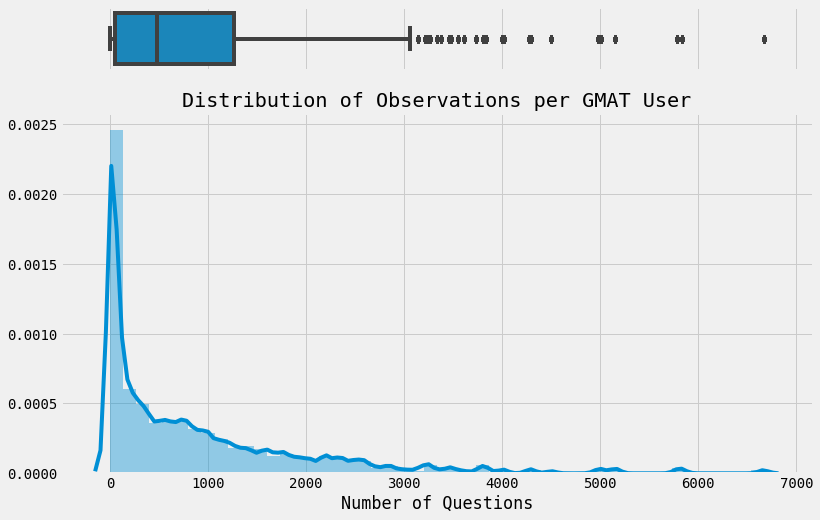

In [118]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 8))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per GMAT User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

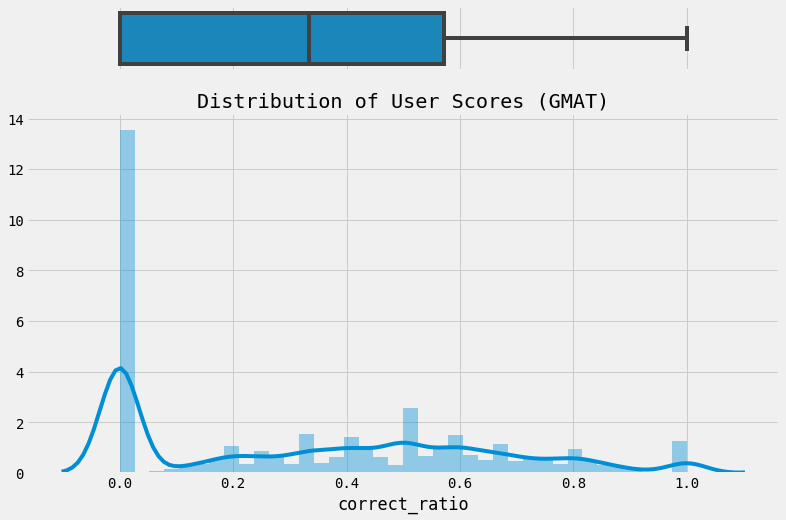

In [119]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 8))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat_users.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat_users.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (GMAT)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [120]:
# Number of users with score == 0
print(('Number of GMAT users with no correct answers:'), len(gmat_users[gmat_users.correct_ratio == 0])) 

Number of GMAT users with no correct answers: 28007


In [121]:
gmat_users[(gmat_users.correct_ratio == gmat_users.correct_ratio.min()) & (gmat_users.few == False)]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
61                 0              8              8    0     0            0.0   
69                 0              6              6    0     0            0.0   
73                 0              9              9    0     0            0.0   
156                0             12             12    0     0            0.0   
301                0              7              7    0     0            0.0   
497                0              7              7    0     0            0.0   
747                0              6              6    0     0            0.0   
839                0              6              6    0     0            0.0   
927                0              6              6    0     0            0.0   
1440               0              8              8    0     0            0.0   
1848               0              7              7    0     0            0.0   
1882               0              6              6    0     0            0.0   
1926               0              6              6    0     0            0.0   
2013               0              6              6    0     0            0.0   
2152               0              7              7    0     0            0.0   
2278               0              8              8    0     0            0.0   
2988               0              6              6    0     0            0.0   
3133               0              6              6    0     0            0.0   
3202               0             12             12    0     0            0.0   
3308               0              6              6    0     0            0.0   
3318               0              7              7    0     0            0.0   
3330               0              9              9    0     0            0.0   
3511               0              6              6    0     0            0.0   
3618               0              6              6    0     0            0.0   
4183               0              6              6    0     0            0.0   
4188               0              8              8    0     0            0.0   
4515               0              6              6    0     0            0.0   
4523               0              8              8    0     0            0.0   
5178               0              6              6    0     0            0.0   
5237               0             20             20    0     0            0.0   
...              ...            ...            ...  ...   ...            ...   
175582             0              6              6    0     0            0.0   
175863             0              7              7    0     0            0.0   
176070             0              8              8    0     0            0.0   
176077             0              9              9    0     0            0.0   
176133             0              7              7    0     0            0.0   
176246             0              8              8    0     0            0.0   
176363             0              6              6    0     0            0.0   
176634             0             12             12    0     0            0.0   
177144             0             14             14    0     0            0.0   
177288             0              8              8    0     0            0.0   
177373             0             10             10    0     0            0.0   
177408             0             10             10    0     0            0.0   
177637             0              6              6    0     0            0.0   
177852             0              6              6    0     0            0.0   
178003             0              9              9    0     0            0.0   
178007             0              7              7    0     0            0.0   
178074             0              6              6    0     0            0.0   
178079   

In [122]:
# For users with no correct answers, view the number of users attempting each num_question value:
gmat_users[gmat_users.correct_ratio == 0].num_questions.value_counts()

1     16043
2      5746
3      2381
5      1398
4      1243
6       430
7       279
8       182
9       100
10       68
11       39
12       26
13       16
14       11
15       10
16        9
19        6
20        5
17        4
22        3
21        2
37        1
23        1
18        1
26        1
29        1
32        1
Name: num_questions, dtype: int64

In [123]:
gmat_users_30.describe()

num_correct  num_incorrect  num_questions     few         many  \
count  8436.000000    8436.000000    8436.000000  8436.0  8436.000000   
mean    133.973092      93.729374     227.702466     0.0     0.001304   
std     283.009149     172.960337     441.730582     0.0     0.036089   
min       0.000000       0.000000      30.000000     0.0     0.000000   
25%      21.000000      19.000000      40.000000     0.0     0.000000   
50%      37.000000      32.000000      68.000000     0.0     0.000000   
75%     108.250000      84.000000     194.000000     0.0     0.000000   
max    4589.000000    2677.000000    6666.000000     0.0     1.000000   

       correct_ratio          total_practice      round_duration_avg  \
count    8436.000000                    8436                    8436   
mean        0.547034  0 days 05:01:31.253437  0 days 00:01:18.519090   
std         0.157309  0 days 09:48:30.773527  0 days 00:00:50.251521   
min         0.000000         0 days 00:01:00  0 days 00:00:01.301369   
25%         0.446744  0 days 00:49:39.750000  0 days 00:01:04.207589   
50%         0.552674         0 days 01:27:52  0 days 00:01:16.901373   
75%         0.655577         0 days 04:21:52  0 days 00:01:29.431277   
max         1.000000         5 days 05:37:33  0 days 01:06:45.866666   

          slow_avg     fast_avg  
count  8436.000000  8436.000000  
mean      0.000119     0.002371  
std       0.010888     0.048636  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000

In [124]:
n = len(gmat_users_30.correct_ratio)
M = np.mean(gmat_users_30.correct_ratio)
s = np.std(gmat_users_30.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

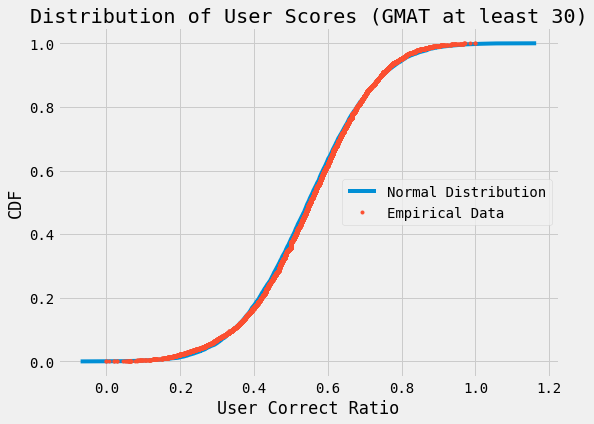

In [125]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(gmat_users_30.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='center right')
fig = plt.title('Distribution of User Scores (GMAT at least 30)');

In [126]:
gmat_users_30.head()

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
22                39             10             49    0     0       0.795918   
58                37             11             48    0     0       0.770833   
86               138             12            150    0     0       0.920000   
97              1586            763           2349    0     0       0.675181   
118                8             28             36    0     0       0.222222   

         total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                         
22      0 days 01:01:12    00:01:14.938775         0         0  
58      0 days 00:55:58    00:01:09.958333         0         0  
86      0 days 02:44:26    00:01:05.773333         0         0  
97      2 days 00:08:15    00:01:13.773946         0         0  
118     0 days 00:45:46    00:01:16.277777         0         0

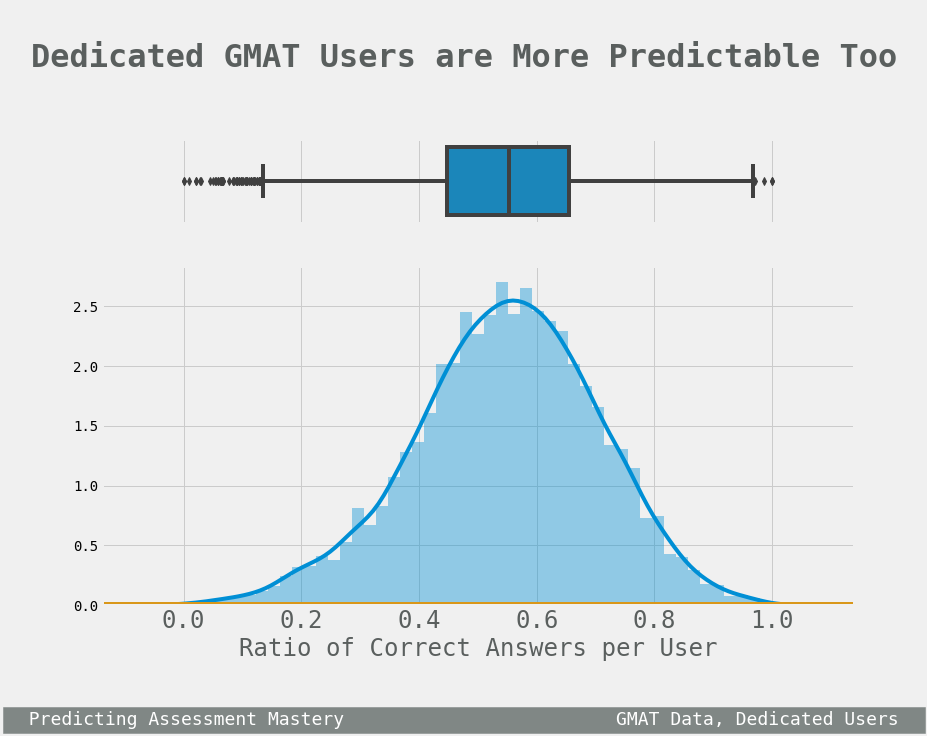

In [127]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=(12, 8))
 
# Add boxplot for correct_ratio:
user_scores30_grph = sns.boxplot(gmat_users_30.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
user_scores30_grph = sns.distplot(gmat_users_30.correct_ratio, ax=histogram)

user_scores30_grph.tick_params(axis='x', which='major', labelsize=24, colors='#5A5F5E')
user_scores30_grph.axhline(y=0, color='#D9971A', linewidth=7)

# Create axis labels and the title:
user_scores30_grph.text(x=-0.30, y=-1, 
                  s='  Predicting Assessment Mastery                         GMAT Data, Dedicated Users  ', 
                  fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.xlabel('Ratio of Correct Answers per User', fontsize=24, color='#5A5F5E')

user_scores30_grph.text(x=-0.26, y=4.5, s='\nDedicated GMAT Users are More Predictable Too', fontsize=32, weight='bold', color='#5A5F5E')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Save and display the plot:
plt.savefig('../reports/figures/gmat_scores_30.png', bbox_inches='tight');

In [128]:
# Number of users with score == 0
print(('Number of GMAT users with no correct answers:'), len(gmat_users_30[gmat_users_30.correct_ratio == 0])) 

Number of GMAT users with no correct answers: 2


In [129]:
gmat_users_30[gmat_users_30.correct_ratio == gmat_users_30.correct_ratio.min()]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
28859              0             32             32    0     0            0.0   
154426             0             37             37    0     0            0.0   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
28859         01:14:35    00:02:19.843750         0         0  
154426        00:58:54    00:01:35.513513         0         0

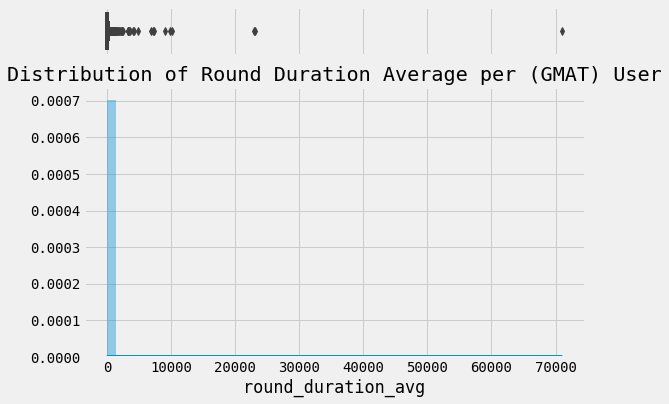

In [130]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat_users.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat_users.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (GMAT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

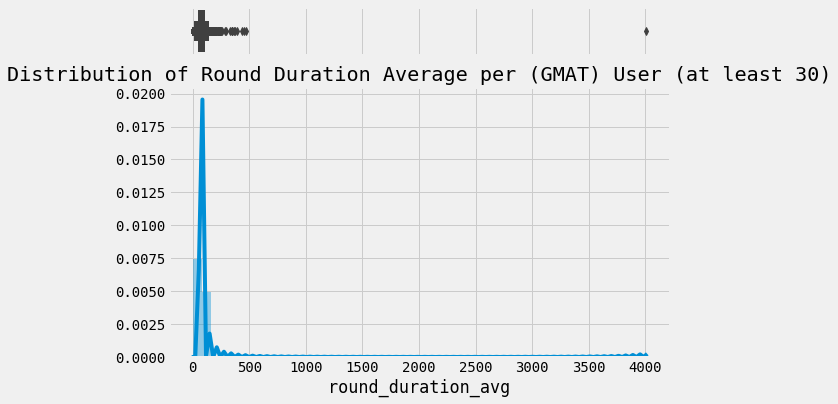

In [131]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(gmat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(gmat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (GMAT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

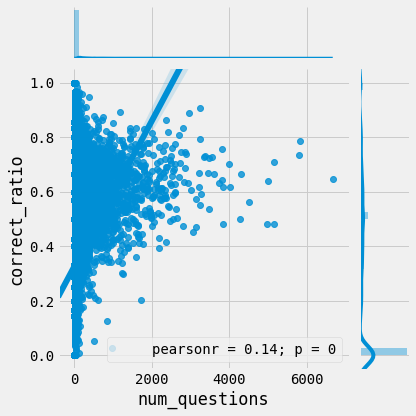

In [132]:
sns.jointplot(gmat_users.num_questions, gmat_users.correct_ratio, kind='reg', size=6)
plt.ylim(-0.05, 1.05);

In [133]:
gmat_users[gmat_users['num_questions'] > 4000]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
1914            3658           1490           5148    0     1       0.710567   
29274           2866           1433           4299    0     1       0.666667   
68653           3207           1804           5011    0     1       0.639992   
88590           2143           2134           4277    0     1       0.501052   
94877           4308           2358           6666    0     1       0.646265   
96046           4252           1534           5786    0     1       0.734877   
103056          2476           2677           5153    0     1       0.480497   
103201          2485           1530           4015    0     1       0.618929   
115950          2402           2571           4973    0     1       0.483008   
119351          4589           1247           5836    0     1       0.786326   
168669          2534           1965           4499    0     1       0.563236   

         total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                         
1914    4 days 01:25:42    00:01:08.131701         0         0  
29274   2 days 02:27:57    00:00:42.260293         0         0  
68653   3 days 21:56:47    00:01:07.492915         0         0  
88590   3 days 18:38:49    00:01:16.298573         0         0  
94877   3 days 19:48:11    00:00:49.578607         0         0  
96046   3 days 23:38:16    00:00:59.505012         0         0  
103056  3 days 16:47:05    00:01:02.026974         0         0  
103201  4 days 15:56:51    00:01:40.376338         0         0  
115950  4 days 19:08:53    00:01:23.356726         0         0  
119351  4 days 05:26:10    00:01:02.571967         0         0  
168669  4 days 10:13:03    00:01:24.992887         0         0

Other than not performing as well as a handful of users attempting 2000-4000 questions, nothing jumps out about the users attempting more than 4000 questions. Maybe a look at the least successful of these users will provide some insight.

In [134]:
gmat[gmat['user_id'] == 115950][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count      4973         4973       4973        4973           4973   
unique        1         1790          1           2              5   
top      115950         2873       GMAT           5             14   
freq       4973           12       4973        4075           2256   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count            4973       4973         4973  4973  4973            4973   
unique              1          7           11     2     1              12   
top                 0          4            1     0     0               0   
freq             4973       3473         2267  4912  4973            1790   

        excessive_attempts    outcome   few  many  slow_avg  fast_avg  
count                 4973       4973  4973  4973      4973      4973  
unique                   1          2     1     1         1         1  
top                      0  Incorrect     0     1         0         0  
freq                  4973       2571  4973  4973      4973      4973

In [135]:
gmat[(gmat['user_id'] == 115950) & (gmat.num_players == 1)].describe()

correct          round_duration  num_correct  num_incorrect  \
count  2267.000000                    2267       2267.0         2267.0   
mean      0.470666  0 days 00:01:20.460520       2402.0         2571.0   
std       0.499249  0 days 00:00:49.382520          0.0            0.0   
min       0.000000         0 days 00:00:01       2402.0         2571.0   
25%       0.000000         0 days 00:00:42       2402.0         2571.0   
50%       0.000000         0 days 00:01:14       2402.0         2571.0   
75%       1.000000         0 days 00:01:55       2402.0         2571.0   
max       1.000000         0 days 00:05:01       2402.0         2571.0   

       num_questions  correct_ratio   total_practice      round_duration_avg  
count         2267.0   2.267000e+03             2267                    2267  
mean          4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
std              0.0   9.438978e-16  0 days 00:00:00         0 days 00:00:00  
min           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
25%           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
50%           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
75%           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
max           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726

In [136]:
gmat[(gmat['user_id'] == 115950) & (gmat.num_players > 1)].describe()

correct          round_duration  num_correct  num_incorrect  \
count  2706.000000                    2706       2706.0         2706.0   
mean      0.493348  0 days 00:01:25.783074       2402.0         2571.0   
std       0.500048  0 days 00:00:49.105106          0.0            0.0   
min       0.000000         0 days 00:00:01       2402.0         2571.0   
25%       0.000000         0 days 00:00:50       2402.0         2571.0   
50%       0.000000         0 days 00:01:20       2402.0         2571.0   
75%       1.000000  0 days 00:01:54.750000       2402.0         2571.0   
max       1.000000         0 days 00:05:47       2402.0         2571.0   

       num_questions  correct_ratio   total_practice      round_duration_avg  
count         2706.0   2.706000e+03             2706                    2706  
mean          4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
std              0.0   1.610121e-14  0 days 00:00:00         0 days 00:00:00  
min           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
25%           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
50%           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
75%           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726  
max           4973.0   4.830082e-01  4 days 19:08:53  0 days 00:01:23.356726

This user performed better but slightly slower while practicing with other users rather than alone.

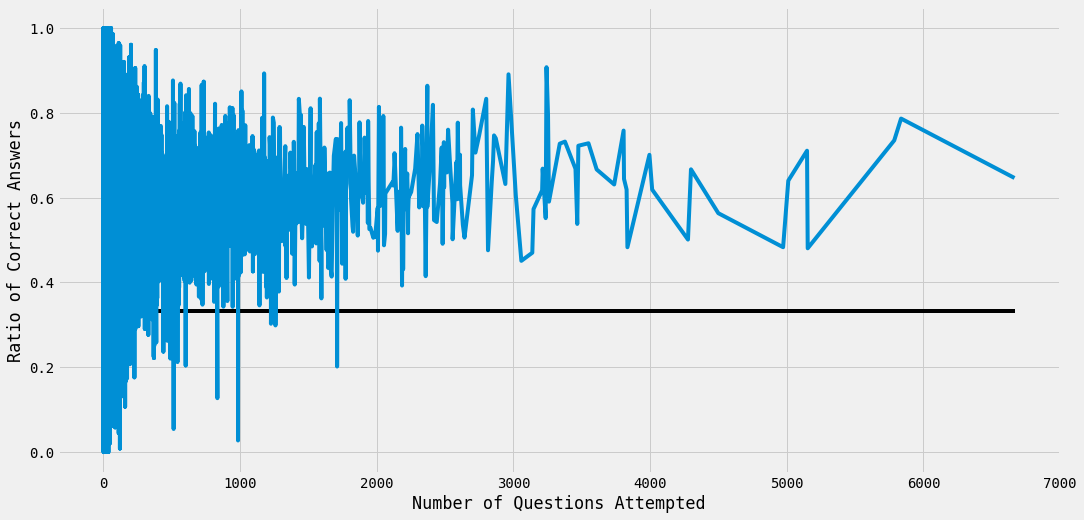

In [137]:
scores_by_num_questions = gmat_users.sort_values('num_questions')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean())
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers');

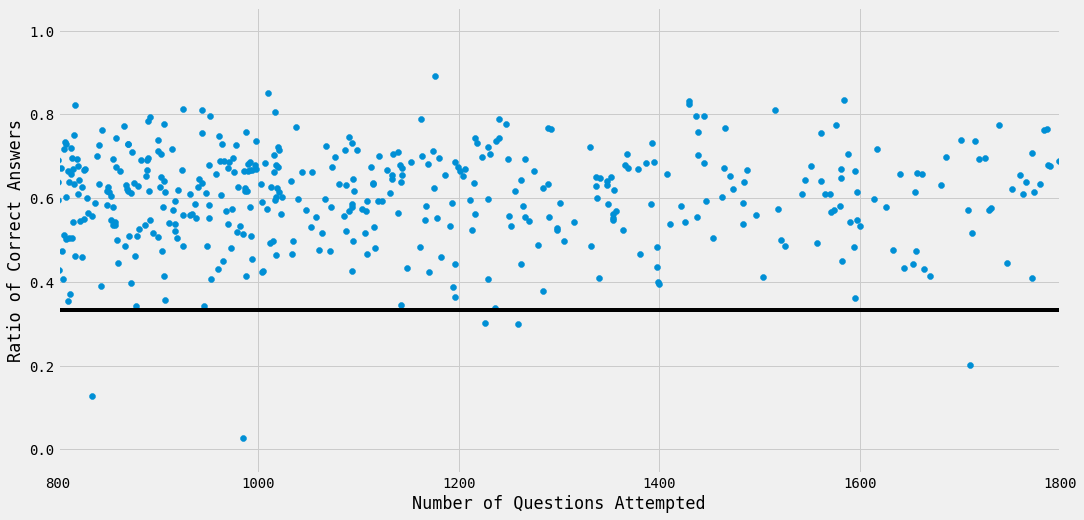

In [138]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean())
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(800, 1800);

Except for one, users attempting at least 1000 questions consistently perform near or above the average ratio of correct answers.

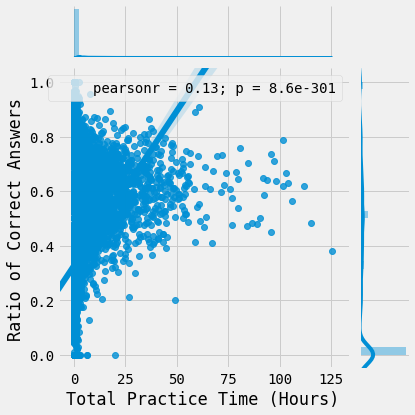

In [139]:
sns.jointplot(gmat_users['total_practice']/np.timedelta64(1, 'h'), gmat_users.correct_ratio, kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.ylim(-0.05, 1.05);

In [140]:
gmat_users[gmat_users['total_practice']/np.timedelta64(1, 'h') > 100]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
12380           2405           1204           3609    0     0       0.666390   
67095            486            798           1284    0     0       0.378505   
103201          2485           1530           4015    0     1       0.618929   
115950          2402           2571           4973    0     1       0.483008   
119351          4589           1247           5836    0     1       0.786326   
129114          2369           1459           3828    0     0       0.618861   
166331          2358           1379           3737    0     0       0.630987   
168669          2534           1965           4499    0     1       0.563236   

         total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                         
12380   4 days 06:52:05    00:01:42.611526         0         0  
67095   5 days 05:37:33    00:05:52.221962         0         0  
103201  4 days 15:56:51    00:01:40.376338         0         0  
115950  4 days 19:08:53    00:01:23.356726         0         0  
119351  4 days 05:26:10    00:01:02.571967         0         0  
129114  4 days 05:49:40    00:01:35.762800         0         0  
166331  4 days 07:50:43    00:01:40.038265         0         0  
168669  4 days 10:13:03    00:01:24.992887         0         0

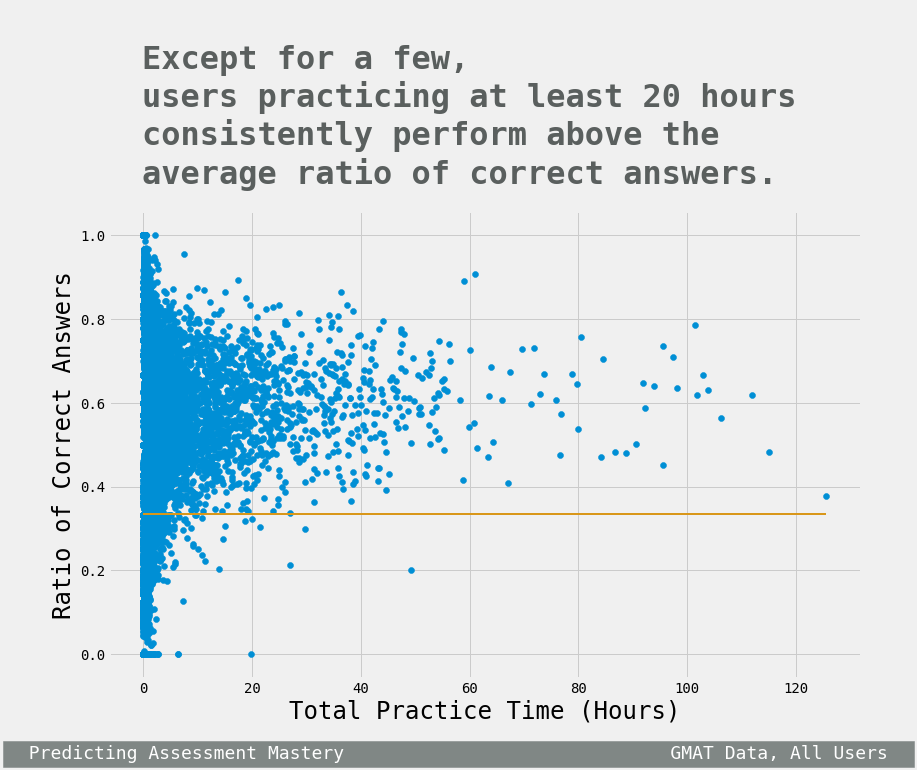

In [141]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.scatter(gmat_users.total_practice/np.timedelta64(1, 'h'), gmat_users.correct_ratio)
plt.hlines(xmin=0, xmax=(gmat_users.total_practice/np.timedelta64(1, 'h')).max(), y=gmat_users.correct_ratio.mean(), color='#D9971A', linewidth=2)
# plt.tick_params(axis='both', which='major', labelsize=24)

# Create axis labels and the title:
plt.text(x=-25, y=-0.25, 
         s='  Predicting Assessment Mastery                              GMAT Data, All Users  ', 
         fontsize=18, color='#ffffff', backgroundcolor='#808785')
plt.xlabel('Total Practice Time (Hours)', fontsize=24)
plt.ylabel('Ratio of Correct Answers', fontsize=24)

# Add a title bar with some space at the top:
plt.text(x=0, y=1.5, s=' ', fontsize=24)
plt.text(x=-0.25, y=1.125, s='Except for a few,\nusers practicing at least 20 hours\nconsistently perform above the\naverage ratio of correct answers.', fontsize=32, weight='bold', color='#5A5F5E')

# Save and display the plot:
plt.savefig('../reports/figures/practice_vs_score.png', bbox_inches='tight');

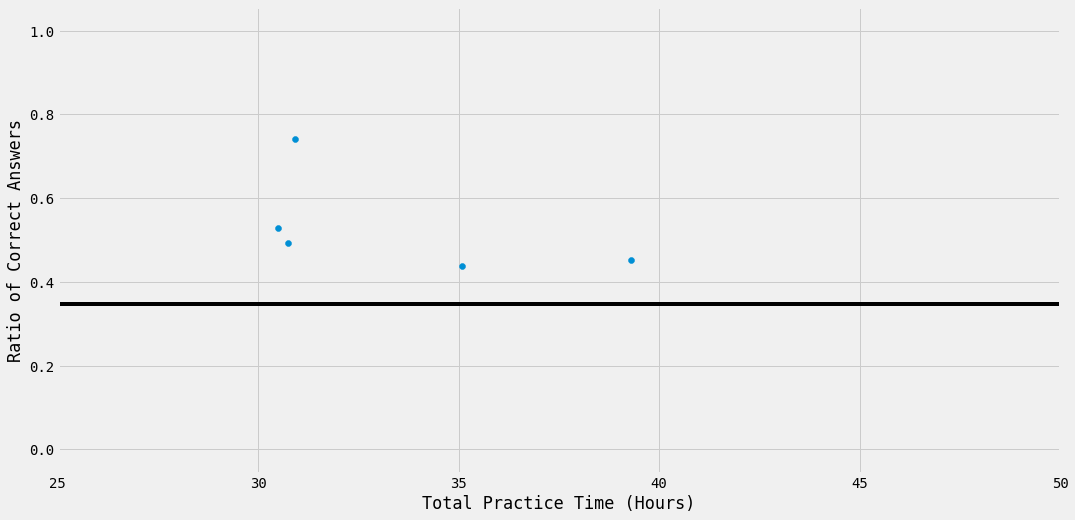

In [142]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(25, 50);

Except for one, users practicing at least 30 hours consistently perform above the average ratio of correct answers.

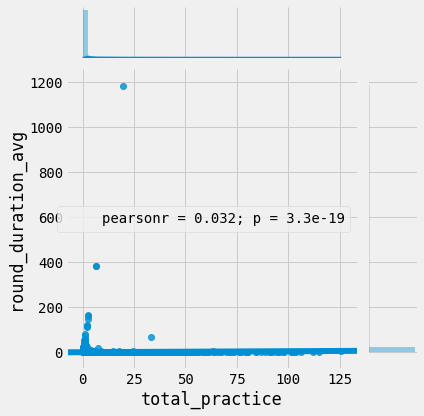

In [143]:
sns.jointplot(gmat_users['total_practice']/np.timedelta64(1, 'h'), gmat_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6);

In [144]:
gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
140745             0              1              1    1     0            0.0   
173259             0              1              1    1     0            0.0   
173399             0              1              1    1     0            0.0   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
140745        19:44:07           19:44:07         1         0  
173259        06:24:03           06:24:03         1         0  
173399        06:23:14           06:23:14         1         0

In [145]:
df[df.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200].index.values)]

user_id    round_started_at answered_at      deactivated_at  \
321518    173399 2011-05-02 06:26:41         NaT 2011-05-02 12:49:55   
2537019   140745 2010-05-05 21:21:08         NaT 2010-05-06 17:05:15   
3802301   173259 2011-05-02 06:22:20         NaT 2011-05-02 12:46:23   

             round_ended_at  correct  question_id group_name  track_name  \
321518  2011-05-02 12:49:55        0         2548       GMAT           4   
2537019 2010-05-06 17:05:15        0         2512       GMAT           5   
3802301 2011-05-02 12:46:23        0         5167       GMAT           5   

         subtrack_name       tag_string  question_type  game_type  \
321518               9     14 55 77 161              0          7   
2537019              0            28 49              0          4   
3802301             14  224 228 233 246              0          7   

         num_players round_duration  fast  slow  num_questions  few  many  \
321518             1       06:23:14     0     1              1    1     0   
2537019           31       19:44:07     0     1              1    1     0   
3802301            1       06:24:03     0     1              1    1     0   

         prior_attempts  excessive_attempts    outcome  
321518                0                   0  Incorrect  
2537019               0                   0  Incorrect  
3802301               0                   0  Incorrect

In [146]:
gmat[gmat.question_id == 2548][['correct', 'round_duration']].describe()

correct          round_duration
count  4763.000000                    4763
mean      0.843586  0 days 00:00:33.923157
std       0.363286  0 days 00:05:34.220973
min       0.000000         0 days 00:00:01
25%       1.000000         0 days 00:00:11
50%       1.000000         0 days 00:00:20
75%       1.000000         0 days 00:00:35
max       1.000000         0 days 06:23:14

In [147]:
gmat[gmat.question_id == 2548][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count      4763         4763       4763        4763           4763   
unique     4508            1          1           1              1   
top        8769         2548       GMAT           4              9   
freq          8         4763       4763        4763           4763   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count            4763       4763         4763  4763  4763            4763   
unique              1          8            7     2     2               8   
top                 0          7            1     0     0               0   
freq             4763       3621         4261  4563  4761            4508   

        excessive_attempts  outcome   few  many  slow_avg  fast_avg  
count                 4763     4763  4763  4763      4763      4763  
unique                   1        2     2     2         2         2  
top                      0  Correct     0     0         0         0  
freq                  4763     4018  4185  4734      4761      4745

In [148]:
gmat[gmat.question_id == 2512][['correct', 'round_duration']].describe()

correct          round_duration
count  2549.000000                    2549
mean      0.536289  0 days 00:01:50.213417
std       0.498779  0 days 00:23:34.683977
min       0.000000         0 days 00:00:01
25%       0.000000         0 days 00:00:48
50%       1.000000         0 days 00:01:14
75%       1.000000         0 days 00:01:45
max       1.000000         0 days 19:44:07

In [149]:
gmat[gmat.question_id == 2512][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count      2549         2549       2549        2549           2549   
unique     2183            1          1           1              1   
top      111935         2512       GMAT           5              0   
freq         10         2549       2549        2549           2549   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count            2549       2549         2549  2549  2549            2549   
unique              1          9            8     2     2              10   
top                 0          7            1     0     0               0   
freq             2549       1022         1961  2491  2543            2183   

        excessive_attempts  outcome   few  many  slow_avg  fast_avg  
count                 2549     2549  2549  2549      2549      2549  
unique                   1        2     2     2         2         2  
top                      0  Correct     0     0         0         0  
freq                  2549     1367  2413  2524      2544      2544

In [150]:
gmat[gmat.question_id == 5167][['correct', 'round_duration']].describe()

correct          round_duration
count  3923.000000                    3923
mean      0.581188  0 days 00:00:57.971705
std       0.493427  0 days 00:06:13.973291
min       0.000000         0 days 00:00:01
25%       0.000000         0 days 00:00:26
50%       1.000000         0 days 00:00:44
75%       1.000000         0 days 00:01:10
max       1.000000         0 days 06:24:03

In [151]:
gmat[gmat.question_id == 5167][categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count      3923         3923       3923        3923           3923   
unique     3786            1          1           1              1   
top      115950         5167       GMAT           5             14   
freq          5         3923       3923        3923           3923   

        question_type  game_type  num_players  fast  slow  prior_attempts  \
count            3923       3923         3923  3923  3923            3923   
unique              1          8            7     2     2               5   
top                 0          7            1     0     0               0   
freq             3923       3450         3521  3815  3921            3786   

        excessive_attempts  outcome   few  many  slow_avg  fast_avg  
count                 3923     3923  3923  3923      3923      3923  
unique                   1        2     2     2         2         2  
top                      0  Correct     0     0         0         0  
freq                  3923     2280  3132  3898      3921      3904

There's nothing to indicate the questions above are difficult or unusual. The 3 users above who never answered their one question attempt are dropped.

In [152]:
df2[df2.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200].index.values)]

user_id    round_started_at answered_at      deactivated_at  \
321518    173399 2011-05-02 06:26:41         NaT 2011-05-02 12:49:55   
2537019   140745 2010-05-05 21:21:08         NaT 2010-05-06 17:05:15   
3802301   173259 2011-05-02 06:22:20         NaT 2011-05-02 12:46:23   

             round_ended_at  correct  question_id group_name  track_name  \
321518  2011-05-02 12:49:55        0         2548       GMAT           4   
2537019 2010-05-06 17:05:15        0         2512       GMAT           5   
3802301 2011-05-02 12:46:23        0         5167       GMAT           5   

         subtrack_name       tag_string  question_type  game_type  \
321518               9     14 55 77 161              0          7   
2537019              0            28 49              0          4   
3802301             14  224 228 233 246              0          7   

         num_players round_duration  fast  slow  prior_attempts  \
321518             1       06:23:14     0     1               0   
2537019           31       19:44:07     0     1               0   
3802301            1       06:24:03     0     1               0   

         excessive_attempts    outcome  
321518                    0  Incorrect  
2537019                   0  Incorrect  
3802301                   0  Incorrect

In [153]:
print(len(df2.user_id.value_counts()))

# Remove users from the full dataframe too:
df2 = df2[~df2.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200].index.values)]
len(df2.user_id.value_counts())

179032


179029

In [154]:
gmat[gmat.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 200].index.values)]

user_id    round_started_at answered_at      deactivated_at  \
162971   173399 2011-05-02 06:26:41         NaT 2011-05-02 12:49:55   
1221939  140745 2010-05-05 21:21:08         NaT 2010-05-06 17:05:15   
1865509  173259 2011-05-02 06:22:20         NaT 2011-05-02 12:46:23   

             round_ended_at  correct question_id group_name track_name  \
162971  2011-05-02 12:49:55        0        2548       GMAT          4   
1221939 2010-05-06 17:05:15        0        2512       GMAT          5   
1865509 2011-05-02 12:46:23        0        5167       GMAT          5   

        subtrack_name       tag_string question_type game_type num_players  \
162971              9     14 55 77 161             0         7           1   
1221939             0            28 49             0         4          31   
1865509            14  224 228 233 246             0         7           1   

        round_duration fast slow prior_attempts excessive_attempts    outcome  \
162971        06:23:14    0    1              0                  0  Incorrect   
1221939       19:44:07    0    1              0                  0  Incorrect   
1865509       06:24:03    0    1              0                  0  Incorrect   

         num_correct  num_incorrect  num_questions few many  correct_ratio  \
162971             0              1              1   1    0            0.0   
1221939            0              1              1   1    0            0.0   
1865509            0              1              1   1    0            0.0   

        total_practice round_duration_avg slow_avg fast_avg  
162971        06:23:14           06:23:14        1        0  
1221939       19:44:07           19:44:07        1        0  
1865509       06:24:03           06:24:03        1        0

In [155]:
print(len(gmat.user_id.value_counts()))
gmat = df2[df2['group_name'] == 'GMAT']
gmat, gmat_users = user_stats(gmat)
len(gmat.user_id.value_counts())

78488


78485

In [156]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    gmat[column] = gmat[column].astype('category')

# Convert ordered categorical variables:
gmat['num_players'] = pd.Categorical(gmat['num_players'], ordered=True)
gmat['prior_attempts'] = pd.Categorical(gmat['prior_attempts'], ordered=True)

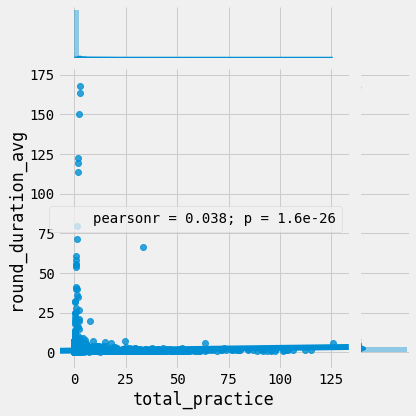

In [157]:
sns.jointplot(gmat_users['total_practice']/np.timedelta64(1, 'h'), gmat_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6);

In [158]:
gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 50]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
24563              0              1              1    1     0       0.000000   
27818              0              1              1    1     0       0.000000   
31019              0              1              1    1     0       0.000000   
50897              0              1              1    1     0       0.000000   
58616              0              1              1    1     0       0.000000   
63880              0              1              1    1     0       0.000000   
71027              0              1              1    1     0       0.000000   
87808              0              1              1    1     0       0.000000   
93901              0              1              1    1     0       0.000000   
97268              0              1              1    1     0       0.000000   
117421             0              1              1    1     0       0.000000   
124145            16             14             30    0     0       0.533333   
124845             0              1              1    1     0       0.000000   
158715             0              1              1    1     0       0.000000   

         total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                         
24563   0 days 01:59:31           01:59:31         1         0  
27818   0 days 00:55:12           00:55:12         1         0  
31019   0 days 01:00:31           01:00:31         1         0  
50897   0 days 00:55:48           00:55:48         1         0  
58616   0 days 01:19:51           01:19:51         1         0  
63880   0 days 00:58:14           00:58:14         1         0  
71027   0 days 02:02:43           02:02:43         1         0  
87808   0 days 02:48:08           02:48:08         1         0  
93901   0 days 00:53:59           00:53:59         1         0  
97268   0 days 02:30:21           02:30:21         1         0  
117421  0 days 01:11:33           01:11:33         1         0  
124145  1 days 09:22:56    01:06:45.866666         1         0  
124845  0 days 01:53:29           01:53:29         1         0  
158715  0 days 02:43:46           02:43:46         1         0

In [159]:
gmat[gmat.user_id.isin(gmat_users[gmat_users['round_duration_avg']/np.timedelta64(1, 'm') > 50].index.values)]

user_id    round_started_at         answered_at      deactivated_at  \
5570      93901 2010-06-13 19:18:56                 NaT 2010-06-13 20:12:55   
189400    63880 2010-06-11 13:30:43                 NaT 2010-06-11 14:28:57   
512756   158715 2010-06-12 07:55:43                 NaT 2010-06-12 10:39:29   
590397    87808 2010-06-13 14:26:43                 NaT 2010-06-13 17:14:51   
680504   117421 2010-04-24 15:03:57                 NaT 2010-04-24 16:15:30   
969510    97268 2010-06-13 13:59:21                 NaT 2010-06-13 16:29:42   
1315182   31019 2009-01-12 09:23:56                 NaT 2009-01-12 10:24:27   
1441482  124845 2010-06-13 07:47:15                 NaT 2010-06-13 09:40:44   
1607184   58616 2010-06-14 05:44:29                 NaT 2010-06-14 07:04:20   
1614169   24563 2010-06-13 07:55:39                 NaT 2010-06-13 09:55:10   
1663997  124145 2010-03-21 16:34:44 2010-03-21 16:35:41 2010-03-21 16:35:45   
1663998  124145 2010-03-21 17:20:44 2010-03-21 17:21:17 2010-03-21 17:21:22   
1663999  124145 2010-03-21 17:21:33 2010-03-21 19:29:53 2010-03-21 19:29:55   
1664000  124145 2010-03-21 19:29:56 2010-03-21 19:30:22 2010-03-21 19:30:25   
1664001  124145 2010-03-21 19:30:31 2010-03-21 19:30:39 2010-03-21 19:30:40   
1664002  124145 2010-03-21 19:30:42 2010-03-21 19:30:49 2010-03-21 19:30:50   
1664003  124145 2010-03-21 19:30:51 2010-03-21 19:31:02 2010-03-21 19:31:03   
1664004  124145 2010-03-21 19:31:07 2010-03-21 19:31:32 2010-03-21 19:31:33   
1664005  124145 2010-03-21 19:31:35 2010-03-21 19:31:55 2010-03-21 19:31:58   
1664006  124145 2010-03-21 19:32:06 2010-03-21 19:32:12 2010-03-21 19:32:15   
1664007  124145 2010-03-21 19:32:17 2010-03-21 19:32:29 2010-03-21 19:32:34   
1664008  124145 2010-03-21 19:32:35 2010-03-21 19:32:42 2010-03-21 19:32:45   
1664009  124145 2010-03-21 19:32:47                 NaT 2010-03-21 19:33:57   
1664010  124145 2010-04-04 17:32:13 2010-04-04 17:51:57 2010-04-04 17:52:03   
1664011  124145 2010-04-04 17:52:07                 NaT 2010-04-04 19:46:28   
1664012  124145 2010-04-10 18:23:56 2010-04-10 19:35:24 2010-04-10 19:35:28   
1664013  124145 2010-04-10 19:35:29 2010-04-10 19:36:00 2010-04-10 19:36:03   
1664014  124145 2010-04-10 19:36:06                 NaT 2010-04-10 20:32:47   
1664015  124145 2010-04-18 02:04:39 2010-04-18 02:55:15 2010-04-18 02:55:22   
1664016  124145 2010-04-18 17:56:31                 NaT 2010-04-18 19:10:52   
1664017  124145 2010-05-09 16:54:45 2010-05-09 18:10:08 2010-05-09 18:10:12   
1664018  124145 2010-05-09 18:10:32                 NaT 2010-05-09 19:39:39   
1664019  124145 2010-05-22 20:25:05                 NaT 2010-05-23 04:50:21   
1664020  124145 2010-06-13 17:06:11                 NaT 2010-06-13 20:14:53   
1664021  124145 2010-06-20 17:33:05                 NaT 2010-06-20 17:40:25   
1664022  124145 2010-06-27 14:51:39                 NaT 2010-06-27 14:52:24   
1664023  124145 2010-06-27 14:56:31                 NaT 2010-06-27 18:37:40   
1664024  124145 2010-07-11 21:31:11                 NaT 2010-07-11 23:59:08   
1664025  124145 2010-07-17 19:36:13                 NaT 2010-07-17 23:42:32   
1664026  124145 2010-07-28 03:04:19 2010-07-28 03:04:33 2010-07-28 03:04:45   
1795229   71027 2010-05-06 07:16:53                 NaT 2010-05-06 09:19:36   
1895985   50897 2009-07-15 06:59:51                 NaT 2009-07-15 07:55:39   
2201216   27818 2010-08-06 15:26:30                 NaT 2010-08-06 16:21:42   

             round_ended_at  correct question_id group_name track_name  \
5570    2010-06-13 20:12:55        0        2249       GMAT          4   
189400  2010-06-11 14:28:57        0        2249       GMAT          4   
512756  2010-06-12 10:39:29        0        2249       GMAT          4   
590397  2010-06-13 17:14:51        0        2249       GMAT          4   
680504  2010-04-24 16:15:30        0        4177       GMAT          5   
969510  2010-06-13 16:29:42        0        2249       GMAT          4   
1315182 2009-

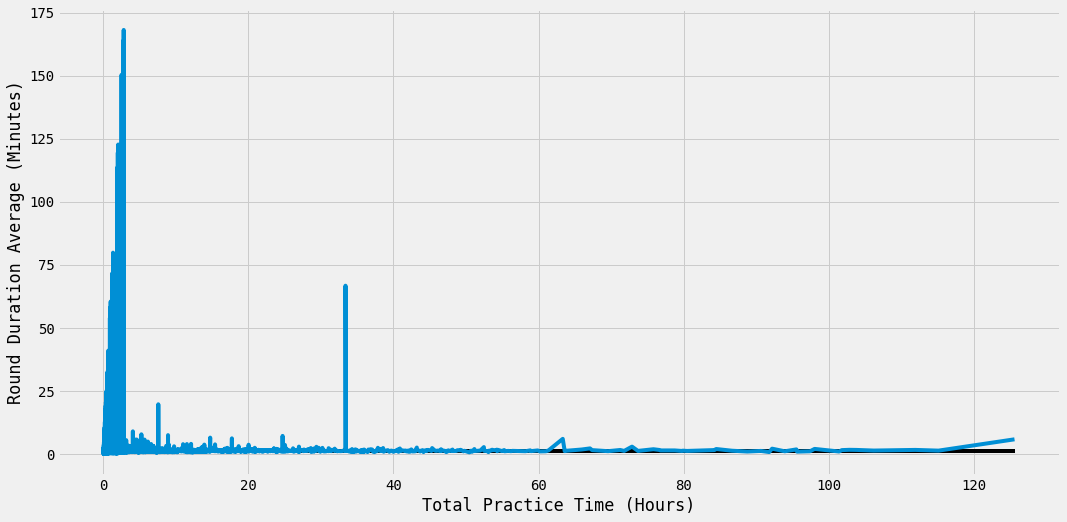

In [160]:
round_by_total_practice = gmat_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)');

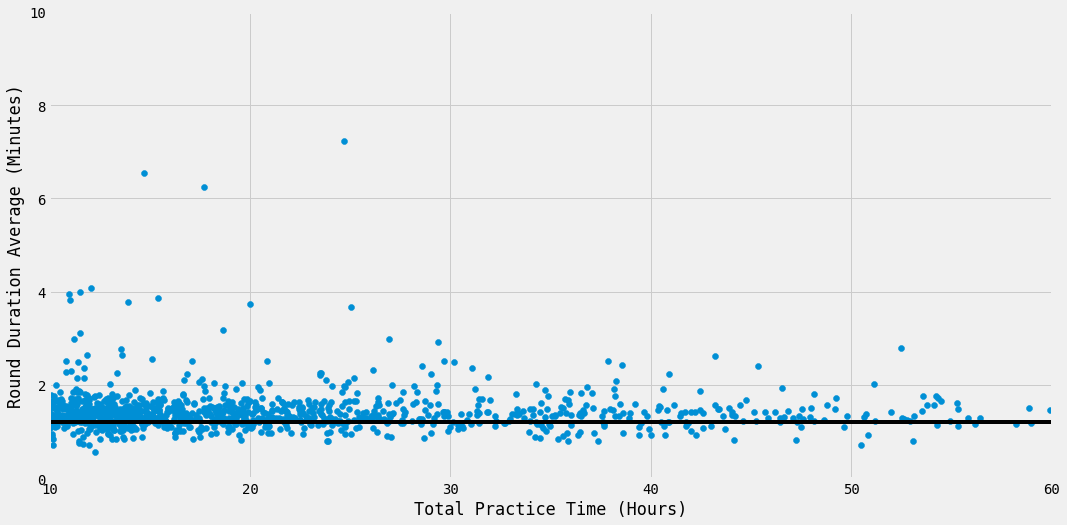

In [161]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'm')).mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Minutes)')
plt.ylim(0, 10), plt.xlim(10, 60);

In [162]:
df[df.user_id == 124145]

user_id    round_started_at         answered_at      deactivated_at  \
3392444   124145 2010-03-21 16:34:44 2010-03-21 16:35:41 2010-03-21 16:35:45   
3392445   124145 2010-03-21 17:20:44 2010-03-21 17:21:17 2010-03-21 17:21:22   
3392446   124145 2010-03-21 17:21:33 2010-03-21 19:29:53 2010-03-21 19:29:55   
3392447   124145 2010-03-21 19:29:56 2010-03-21 19:30:22 2010-03-21 19:30:25   
3392448   124145 2010-03-21 19:30:31 2010-03-21 19:30:39 2010-03-21 19:30:40   
3392449   124145 2010-03-21 19:30:42 2010-03-21 19:30:49 2010-03-21 19:30:50   
3392450   124145 2010-03-21 19:30:51 2010-03-21 19:31:02 2010-03-21 19:31:03   
3392451   124145 2010-03-21 19:31:07 2010-03-21 19:31:32 2010-03-21 19:31:33   
3392452   124145 2010-03-21 19:31:35 2010-03-21 19:31:55 2010-03-21 19:31:58   
3392453   124145 2010-03-21 19:32:06 2010-03-21 19:32:12 2010-03-21 19:32:15   
3392454   124145 2010-03-21 19:32:17 2010-03-21 19:32:29 2010-03-21 19:32:34   
3392455   124145 2010-03-21 19:32:35 2010-03-21 19:32:42 2010-03-21 19:32:45   
3392456   124145 2010-03-21 19:32:47                 NaT 2010-03-21 19:33:57   
3392457   124145 2010-04-04 17:32:13 2010-04-04 17:51:57 2010-04-04 17:52:03   
3392458   124145 2010-04-04 17:52:07                 NaT 2010-04-04 19:46:28   
3392459   124145 2010-04-10 18:23:56 2010-04-10 19:35:24 2010-04-10 19:35:28   
3392460   124145 2010-04-10 19:35:29 2010-04-10 19:36:00 2010-04-10 19:36:03   
3392461   124145 2010-04-10 19:36:06                 NaT 2010-04-10 20:32:47   
3392462   124145 2010-04-18 02:04:39 2010-04-18 02:55:15 2010-04-18 02:55:22   
3392463   124145 2010-04-18 17:56:31                 NaT 2010-04-18 19:10:52   
3392464   124145 2010-05-09 16:54:45 2010-05-09 18:10:08 2010-05-09 18:10:12   
3392465   124145 2010-05-09 18:10:32                 NaT 2010-05-09 19:39:39   
3392466   124145 2010-05-22 20:25:05                 NaT 2010-05-23 04:50:21   
3392467   124145 2010-06-13 17:06:11                 NaT 2010-06-13 20:14:53   
3392468   124145 2010-06-20 17:33:05                 NaT 2010-06-20 17:40:25   
3392469   124145 2010-06-27 14:51:39                 NaT 2010-06-27 14:52:24   
3392470   124145 2010-06-27 14:56:31                 NaT 2010-06-27 18:37:40   
3392471   124145 2010-07-11 21:31:11                 NaT 2010-07-11 23:59:08   
3392472   124145 2010-07-17 19:36:13                 NaT 2010-07-17 23:42:32   
3392473   124145 2010-07-28 03:04:19 2010-07-28 03:04:33 2010-07-28 03:04:45   

             round_ended_at  correct  question_id group_name  track_name  \
3392444 2010-03-21 16:35:41        1         1775       GMAT           4   
3392445 2010-03-21 17:21:17        1         4059       GMAT           4   
3392446 2010-03-21 19:29:53        1          358       GMAT           4   
3392447 2010-03-21 19:30:22        1         3102       GMAT           4   
3392448 2010-03-21 19:30:39        1          530       GMAT           4   
3392449 2010-03-21 19:30:49        1         5591       GMAT           4   
3392450 2010-03-21 19:31:02        1         5013       GMAT           4   
3392451 2010-03-21 19:31:32        1          121       GMAT           4   
3392452 2010-03-21 19:31:55        1         1971       GMAT           4   
3392453 2010-03-21 19:32:12        1         5383       GMAT           4   
3392454 2010-03-21 19:32:29        1         4299       GMAT           4   
3392455 2010-03-21 19:32:42        0         4401       GMAT           4   
3392456 2010-03-21 19:33:57        0         5276       GMAT           4   
3392457 2010-04-04 17:51:57        1         3537       GMAT           4   
3392458 2010-04-04 19:46:28        0         5716       GMAT           4   
3392459 2010-04-10 19:35:24        1         2330       GMAT           4   
3392460 2010-04-10 19:36:00        1         4778       GMAT           4   
3392461 2010-04-10 20:32:47        0         4967       GMAT           4   
3392462 2010-04-18 02:55:15        1            3       GMAT           4   
3392463 

Aside from slow rounds, the pattern that stands out the most is that this user never participated in a round alone. Perhaps the other user(s) can be isolated for comparison. Without the outlier, `round_duration_avg` appears to be more consistent after 25 hours of practice.

## Question Data (GMAT)

In [163]:
len(gmat[gmat.slow == 1])

2970

In [164]:
gmat[gmat.slow == 1].answered_at.isnull().sum()

969

In [165]:
gmat[gmat.slow == 1].question_id.value_counts().head(15)

2249    25
1976    23
1463    21
2065    21
3352    21
5055    19
2091    17
5162    16
2596    15
538     14
3071    13
2770    13
2702    13
4148    12
319     12
Name: question_id, dtype: int64

In [166]:
gmat[gmat.question_id.isin(gmat[gmat.slow == 1].question_id.value_counts().head(15).index.values)].slow.value_counts()

0    30321
1      255
Name: slow, dtype: int64

Nearly a fourth of slow rounds were deactivated (never answered). The 15 questions with the most counts for slow rounds still had far more rounds that were not slow. It doesn't seem as though any particular question is slowing users down.

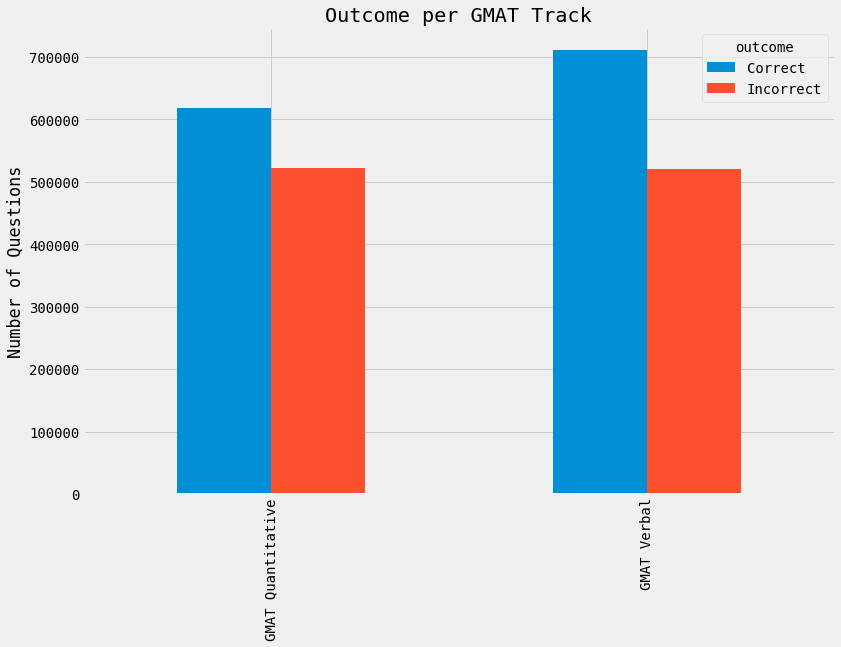

In [167]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=gmat.track_name, columns=[gmat.outcome]).plot(kind='bar', figsize=(12, 8))

# Create bar labels:
tracks = ('GMAT Quantitative', 'GMAT Verbal')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Track');

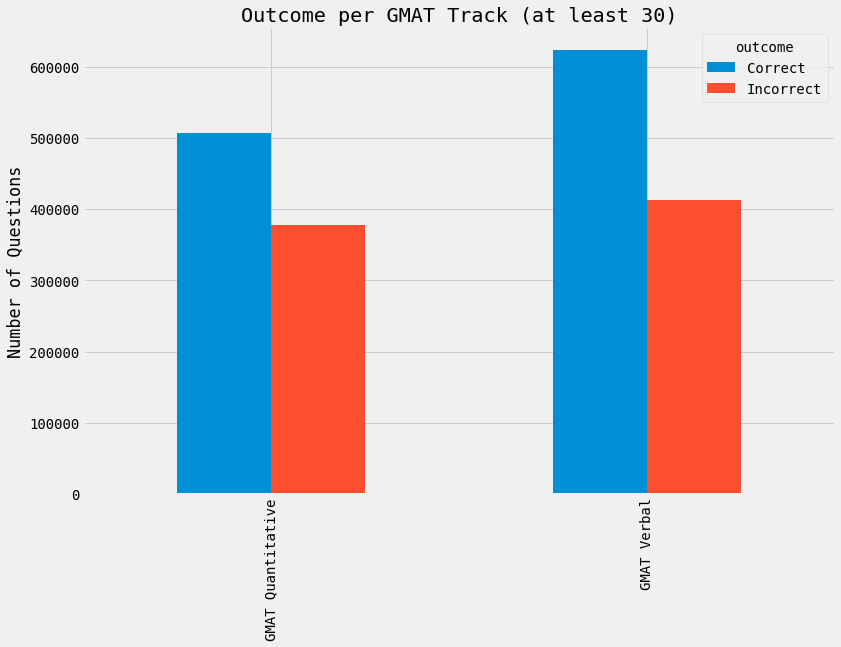

In [168]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=gmat_30.track_name, columns=[gmat_30.outcome]).plot(kind='bar', figsize=(12, 8))

# Create bar labels:
tracks = ('GMAT Quantitative', 'GMAT Verbal')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Track (at least 30)');

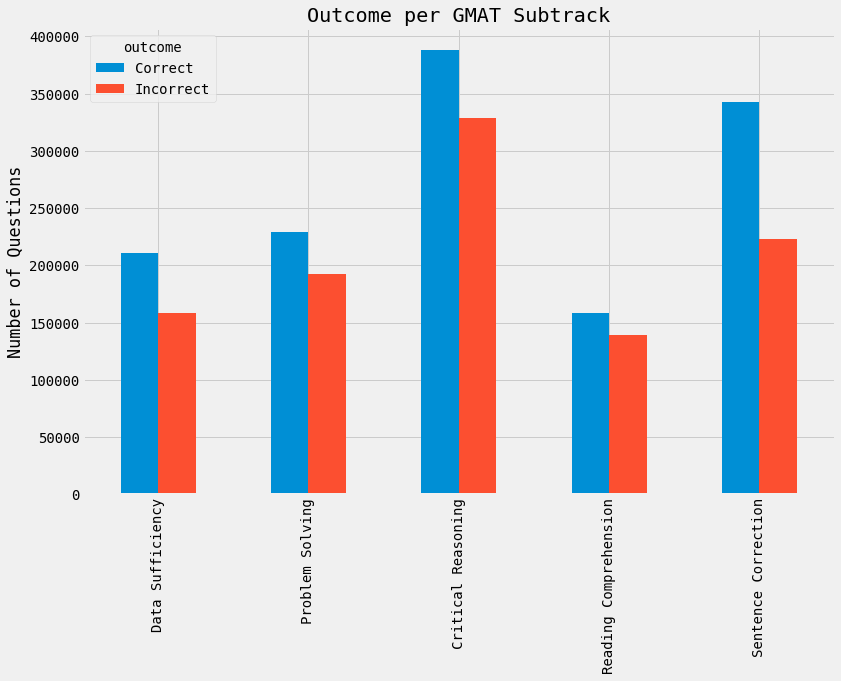

In [169]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=gmat.subtrack_name, columns=[gmat.outcome]).plot(kind='bar', figsize=(12, 8))

# Create bar labels:
subtracks = ('Data Sufficiency', 'Problem Solving', 'Critical Reasoning', 'Reading Comprehension', 'Sentence Correction')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Subtrack');

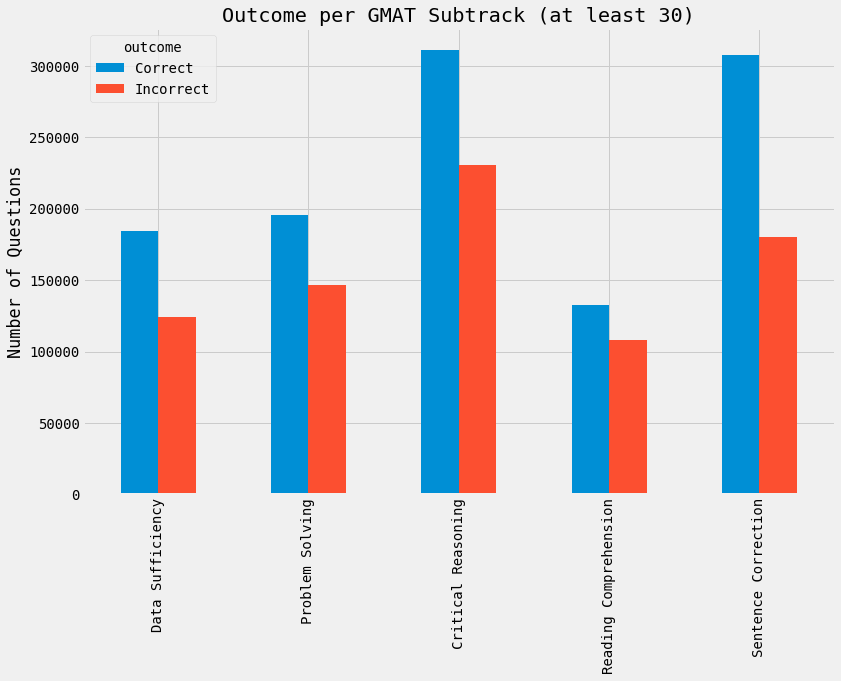

In [170]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=gmat_30.subtrack_name, columns=[gmat_30.outcome]).plot(kind='bar', figsize=(12, 8))

# Create bar labels:
subtracks = ('Data Sufficiency', 'Problem Solving', 'Critical Reasoning', 'Reading Comprehension', 'Sentence Correction')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per GMAT Subtrack (at least 30)');

In [171]:
# Save the clean dataframe to the interim data directory:
gmat.to_csv('../data/interim/clean_gmat.csv')

<a href='#top' id='sat'>back to menu</a>

---
## SAT EDA

In [172]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    sat[column] = sat[column].astype('category')

# Convert ordered categorical variables:
sat['num_players'] = pd.Categorical(sat['num_players'], ordered=True)
sat['prior_attempts'] = pd.Categorical(sat['prior_attempts'], ordered=True)

In [173]:
print('Group name statistics associated with excessive prior attempts:')
sat[sat.excessive_attempts == 1].group_name.describe()

Group name statistics associated with excessive prior attempts:


count     2874
unique       1
top        SAT
freq      2874
Name: group_name, dtype: object

In [174]:
print('Track name statistics associated with excessive prior attempts:')
sat[sat.excessive_attempts == 1].track_name.describe()

Track name statistics associated with excessive prior attempts:


count     2874
unique       2
top          6
freq      2156
Name: track_name, dtype: int64

## All Observations (SAT)

In [175]:
# Display statistics for numerical variables:
sat.describe()

correct          round_duration   num_correct  num_incorrect  \
count  1.738645e+06                 1738645  1.738645e+06   1.738645e+06   
mean   5.503107e-01  0 days 00:00:59.686644  5.530734e+02   3.413813e+02   
std    4.974625e-01  0 days 00:32:49.276878  1.059344e+03   6.528935e+02   
min    0.000000e+00         0 days 00:00:01  0.000000e+00   0.000000e+00   
25%    0.000000e+00         0 days 00:00:19  1.800000e+01   1.800000e+01   
50%    1.000000e+00         0 days 00:00:38  1.270000e+02   1.000000e+02   
75%    1.000000e+00         0 days 00:01:13  5.540000e+02   3.500000e+02   
max    1.000000e+00        28 days 03:21:38  7.800000e+03   5.328000e+03   

       num_questions  correct_ratio          total_practice  \
count   1.738645e+06   1.738645e+06                 1738645   
mean    8.944546e+02   5.503107e-01  0 days 14:14:22.752215   
std     1.569235e+03   1.896342e-01  1 days 07:53:04.110577   
min     1.000000e+00   0.000000e+00         0 days 00:00:01   
25%     3.900000e+01   4.375000e-01         0 days 00:32:58   
50%     2.350000e+02   5.654291e-01         0 days 03:32:49   
75%     9.680000e+02   6.804124e-01         0 days 13:38:06   
max     9.158000e+03   1.000000e+00        29 days 04:56:17   

           round_duration_avg  
count                 1738645  
mean   0 days 00:00:59.686644  
std    0 days 00:02:58.592790  
min           0 days 00:00:01  
25%    0 days 00:00:38.808823  
50%    0 days 00:00:54.107065  
75%    0 days 00:01:11.311111  
max    0 days 15:50:21.400000

In [176]:
# Filter columns for category datatype and display the statistics:
categorical = sat.dtypes[sat.dtypes == 'category'].index
sat[categorical].describe()

user_id  question_id group_name  track_name  subtrack_name  \
count   1738645      1738645    1738645     1738645        1738645   
unique    64834         1748          1           3              7   
top      133472         1272        SAT           6              7   
freq       9158        13584    1738645      641512         456716   

        question_type  game_type  num_players     fast     slow  \
count         1738645    1738645      1738645  1738645  1738645   
unique              2         10           28        2        2   
top                 0          7            1        0        0   
freq          1553849    1356366      1059271  1664529  1737752   

        prior_attempts  excessive_attempts  outcome      few     many  \
count          1738645             1738645  1738645  1738645  1738645   
unique            1206                   2        2        2        2   
top                  0                   0  Correct        0        0   
freq           1461688             1735771   956795  1654625  1639089   

        slow_avg  fast_avg  
count    1738645   1738645  
unique         2         2  
top            0         0  
freq     1737102   1734754

## At least 30 Questions per User (SAT)

In [177]:
# Save and inspect a dataframe of observations for the sat group only:
sat2 = df2[df2['group_name'] == 'SAT']
sat_30 = sat2.groupby('user_id').filter(lambda x: x['user_id'].count() >= 30)
sat_30, sat_users_30 = user_stats(sat_30)
sat_30.head()

user_id    round_started_at         answered_at      deactivated_at  \
0    71016 2010-11-17 01:38:48 2010-11-17 01:39:01 2010-11-17 01:39:03   
1    71016 2010-11-17 01:39:07 2010-11-17 01:39:09 2010-11-17 01:39:11   
2    71016 2010-11-17 01:39:13 2010-11-17 01:39:15 2010-11-17 01:39:16   
3    71016 2010-11-17 01:39:17 2010-11-17 01:39:19 2010-11-17 01:39:20   
4    71016 2010-11-17 01:39:21 2010-11-17 01:39:23 2010-11-17 01:39:24   

       round_ended_at  correct  question_id group_name  track_name  \
0 2010-11-17 01:39:01        0         1858        SAT           6   
1 2010-11-17 01:39:09        0         3284        SAT           6   
2 2010-11-17 01:39:15        0          948        SAT           6   
3 2010-11-17 01:39:19        0          553        SAT           6   
4 2010-11-17 01:39:23        0         2446        SAT           6   

   subtrack_name      tag_string  question_type  game_type  num_players  \
0              7    5 78 131 138              0          7            1   
1              7  5 53 80 87 131              0          7            1   
2              7  83 119 131 169              0          7            1   
3              7    5 78 131 137              0          7            1   
4              7    5 78 131 137              0          7            1   

  round_duration  fast  slow  prior_attempts  excessive_attempts    outcome  \
0       00:00:13     0     0               0                   0  Incorrect   
1       00:00:02     1     0               0                   0  Incorrect   
2       00:00:02     1     0               0                   0  Incorrect   
3       00:00:02     1     0               0                   0  Incorrect   
4       00:00:02     1     0               0                   0  Incorrect   

   num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
0            5             26             31    0     0        0.16129   
1            5             26             31    0     0        0.16129   
2            5             26             31    0     0        0.16129   
3            5             26             31    0     0        0.16129   
4            5             26             31    0     0        0.16129   

  total_practice round_duration_avg  slow_avg  fast_avg  
0       00:01:21    00:00:02.612903         0         1  
1       00:01:21    00:00:02.612903         0         1  
2       00:01:21    00:00:02.612903         0         1  
3       00:01:21    00:00:02.612903         0         1  
4       00:01:21    00:00:02.612903         0         1

In [178]:
# Create and save list of columns to convert to categorical data type:
category_columns = [
    'user_id', 'question_id', 'group_name', 'track_name', 'subtrack_name', 'question_type', 'game_type', 
    'fast', 'slow', 'excessive_attempts', 'outcome', 'few', 'many', 'slow_avg', 'fast_avg'
]

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    sat_30[column] = sat_30[column].astype('category')

# Convert ordered categorical variables:
sat_30['num_players'] = pd.Categorical(sat_30['num_players'], ordered=True)
sat_30['prior_attempts'] = pd.Categorical(sat_30['prior_attempts'], ordered=True)

## User Data (SAT)

In [179]:
sat_users.head()

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
5                 29             32             61    0     0        0.47541   
7                  0              1              1    1     0        0.00000   
10                 2              3              5    1     0        0.40000   
11                 0              2              2    1     0        0.00000   
13                 1              4              5    1     0        0.20000   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
5             00:39:57    00:00:39.295081         0         0  
7             00:00:50           00:00:50         0         0  
10            00:03:39    00:00:43.800000         0         0  
11            00:00:58           00:00:29         0         0  
13            00:02:13    00:00:26.600000         0         0

In [180]:
# Confirm the count of users:
print( ("Number of SAT Users: "), len(sat.user_id.value_counts()) )

Number of SAT Users:  64834


In [181]:
sat_users.describe()

num_correct  num_incorrect  num_questions           few          many  \
count  64834.000000   64834.000000   64834.000000  64834.000000  64834.000000   
mean      14.757612      12.059259      26.816871      0.491255      0.000262   
std       98.209657      63.564857     152.537499      0.499927      0.016191   
min        0.000000       0.000000       1.000000      0.000000      0.000000   
25%        0.000000       1.000000       2.000000      0.000000      0.000000   
50%        3.000000       3.000000       6.000000      0.000000      0.000000   
75%        7.000000       6.000000      13.000000      1.000000      0.000000   
max     7800.000000    5328.000000    9158.000000      1.000000      1.000000   

       correct_ratio          total_practice      round_duration_avg  \
count   64834.000000                   64834                   64834   
mean        0.381569  0 days 00:26:40.609032  0 days 00:01:00.199413   
std         0.313139  0 days 03:56:28.371308  0 days 00:03:50.795811   
min         0.000000         0 days 00:00:01         0 days 00:00:01   
25%         0.000000         0 days 00:01:43  0 days 00:00:30.111111   
50%         0.400000         0 days 00:04:23  0 days 00:00:48.714285   
75%         0.611111         0 days 00:11:36         0 days 00:01:14   
max         1.000000        29 days 04:56:17  0 days 15:50:21.400000   

           slow_avg      fast_avg  
count  64834.000000  64834.000000  
mean       0.000370      0.007234  
std        0.019237      0.084745  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

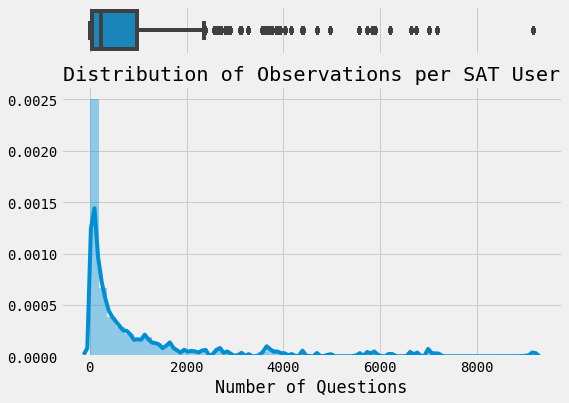

In [182]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat.num_questions, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat.num_questions, ax=histogram)

# Label axes and add title:
plt.xlabel('Number of Questions')
plt.title('Distribution of Observations per SAT User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

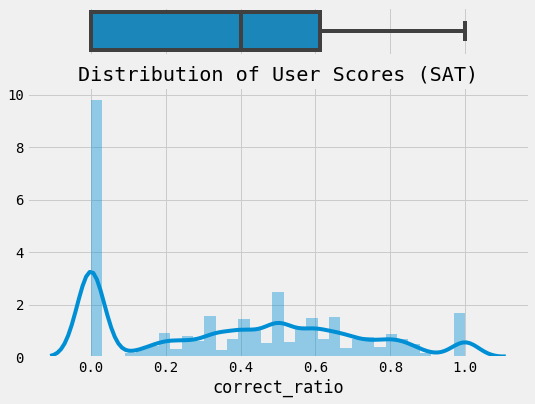

In [183]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users.correct_ratio, ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users.correct_ratio, ax=histogram)

# Label axes and add title:
plt.title('Distribution of User Scores (SAT)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

In [184]:
# Number of users with score == 0
print(('Number of SAT users with no correct answers:'), len(sat_users[sat_users.correct_ratio == 0])) 

Number of SAT users with no correct answers: 19281


In [185]:
sat_users[(sat_users.correct_ratio == sat_users.correct_ratio.min()) & (sat_users.few == False)]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
319                0              6              6    0     0            0.0   
874                0              6              6    0     0            0.0   
1163               0              8              8    0     0            0.0   
1207               0              9              9    0     0            0.0   
1299               0              6              6    0     0            0.0   
1524               0              6              6    0     0            0.0   
1724               0              7              7    0     0            0.0   
1937               0              6              6    0     0            0.0   
2157               0             10             10    0     0            0.0   
2189               0              6              6    0     0            0.0   
2254               0              6              6    0     0            0.0   
2399               0             14             14    0     0            0.0   
2445               0             10             10    0     0            0.0   
2517               0              6              6    0     0            0.0   
3085               0              6              6    0     0            0.0   
3137               0              6              6    0     0            0.0   
3506               0              6              6    0     0            0.0   
3539               0              6              6    0     0            0.0   
4154               0              6              6    0     0            0.0   
4824               0              7              7    0     0            0.0   
5048               0              7              7    0     0            0.0   
5209               0              6              6    0     0            0.0   
5262               0              7              7    0     0            0.0   
5338               0              9              9    0     0            0.0   
5384               0              6              6    0     0            0.0   
6305               0              6              6    0     0            0.0   
6391               0             13             13    0     0            0.0   
6758               0              9              9    0     0            0.0   
7723               0              8              8    0     0            0.0   
7850               0              8              8    0     0            0.0   
...              ...            ...            ...  ...   ...            ...   
173073             0              6              6    0     0            0.0   
173332             0              8              8    0     0            0.0   
173441             0              6              6    0     0            0.0   
173494             0              6              6    0     0            0.0   
173804             0              7              7    0     0            0.0   
173991             0              8              8    0     0            0.0   
174054             0              9              9    0     0            0.0   
174391             0              6              6    0     0            0.0   
174539             0              6              6    0     0            0.0   
175099             0              6              6    0     0            0.0   
175635             0              6              6    0     0            0.0   
175740             0             13             13    0     0            0.0   
175808             0              8              8    0     0            0.0   
175848             0              6              6    0     0            0.0   
175978             0              7              7    0     0            0.0   
176130             0              6              6    0     0            0.0   
176199             0              7              7    0     0            0.0   
176451   

In [186]:
# For users with no correct answers, view the number of users attempting each num_question value:
sat_users[sat_users.correct_ratio == 0].num_questions.value_counts()

1     11718
2      3637
3      1622
5       808
4       785
6       292
7       146
8        89
10       53
9        44
12       23
11       22
13       13
14        7
16        4
26        3
17        3
30        2
21        2
20        2
15        1
19        1
52        1
28        1
29        1
22        1
Name: num_questions, dtype: int64

In [187]:
sat_users_30.describe()

num_correct  num_incorrect  num_questions     few         many  \
count  7699.000000    7699.000000    7699.000000  7699.0  7699.000000   
mean    100.735680      75.611378     176.347058     0.0     0.002208   
std     269.700906     171.333421     412.683010     0.0     0.046941   
min       0.000000       0.000000      30.000000     0.0     0.000000   
25%      20.000000      20.000000      41.000000     0.0     0.000000   
50%      34.000000      33.000000      67.000000     0.0     0.000000   
75%      80.000000      69.000000     146.000000     0.0     0.000000   
max    7800.000000    5328.000000    9158.000000     0.0     1.000000   

       correct_ratio          total_practice      round_duration_avg  \
count    7699.000000                    7699                    7699   
mean        0.524551  0 days 02:57:05.468892  0 days 00:00:58.536327   
std         0.164870  0 days 10:46:54.076690  0 days 00:00:40.658923   
min         0.000000         0 days 00:01:10  0 days 00:00:01.873817   
25%         0.414634         0 days 00:35:52  0 days 00:00:39.674461   
50%         0.531250         0 days 01:04:46  0 days 00:00:54.740740   
75%         0.640825         0 days 02:23:44  0 days 00:01:12.164814   
max         1.000000        29 days 04:56:17  0 days 00:32:39.143633   

          slow_avg     fast_avg  
count  7699.000000  7699.000000  
mean      0.000390     0.003247  
std       0.019737     0.056895  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000

In [188]:
n = len(sat_users_30.correct_ratio)
M = np.mean(sat_users_30.correct_ratio)
s = np.std(sat_users_30.correct_ratio)

# Simulate a random sample with the same statistics and size of 10,000:
np.random.seed(42)
normal = np.random.normal(M, s, 10000)

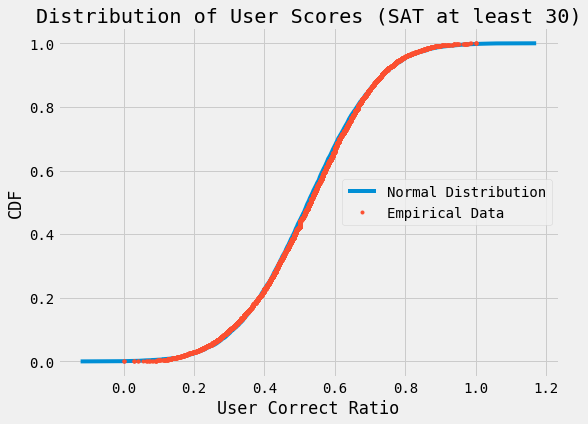

In [189]:
fig, ax = plt.subplots(figsize=(8, 6))

# Compute CDFs:
x_score, y_score = cdf(sat_users_30.correct_ratio)
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
fig = plt.plot(x_norm, y_norm)
fig = plt.plot(x_score, y_score, marker='.', linestyle='none')

# Label axes and add legend and a title:
fig = plt.xlabel('User Correct Ratio')
fig = plt.ylabel('CDF')
fig = plt.legend(('Normal Distribution', 'Empirical Data'), loc='center right')
fig = plt.title('Distribution of User Scores (SAT at least 30)');

In [190]:
# Number of users with score == 0
print(('Number of SAT users with no correct answers:'), len(sat_users_30[sat_users_30.correct_ratio == 0])) 

Number of SAT users with no correct answers: 3


In [191]:
sat_users_30[sat_users_30.correct_ratio == sat_users_30.correct_ratio.min()]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
70776              0             30             30    0     0            0.0   
77138              0             52             52    0     0            0.0   
120568             0             30             30    0     0            0.0   

        total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                        
70776         00:03:28    00:00:06.933333         0         0  
77138         00:44:36    00:00:51.461538         0         0  
120568        01:00:49    00:02:01.633333         0         0

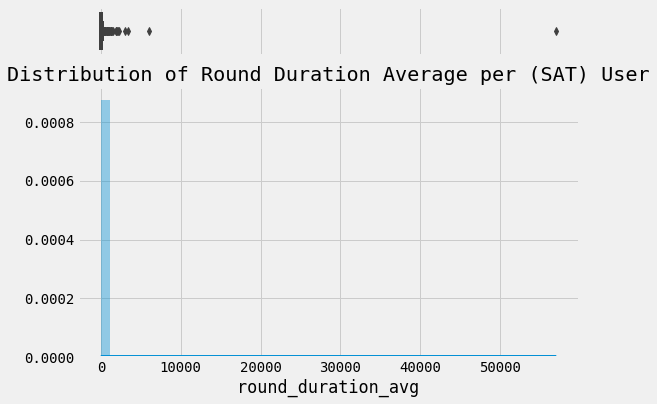

In [192]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (SAT) User')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

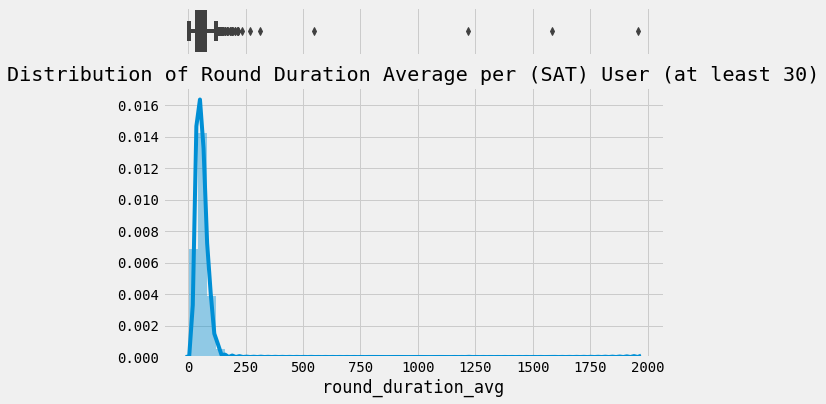

In [193]:
# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 6))
 
# Add boxplot for correct_ratio:
sns.boxplot(sat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=boxplot)

# Add histogram for correct_ratio:
sns.distplot(sat_users_30.round_duration_avg/np.timedelta64(1, 's'), ax=histogram)

# Label axes and add title:
plt.title('Distribution of Round Duration Average per (SAT) User (at least 30)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='');

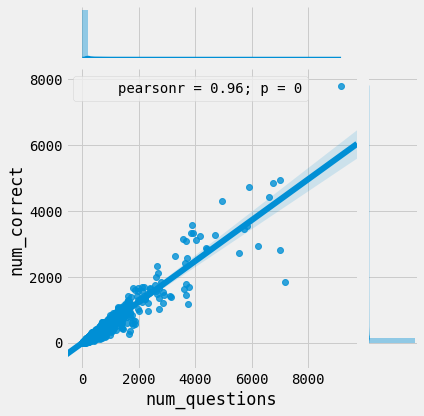

In [194]:
sns.jointplot(sat_users.num_questions, sat_users.num_correct, kind='reg', size=6);

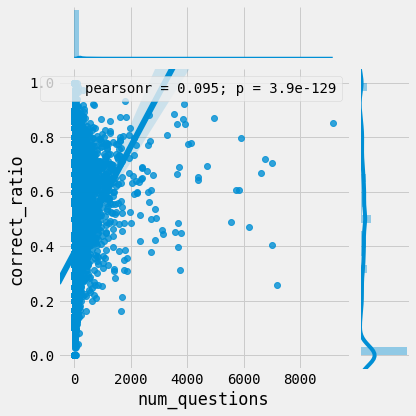

In [195]:
sns.jointplot(sat_users.num_questions, sat_users.correct_ratio, kind='reg', size=6)
plt.ylim(-0.05, 1.05);

In [196]:
sat_users[sat_users['num_questions'] > 6000]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
31228           4949           2060           7009    0     1       0.706092   
43889           4857           1889           6746    0     1       0.719982   
95423           2933           3277           6210    0     1       0.472303   
123742          4422           2201           6623    0     1       0.667673   
133472          7800           1358           9158    0     1       0.851714   
139564          1844           5328           7172    0     1       0.257111   
169858          2825           4177           7002    0     1       0.403456   

         total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                         
31228   3 days 03:55:29    00:00:38.996861         0         0  
43889   3 days 13:26:12    00:00:45.593240         0         0  
95423   7 days 06:54:58    00:01:41.400644         0         0  
123742  5 days 18:49:47    00:01:15.462328         0         0  
133472  2 days 21:17:14    00:00:27.236732         0         0  
139564  0 days 12:24:53    00:00:06.231595         0         0  
169858  7 days 03:16:24    00:01:28.058269         0         0

In [197]:
sat[sat.user_id == 139564]

user_id    round_started_at         answered_at      deactivated_at  \
78208  139564 2011-02-28 03:20:20 2011-02-28 03:20:45 2011-02-28 03:20:48   
78209  139564 2011-02-28 03:20:53 2011-02-28 03:21:10 2011-02-28 03:21:11   
78210  139564 2011-02-28 03:21:15 2011-02-28 03:21:28 2011-02-28 03:21:29   
78211  139564 2011-02-28 03:21:32 2011-02-28 03:21:44 2011-02-28 03:21:46   
78212  139564 2011-02-28 03:21:49 2011-02-28 03:22:01 2011-02-28 03:22:02   
78213  139564 2011-02-28 03:22:12                 NaT 2011-02-28 03:26:12   
78214  139564 2011-02-28 03:32:06                 NaT 2011-02-28 03:34:26   
78215  139564 2011-02-28 03:36:45 2011-02-28 03:37:29 2011-02-28 03:38:34   
78216  139564 2011-02-28 03:41:16                 NaT 2011-02-28 03:42:31   
78217  139564 2011-02-28 03:42:09 2011-02-28 03:42:37 2011-02-28 03:42:39   
78218  139564 2011-02-28 03:43:11 2011-02-28 03:44:21 2011-02-28 03:44:24   
78219  139564 2011-02-28 03:44:32 2011-02-28 03:44:46 2011-02-28 03:44:47   
78220  139564 2011-02-28 03:45:05 2011-02-28 03:45:51 2011-02-28 03:45:53   
78221  139564 2011-02-28 03:46:07 2011-02-28 03:46:17 2011-02-28 03:46:19   
78222  139564 2011-02-28 03:46:24 2011-02-28 03:46:31 2011-02-28 03:46:33   
78223  139564 2011-02-28 03:46:36 2011-02-28 03:46:49 2011-02-28 03:46:52   
78224  139564 2011-02-28 03:46:56 2011-02-28 03:47:02 2011-02-28 03:47:03   
78225  139564 2011-02-28 03:47:08 2011-02-28 03:47:20 2011-02-28 03:47:22   
78226  139564 2011-02-28 03:47:33                 NaT 2011-02-28 03:49:00   
78227  139564 2011-02-28 03:52:49                 NaT 2011-02-28 03:54:37   
78228  139564 2011-02-28 03:55:16                 NaT 2011-02-28 03:57:35   
78229  139564 2011-02-28 04:02:04 2011-02-28 04:02:12 2011-02-28 04:02:14   
78230  139564 2011-02-28 04:02:18 2011-02-28 04:02:21 2011-02-28 04:02:22   
78231  139564 2011-02-28 04:02:26 2011-02-28 04:02:29 2011-02-28 04:02:31   
78232  139564 2011-02-28 04:02:34 2011-02-28 04:02:47 2011-02-28 04:02:48   
78233  139564 2011-02-28 04:02:55 2011-02-28 04:02:57 2011-02-28 04:03:00   
78234  139564 2011-02-28 04:03:07 2011-02-28 04:03:15 2011-02-28 04:03:30   
78235  139564 2011-02-28 04:03:38 2011-02-28 04:03:56 2011-02-28 04:03:58   
78236  139564 2011-02-28 04:04:03 2011-02-28 04:04:06 2011-02-28 04:04:08   
78237  139564 2011-02-28 04:04:14 2011-02-28 04:04:16 2011-02-28 04:04:18   
...       ...                 ...                 ...                 ...   
85350  139564 2011-05-20 09:04:24 2011-05-20 09:04:25 2011-05-20 09:04:26   
85351  139564 2011-05-20 09:04:27 2011-05-20 09:04:28 2011-05-20 09:04:29   
85352  139564 2011-05-20 09:04:30 2011-05-20 09:04:33 2011-05-20 09:04:34   
85353  139564 2011-05-20 09:04:35 2011-05-20 09:04:36 2011-05-20 09:04:40   
85354  139564 2011-05-20 09:04:50 2011-05-20 09:04:51 2011-05-20 09:04:52   
85355  139564 2011-05-20 09:04:53 2011-05-20 09:04:54 2011-05-20 09:04:55   
85356  139564 2011-05-20 09:05:00 2011-05-20 09:05:02 2011-05-20 09:05:04   
85357  139564 2011-05-20 09:05:06 2011-05-20 09:05:08 2011-05-20 09:05:09   
85358  139564 2011-05-20 09:05:10 2011-05-20 09:05:11 2011-05-20 09:05:12   
85359  139564 2011-05-20 09:05:13 2011-05-20 09:05:14 2011-05-20 09:05:15   
85360  139564 2011-05-20 09:05:16 2011-05-20 09:05:19 2011-05-20 09:05:19   
85361  139564 2011-05-20 09:05:20 2011-05-20 09:05:21 2011-05-20 09:05:22   
85362  139564 2011-05-20 09:05:23 2011-05-20 09:05:24 2011-05-20 09:05:25   
85363  139564 2011-05-20 09:05:26 2011-05-20 09:05:27 2011-05-20 09:05:28   
85364  139564 2011-05-20 09:05:30 2011-05-20 09:05:32 2011-05-20 09:05:33   
85365  139564 2011-05-20 09:05:34 2011-05-20 09:05:35 2011-05-20 09:05:38   
85366  139564 2011-05-20 09:05:40 2011-05-20 09:05:42 2011-05-20 09:05:43   
85367  139564 2011-05-20 09:05:45 2011-05-20 09:05:48 2011-05-20 09:05:48   
85368  139564 2011-05-20 09:05:51 2011-05-20 09:05:53 2011-05-20 09:05:54   
85369  139564 2011-05-20 09:05:56 2011-05-20 09:05:58 2011-05-20 09:05:59   
85

In [198]:
sat[sat.excessive_attempts == 1].user_id.value_counts().head(15)

62044     1268
129150     274
3478       260
97572      212
27429      178
51964      170
134049     140
28257      132
114834      90
152666      64
26406       39
102545      32
95483       15
59636        0
59638        0
Name: user_id, dtype: int64

In [199]:
sat[(sat.user_id == 62044) & (sat.excessive_attempts == 1)].question_id.value_counts().head()

2476    1105
2212      82
1903      81
2022       0
1990       0
Name: question_id, dtype: int64

In [200]:
sat[(sat.user_id == 62044) & (sat.question_id == 2476)]

user_id    round_started_at         answered_at      deactivated_at  \
1061790   62044 2009-12-15 00:43:23 2009-12-15 00:43:58 2009-12-15 00:45:21   
1061941   62044 2009-12-24 20:58:59 2009-12-24 20:59:33 2009-12-24 20:59:33   
1061942   62044 2009-12-24 20:59:44 2009-12-24 21:00:01 2009-12-24 21:00:01   
1061943   62044 2009-12-24 21:00:09 2009-12-24 21:00:17 2009-12-24 21:00:17   
1061944   62044 2009-12-24 21:00:25 2009-12-24 21:00:34 2009-12-24 21:00:34   
1061945   62044 2009-12-24 21:00:44 2009-12-24 21:00:53 2009-12-24 21:00:53   
1061946   62044 2009-12-24 21:01:02 2009-12-24 21:01:20 2009-12-24 21:01:20   
1061947   62044 2009-12-24 21:01:39 2009-12-24 21:01:43 2009-12-24 21:01:43   
1061948   62044 2009-12-24 21:01:47 2009-12-24 21:01:50 2009-12-24 21:01:50   
1061949   62044 2009-12-24 21:01:53 2009-12-24 21:01:55 2009-12-24 21:01:55   
1061950   62044 2009-12-24 21:01:57 2009-12-24 21:02:00 2009-12-24 21:02:00   
1061951   62044 2009-12-24 21:02:03 2009-12-24 21:02:07 2009-12-24 21:02:07   
1061952   62044 2009-12-24 21:02:11 2009-12-24 21:02:13 2009-12-24 21:02:13   
1061953   62044 2009-12-24 21:02:15 2009-12-24 21:02:18 2009-12-24 21:02:18   
1061954   62044 2009-12-24 21:02:21 2009-12-24 21:02:24 2009-12-24 21:02:24   
1061955   62044 2009-12-24 21:02:27 2009-12-24 21:02:30 2009-12-24 21:02:30   
1061956   62044 2009-12-24 21:02:33 2009-12-24 21:02:36 2009-12-24 21:02:36   
1061957   62044 2009-12-24 21:02:40 2009-12-24 21:02:43 2009-12-24 21:02:43   
1061958   62044 2009-12-24 21:02:47 2009-12-24 21:02:52 2009-12-24 21:02:52   
1061959   62044 2009-12-24 21:02:57 2009-12-24 21:03:05 2009-12-24 21:03:05   
1061960   62044 2009-12-24 21:03:10 2009-12-24 21:03:28 2009-12-24 21:03:28   
1061961   62044 2009-12-24 21:03:35 2009-12-24 21:03:40 2009-12-24 21:03:40   
1061962   62044 2009-12-24 21:03:46 2009-12-24 21:03:54 2009-12-24 21:03:54   
1061963   62044 2009-12-24 21:04:00 2009-12-24 21:04:05 2009-12-24 21:04:05   
1061964   62044 2009-12-24 21:04:10 2009-12-24 21:04:15 2009-12-24 21:04:15   
1061965   62044 2009-12-24 21:04:20 2009-12-24 21:04:26 2009-12-24 21:04:26   
1061966   62044 2009-12-24 21:04:32 2009-12-24 21:04:39 2009-12-24 21:04:39   
1061967   62044 2009-12-24 21:04:44 2009-12-24 21:04:49 2009-12-24 21:04:49   
1061968   62044 2009-12-24 21:04:54 2009-12-24 21:04:59 2009-12-24 21:04:59   
1061969   62044 2009-12-24 21:05:04 2009-12-24 21:05:09 2009-12-24 21:05:09   
...         ...                 ...                 ...                 ...   
1063116   62044 2009-12-24 22:23:30 2009-12-24 22:23:31 2009-12-24 22:23:31   
1063117   62044 2009-12-24 22:23:33 2009-12-24 22:23:34 2009-12-24 22:23:34   
1063118   62044 2009-12-24 22:23:35 2009-12-24 22:23:36 2009-12-24 22:23:36   
1063119   62044 2009-12-24 22:23:37 2009-12-24 22:23:39 2009-12-24 22:23:39   
1063120   62044 2009-12-24 22:23:40 2009-12-24 22:23:41 2009-12-24 22:23:41   
1063121   62044 2009-12-24 22:23:43 2009-12-24 22:23:44 2009-12-24 22:23:44   
1063122   62044 2009-12-24 22:23:45 2009-12-24 22:23:46 2009-12-24 22:23:46   
1063123   62044 2009-12-24 22:23:47 2009-12-24 22:23:48 2009-12-24 22:23:48   
1063124   62044 2009-12-24 22:23:50 2009-12-24 22:23:51 2009-12-24 22:23:51   
1063125   62044 2009-12-24 22:23:53 2009-12-24 22:23:54 2009-12-24 22:23:54   
1063126   62044 2009-12-24 22:23:55 2009-12-24 22:23:56 2009-12-24 22:23:56   
1063127   62044 2009-12-24 22:23:57 2009-12-24 22:23:58 2009-12-24 22:23:58   
1063128   62044 2009-12-24 22:24:00 2009-12-24 22:24:01 2009-12-24 22:24:01   
1063129   62044 2009-12-24 22:24:03 2009-12-24 22:24:04 2009-12-24 22:24:04   
1063130   62044 2009-12-24 22:24:06 2009-12-24 22:24:07 2009-12-24 22:24:07   
1063131   62044 2009-12-24 22:24:08 2009-12-24 22:24:10 2009-12-24 22:24:10   
1063132   62044 2009-12-24 22:24:11 2009-12-24 22:24:12 2009-12-24 22:24:12   
1063133   62044 2009-12-24 22:24:14 2009-12-24 22:24:15 2009-12-24 22:24:15   
1063134   62044 2009-12-24 22:24:17 2009-12-24 22:24:18 20

In [201]:
# Redefine the dataframe without the user scrutinized above:
sat = df2[df2['group_name'] == 'SAT']
sat = sat[sat.user_id != 62044]
sat, sat_users = user_stats(sat)

In [202]:
print(len(df2.user_id.value_counts()))

# Remove this user from the full dataframe too:
df2 = df2[df2.user_id != 62044]
len(df2.user_id.value_counts())

179029


179028

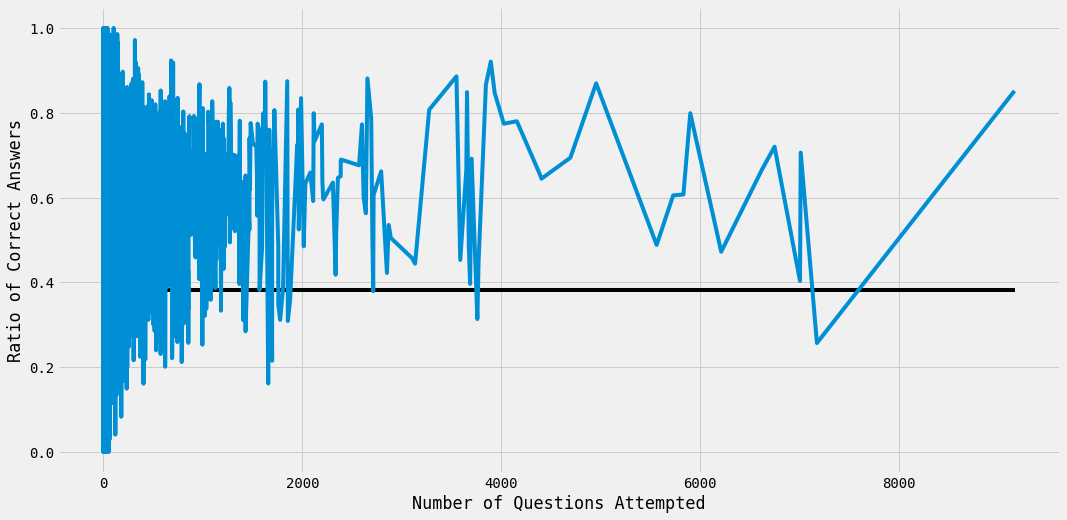

In [203]:
scores_by_num_questions = sat_users.sort_values('num_questions')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean())
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers');

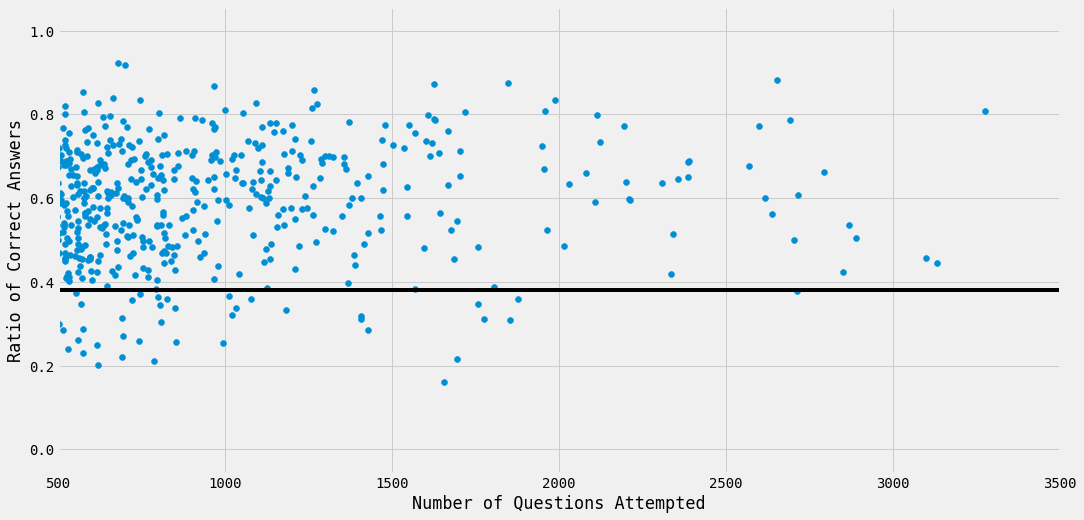

In [204]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(scores_by_num_questions.num_questions, scores_by_num_questions.correct_ratio)
plt.hlines(xmin=0, xmax=scores_by_num_questions.num_questions.max(), y=scores_by_num_questions.correct_ratio.mean())
plt.xlabel('Number of Questions Attempted')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(500, 3500);

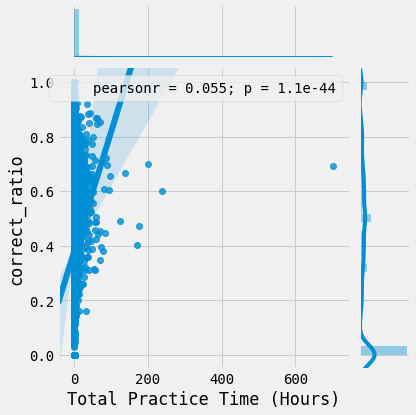

In [205]:
sns.jointplot(sat_users['total_practice']/np.timedelta64(1, 'h'), sat_users.correct_ratio, kind='reg', size=6)
plt.xlabel('Total Practice Time (Hours)')
plt.ylim(-0.05, 1.05);

In [206]:
sat_users[sat_users['total_practice']/np.timedelta64(1, 'h') > 200]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
35267              9              6             15    0     0       0.600000   
150256           893            395           1288    0     0       0.693323   

          total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                          
35267    9 days 21:35:21    15:50:21.400000         1         0  
150256  29 days 04:56:17    00:32:39.143633         1         0

In [207]:
df2[df2.user_id == 35267]

user_id    round_started_at         answered_at      deactivated_at  \
3063680    35267 2010-01-06 01:27:52 2010-01-06 01:29:31 2010-01-06 01:29:31   
3063681    35267 2010-01-06 01:29:34 2010-01-06 01:31:43 2010-01-06 01:31:43   
3063682    35267 2010-01-06 01:31:47 2010-01-06 01:32:21 2010-01-06 01:32:21   
3063683    35267 2010-01-06 01:32:24 2010-01-06 01:32:46 2010-01-06 01:32:46   
3063684    35267 2010-01-06 01:32:50 2010-01-06 01:36:16 2010-01-06 01:36:16   
3063685    35267 2010-01-06 01:36:19 2010-01-06 01:36:36 2010-01-06 01:36:36   
3063686    35267 2010-01-06 01:36:39 2010-01-06 01:37:28 2010-01-06 01:37:28   
3063687    35267 2010-01-06 01:45:50 2010-01-06 01:46:00 2010-01-06 01:46:01   
3063688    35267 2010-01-06 01:46:19 2010-01-06 01:47:12 2010-01-06 01:47:12   
3063689    35267 2010-01-06 01:47:14 2010-01-06 01:48:55 2010-01-06 01:48:55   
3063690    35267 2010-01-06 01:48:58 2010-01-06 01:50:29 2010-01-06 01:50:29   
3063691    35267 2010-01-06 01:50:32 2010-01-06 01:52:49 2010-01-06 01:52:49   
3063692    35267 2010-01-06 01:52:54 2010-01-06 01:54:55 2010-01-06 01:54:55   
3063693    35267 2010-01-06 01:54:58 2010-01-06 01:55:58 2010-01-06 01:55:58   
3063694    35267 2010-01-06 01:56:00 2010-01-06 01:58:19 2010-01-06 01:58:19   
3063695    35267 2010-01-06 01:58:21 2010-01-06 01:59:26 2010-01-06 01:59:26   
3063696    35267 2010-01-06 01:59:27 2010-01-06 02:01:56 2010-01-06 02:01:56   
3063697    35267 2010-01-06 02:01:58 2010-01-06 02:03:24 2010-01-06 02:03:24   
3063698    35267 2010-01-06 02:03:26 2010-01-06 02:04:42 2010-01-06 02:04:42   
3063699    35267 2010-01-06 02:04:43 2010-01-06 02:06:07 2010-01-06 02:06:07   
3063700    35267 2010-01-06 02:06:09 2010-01-06 02:06:55 2010-01-06 02:06:55   
3063701    35267 2010-01-06 02:06:58 2010-01-06 02:08:24 2010-01-06 02:08:24   
3063702    35267 2010-01-15 01:17:03                 NaT 2010-01-15 01:17:09   
3063703    35267 2010-01-15 20:17:46 2010-01-15 20:19:10 2010-01-15 20:19:10   
3063704    35267 2010-01-15 20:19:59                 NaT 2010-01-15 20:20:53   
3063705    35267 2010-01-15 20:32:37                 NaT 2010-01-15 20:33:46   
3063706    35267 2010-01-21 19:53:19                 NaT 2010-01-21 19:57:19   
3063707    35267 2010-01-22 19:17:30                 NaT 2010-01-22 19:20:00   
3063708    35267 2010-01-22 19:21:30 2010-01-22 19:21:37 2010-01-22 19:21:37   
3063709    35267 2010-01-22 19:21:43                 NaT 2010-01-22 19:21:46   
3063710    35267 2010-01-22 20:02:55                 NaT 2010-02-01 17:20:39   
3063711    35267 2010-01-27 23:23:34                 NaT 2010-01-27 23:23:43   
3063712    35267 2010-02-01 21:32:36                 NaT 2010-02-01 21:32:46   
3063713    35267 2010-02-02 00:12:10 2010-02-02 00:12:48 2010-02-02 00:12:51   
3063714    35267 2010-02-02 00:13:21 2010-02-02 00:14:19 2010-02-02 00:14:35   
3063715    35267 2010-02-02 00:14:44 2010-02-02 00:15:51 2010-02-02 00:15:51   
3063716    35267 2010-02-02 00:15:55 2010-02-02 00:16:31 2010-02-02 00:16:41   
3063717    35267 2010-02-02 00:16:46 2010-02-02 00:17:21 2010-02-02 00:18:40   
3063718    35267 2010-02-02 00:18:56 2010-02-02 00:19:35 2010-02-02 00:20:18   
3063719    35267 2010-02-02 00:20:28 2010-02-02 00:21:37 2010-02-02 00:22:15   
3063720    35267 2010-02-02 00:23:45 2010-02-02 00:25:52 2010-02-02 00:25:52   
3063721    35267 2010-02-02 00:25:58                 NaT 2010-02-02 00:26:33   
3063722    35267 2010-02-02 00:27:07                 NaT 2010-02-02 00:29:37   
3063723    35267 2010-02-02 00:31:07                 NaT 2010-02-02 00:32:07   
3063724    35267 2010-02-08 20:46:04 2010-02-08 20:46:11 2010-02-08 20:46:11   
3063725    35267 2010-02-08 20:46:14 2010-02-08 20:46:15 2010-02-08 20:46:16   
3063726    35267 2010-02-08 20:46:17 2010-02-08 20:46:19 2010-02-08 20:46:19   
3063727    35267 2010-02-08 20:46:21 2010-02-08 20:46:22 2010-02-08 20:46:22   
3063728    35267 2010-02-08 20:46:24 2010-02-08 20:46:25 2010-02-08 20:46:25   
3063729  

It looks like this user never logged out of the SAT game one evening. That dramatically increases the `round_duration_avg`, but shouldn't be a problem.

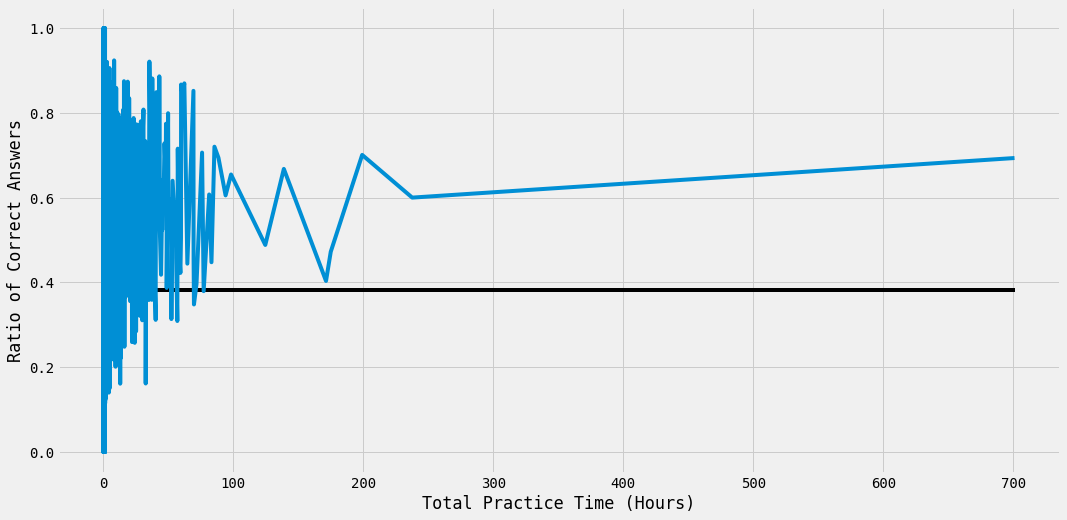

In [208]:
scores_by_total_practice = sat_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers');

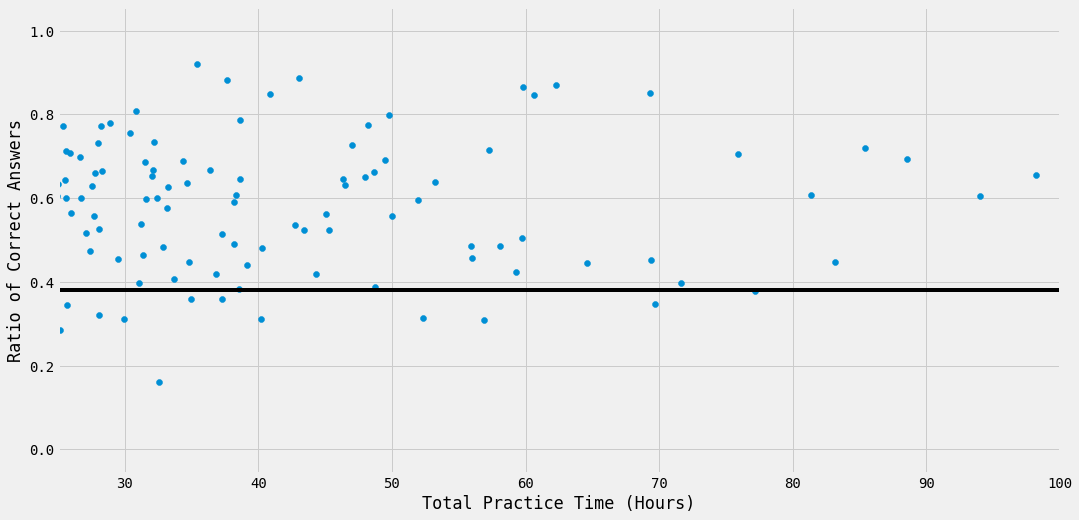

In [209]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(scores_by_total_practice.total_practice/np.timedelta64(1, 'h'), scores_by_total_practice.correct_ratio)
plt.hlines(xmin=0, xmax=(scores_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=scores_by_total_practice.correct_ratio.mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Ratio of Correct Answers')
plt.xlim(25, 100);

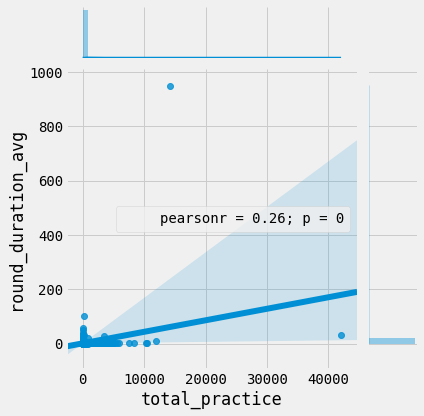

In [210]:
sns.jointplot(sat_users['total_practice']/np.timedelta64(1, 'm'), sat_users.round_duration_avg/np.timedelta64(1, 'm'), kind='reg', size=6);

In [211]:
sat_users[sat_users['total_practice']/np.timedelta64(1, 'm') > 10000]

num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
user_id                                                                        
35267              9              6             15    0     0       0.600000   
95423           2933           3277           6210    0     1       0.472303   
109230           920            393           1313    0     0       0.700685   
150256           893            395           1288    0     0       0.693323   
169858          2825           4177           7002    0     1       0.403456   

          total_practice round_duration_avg  slow_avg  fast_avg  
user_id                                                          
35267    9 days 21:35:21    15:50:21.400000         1         0  
95423    7 days 06:54:58    00:01:41.400644         0         0  
109230   8 days 07:05:42    00:09:05.881188         0         0  
150256  29 days 04:56:17    00:32:39.143633         1         0  
169858   7 days 03:16:24    00:01:28.058269         0         0

In [212]:
df2[df2.user_id == 150256]

user_id    round_started_at         answered_at      deactivated_at  \
3512486   150256 2009-11-25 16:55:10 2009-11-25 16:55:34 2009-11-25 16:55:34   
3512487   150256 2009-11-25 16:55:42 2009-11-25 16:55:54 2009-11-25 16:55:54   
3512488   150256 2009-11-25 16:55:59 2009-11-25 16:56:45 2009-11-25 16:56:45   
3512489   150256 2009-11-25 16:56:51 2009-11-25 16:58:47 2009-11-25 16:58:47   
3512490   150256 2009-11-25 16:58:55                 NaT 2009-11-25 16:59:10   
3512491   150256 2009-11-25 16:59:59 2009-11-25 17:02:20 2009-11-25 17:02:20   
3512492   150256 2009-11-25 17:02:38 2009-11-25 17:03:47 2009-11-25 17:03:47   
3512493   150256 2009-11-25 17:03:53 2009-11-25 17:04:12 2009-11-25 17:04:13   
3512494   150256 2009-11-25 17:04:22 2009-11-25 17:05:44 2009-11-25 17:05:44   
3512495   150256 2009-11-25 17:05:58 2009-11-25 17:07:19 2009-11-25 17:07:19   
3512496   150256 2009-11-25 17:07:23 2009-11-25 17:08:04 2009-11-25 17:08:04   
3512497   150256 2009-11-25 17:08:23 2009-11-25 17:10:07 2009-11-25 17:10:07   
3512498   150256 2009-11-25 17:10:21 2009-11-25 17:11:16 2009-11-25 17:11:16   
3512499   150256 2009-11-25 17:11:26                 NaT 2009-11-25 17:15:27   
3512500   150256 2009-11-25 17:16:34 2009-11-25 17:17:15 2009-11-25 17:17:15   
3512501   150256 2009-11-25 17:18:11                 NaT 2009-11-25 17:18:31   
3512502   150256 2009-11-25 17:21:23 2009-11-25 17:21:40 2009-11-25 17:21:40   
3512503   150256 2009-11-25 17:21:49 2009-11-25 17:22:22 2009-11-25 17:22:27   
3512504   150256 2009-11-25 17:22:41 2009-11-25 17:23:24 2009-11-25 17:23:24   
3512505   150256 2009-11-25 17:23:28 2009-11-25 17:23:43 2009-11-25 17:23:43   
3512506   150256 2009-11-25 17:23:49 2009-11-25 17:24:41 2009-11-25 17:24:41   
3512507   150256 2009-11-25 17:24:50 2009-11-25 17:25:15 2009-11-25 17:25:15   
3512508   150256 2009-11-25 17:25:19 2009-11-25 17:26:18 2009-11-25 17:26:18   
3512509   150256 2009-11-25 17:27:46 2009-11-25 17:28:21 2009-11-25 17:28:21   
3512510   150256 2009-11-25 17:28:31 2009-11-25 17:29:52 2009-11-25 17:29:52   
3512511   150256 2009-11-25 17:29:58 2009-11-25 17:30:37 2009-11-25 17:30:37   
3512512   150256 2009-11-25 17:30:54 2009-11-25 17:31:51 2009-11-25 17:31:51   
3512513   150256 2009-11-25 17:32:04                 NaT 2009-11-25 17:36:04   
3512514   150256 2009-11-25 17:36:25 2009-11-25 17:37:44 2009-11-25 17:37:44   
3512515   150256 2009-11-25 17:38:20 2009-11-25 17:39:26 2009-11-25 17:39:26   
...          ...                 ...                 ...                 ...   
3513757   150256 2010-03-04 20:33:17 2010-03-04 20:36:24 2010-03-04 20:36:24   
3513758   150256 2010-03-04 20:37:06 2010-03-04 20:37:27 2010-03-04 20:37:27   
3513759   150256 2010-03-04 20:37:30 2010-03-04 20:38:58 2010-03-04 20:38:58   
3513760   150256 2010-03-04 20:39:40 2010-03-04 20:40:15 2010-03-04 20:40:15   
3513761   150256 2010-03-04 20:40:17 2010-03-04 20:42:52 2010-03-04 20:42:52   
3513762   150256 2010-03-04 20:42:55 2010-03-04 20:46:01 2010-03-04 20:46:01   
3513763   150256 2010-03-04 20:46:03                 NaT 2010-03-04 20:48:47   
3513764   150256 2010-03-04 20:55:26 2010-03-04 20:55:38 2010-03-04 20:55:38   
3513765   150256 2010-03-04 20:55:41 2010-03-04 20:56:15 2010-03-04 20:56:15   
3513766   150256 2010-03-04 20:56:18 2010-03-04 20:57:20 2010-03-04 20:57:20   
3513767   150256 2010-03-04 20:57:25 2010-03-04 20:57:52 2010-03-04 20:57:52   
3513768   150256 2010-03-04 20:57:55                 NaT 2010-03-04 21:01:55   
3513769   150256 2010-03-19 19:40:33 2010-03-19 19:41:36 2010-03-19 19:41:36   
3513770   150256 2010-03-19 19:41:38 2010-03-19 19:42:58 2010-03-19 19:42:58   
3513771   150256 2010-03-19 19:43:12 2010-03-19 19:44:01 2010-03-19 19:44:01   
3513772   150256 2010-03-19 19:44:03 2010-03-19 19:44:21 2010-03-19 19:44:21   
3513773   150256 2010-03-19 19:44:23 2010-03-19 19:45:45 2010-03-19 19:45:45   
3513774   150256 2010-03-19 19:45:47 2010-03-19 19:47:24 2010-03-19 19:47:24   
3513775  

In [213]:
df2[(df2.user_id == 150256) & (df.slow==True)]

user_id    round_started_at answered_at      deactivated_at  \
3512714   150256 2009-11-26 20:30:16         NaT 2009-12-24 23:51:54   

             round_ended_at  correct  question_id group_name  track_name  \
3512714 2009-12-24 23:51:54        0         1274        SAT           8   

         subtrack_name      tag_string  question_type  game_type  num_players  \
3512714              5  79 106 144 275              0          7            5   

          round_duration  fast  slow  prior_attempts  excessive_attempts  \
3512714 28 days 03:21:38     0     1               0                   0   

           outcome  
3512714  Incorrect

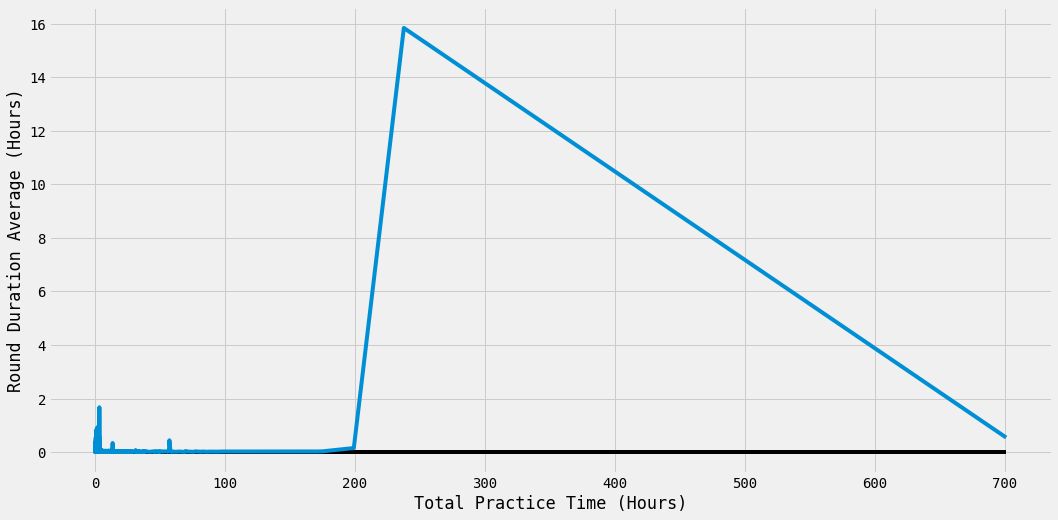

In [214]:
round_by_total_practice = sat_users.sort_values('total_practice')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'h'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'h')).mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Hours)');

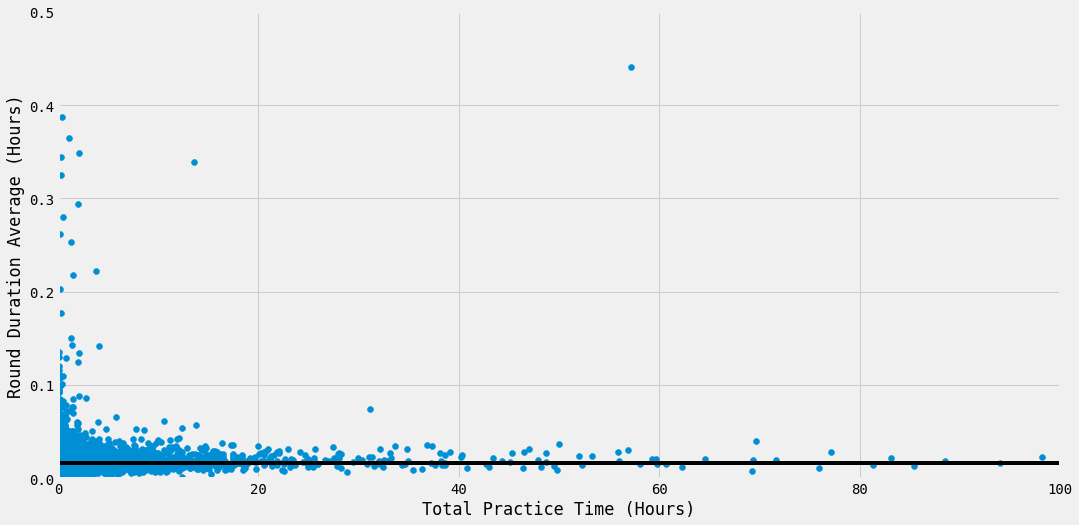

In [215]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(round_by_total_practice.total_practice/np.timedelta64(1, 'h'), round_by_total_practice.round_duration_avg/np.timedelta64(1, 'h'))
plt.hlines(xmin=0, xmax=(round_by_total_practice.total_practice/np.timedelta64(1, 'h')).max(), y=(round_by_total_practice.round_duration_avg/np.timedelta64(1, 'h')).mean())
plt.xlabel('Total Practice Time (Hours)')
plt.ylabel('Round Duration Average (Hours)')
plt.ylim(0, 0.5), plt.xlim(0, 100);

## Question Data (SAT)

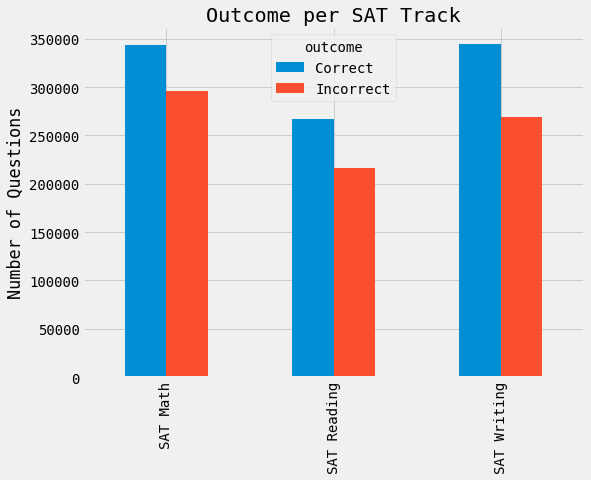

In [216]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=sat.track_name, columns=[sat.outcome]).plot(kind='bar', figsize=(8, 6))

# Create bar labels:
tracks = ('SAT Math', 'SAT Reading', 'SAT Writing')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Track');

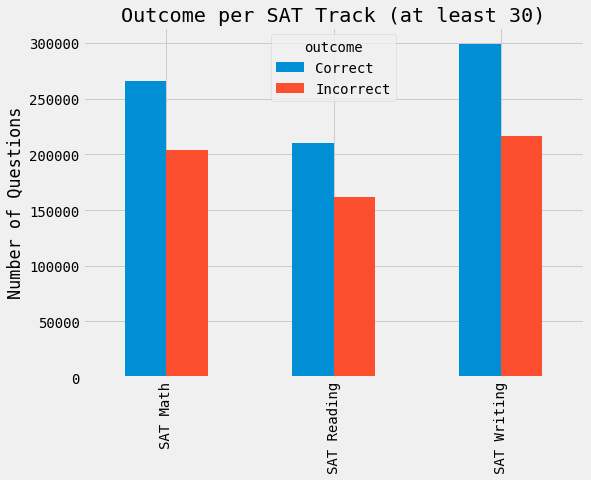

In [217]:
# Create bar plot for track_name distribution by 'outcome':
pd.crosstab(index=sat_30.track_name, columns=[sat_30.outcome]).plot(kind='bar', figsize=(8, 6))

# Create bar labels:
tracks = ('SAT Math', 'SAT Reading', 'SAT Writing')
plt.xticks(np.arange(len(tracks)), tracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Track (at least 30)');

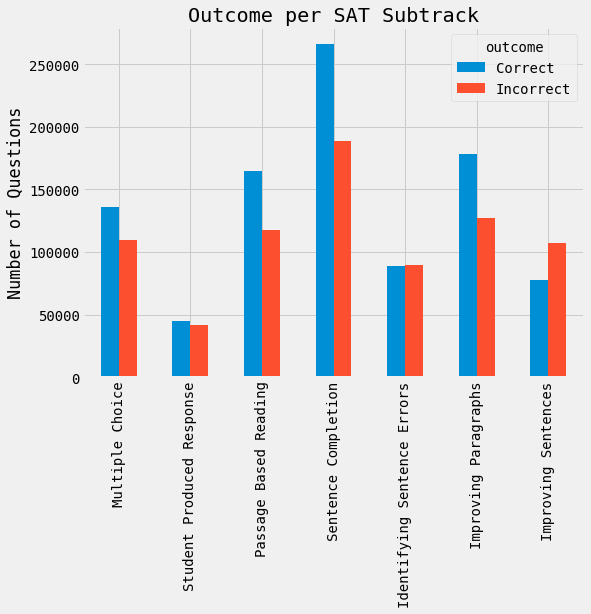

In [218]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=sat.subtrack_name, columns=[sat.outcome]).plot(kind='bar', figsize=(8, 6))

# Create bar labels:
subtracks = ('Multiple Choice', 'Student Produced Response', 'Passage Based Reading', 'Sentence Completion', 'Identifying Sentence Errors', 'Improving Paragraphs', 'Improving Sentences')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Subtrack');

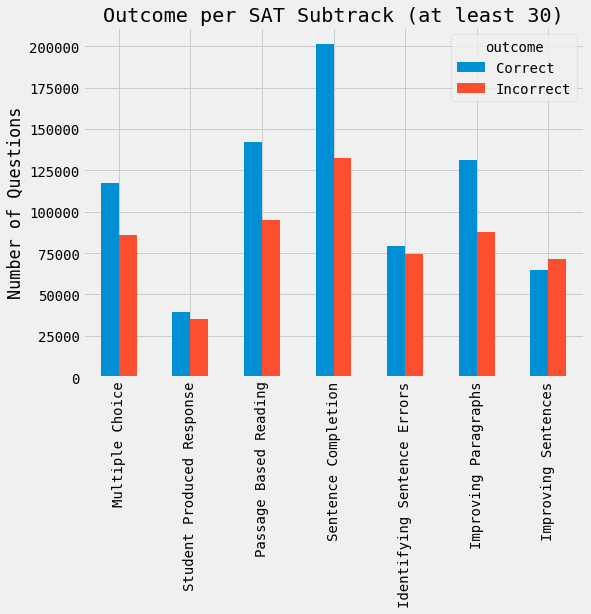

In [219]:
# Create bar plot for subtrack_name distribution by 'outcome':
pd.crosstab(index=sat_30.subtrack_name, columns=[sat_30.outcome]).plot(kind='bar', figsize=(8, 6))

# Create bar labels:
subtracks = ('Multiple Choice', 'Student Produced Response', 'Passage Based Reading', 'Sentence Completion', 'Identifying Sentence Errors', 'Improving Paragraphs', 'Improving Sentences')
plt.xticks(np.arange(len(subtracks)), subtracks)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions')
plt.title('Outcome per SAT Subtrack (at least 30)');

In [220]:
# Save the clean dataframe to the interim data directory:
sat.to_csv('../data/interim/clean_sat.csv')

<a href='#top' id='hypothesis'>back to menu</a>

---
## HYPOTHESIS TESTING
EDA suggests the test groups are independent, so that is tested here. 

### Null Hypothesis: All test groups are from the same distribution.

>[scipy.stats.f_oneway](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html):

>The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

>**Parameters**:	
    sample1, sample2, … : array_like
* The sample measurements for each group.

>**Returns**:	
    statistic : float
* The computed F-value of the test.


>    pvalue : float
* The associated p-value from the F-distribution.


If the F-value is larger than the F-critical, reject the null hypothesis. The p-value is determined by the F-critical and is the probability results could have happened by chance. If the p-value is less than alpha, reject the null hypothesis.

In [221]:
from scipy.stats import f_oneway

N = len(act) + len(gmat) + len(sat)
k = 3
alpha = 0.05
dfn = k-1
dfd = N-k

# Compare samples:
statistic, pvalue = f_oneway(act.correct, gmat.correct, sat.correct)
critical = stats.f.ppf(1-alpha, dfn, dfd)
print('F-value: {:0.4f}, F-critical: {:0.4f},  p-value: {:0.4f}'.format(statistic, critical, pvalue))

# Print interpretation:
alpha = 0.05
if pvalue > alpha:
    print('Fail to Reject the Null Hypothesis: The samples are from the same distribution.')
else:
    print('Reject the Null Hypothesis: At least one sample is from a different distribution.')

F-value: 4070.7936, F-critical: 2.9957,  p-value: 0.0000
Reject the Null Hypothesis: At least one sample is from a different distribution.


### Null Hypothesis: The GMAT and SAT groups are from the same distribution.

[scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html):
>Calculate the T-test for the means of two independent samples of scores.

>This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [222]:
from scipy.stats import ttest_ind

# Compare samples:
statistic, pvalue = ttest_ind(gmat.correct, sat.correct)
print('t-statistic: {:0.4f},  p-value: {:0.4f}'.format(statistic, pvalue))

# Print interpretation:
alpha = 0.05
if pvalue > alpha:
    print('Fail to Reject the Null Hypothesis: The samples are from the same distribution.')
else:
    print('Reject the Null Hypothesis: The samples are from different distributions.')

t-statistic: 21.6176,  p-value: 0.0000
Reject the Null Hypothesis: The samples are from different distributions.


In [223]:
# Do not assume equal variances -

# Compare samples:
statistic, pvalue = ttest_ind(gmat.correct, sat.correct, equal_var=False)
print('t-statistic: {:0.4f},  p-value: {:0.4f}'.format(statistic, pvalue))

# Print interpretation:
alpha = 0.05
if pvalue > alpha:
    print('Fail to Reject the Null Hypothesis: The samples are from the same distribution.')
else:
    print('Reject the Null Hypothesis: The samples are from different distributions.')

t-statistic: 21.6096,  p-value: 0.0000
Reject the Null Hypothesis: The samples are from different distributions.


### Null Hypothesis: GMAT users and dedicated GMAT users are from the same distribution.

[scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html):
>Calculate the T-test on TWO RELATED samples of scores, a and b.

>This is a two-sided test for the null hypothesis that 2 related or repeated samples have identical average (expected) values.

In [224]:
gmat_sample = gmat.sample(1000000, weights=gmat.user_id, axis=0, random_state=0)
gmat_30_sample = gmat_30.sample(1000000, weights=gmat_30.user_id, axis=0, random_state=0)

In [225]:
from scipy.stats import ttest_rel

# Compare samples:
statistic, pvalue = ttest_rel(gmat_sample.correct, gmat_30_sample.correct)
print('t-statistic: {:0.4f},  p-value: {:0.4f}'.format(statistic, pvalue))

# Print interpretation:
alpha = 0.05
if pvalue > alpha:
    print('Fail to Reject the Null Hypothesis: The samples are from the same distribution.')
else:
    print('Reject the Null Hypothesis: The samples are from different distributions.')

t-statistic: -40.1945,  p-value: 0.0000
Reject the Null Hypothesis: The samples are from different distributions.


<a href='#top' id='summary'>back to menu</a>

---
## SAVE & SUMMARIZE
EDA and Hypothesis Testing indicate groups are independent within the full dataset, so further analysis will be on an individual group. In case the full dataset is useful, it is saved below.

In [226]:
df2, users = user_stats(df2)
df2.head()

user_id    round_started_at         answered_at      deactivated_at  \
0    85818 2010-08-18 20:17:13 2010-08-18 20:18:18 2010-08-18 20:18:18   
1    85818 2010-08-18 20:19:12 2010-08-18 20:20:34 2010-08-18 20:20:34   
2    85818 2010-08-18 20:20:42 2010-08-18 20:21:56 2010-08-18 20:21:56   
3    85818 2010-08-18 20:22:03 2010-08-18 20:23:05 2010-08-18 20:23:05   
4    85818 2010-08-18 20:23:11 2010-08-18 20:26:08 2010-08-18 20:26:08   

       round_ended_at  correct  question_id group_name  track_name  \
0 2010-08-18 20:18:18        0         5560       GMAT           5   
1 2010-08-18 20:20:34        1         4681       GMAT           5   
2 2010-08-18 20:21:56        1         1529       GMAT           5   
3 2010-08-18 20:23:05        1         2908       GMAT           5   
4 2010-08-18 20:26:08        1         1773       GMAT           5   

   subtrack_name       tag_string  question_type  game_type  num_players  \
0             14  222 233 240 246              0          7            1   
1              0            24 49              0          7            1   
2              0            31 49              0          7            1   
3              0            31 49              0          7            1   
4             11      183 194 207              0          7            1   

  round_duration  fast  slow  prior_attempts  excessive_attempts    outcome  \
0       00:01:05     0     0               0                   0  Incorrect   
1       00:01:22     0     0               0                   0    Correct   
2       00:01:14     0     0               0                   0    Correct   
3       00:01:02     0     0               0                   0    Correct   
4       00:02:57     0     0               0                   0    Correct   

   num_correct  num_incorrect  num_questions  few  many  correct_ratio  \
0          169            146            315    0     0       0.536508   
1          169            146            315    0     0       0.536508   
2          169            146            315    0     0       0.536508   
3          169            146            315    0     0       0.536508   
4          169            146            315    0     0       0.536508   

  total_practice round_duration_avg  slow_avg  fast_avg  
0       07:42:42    00:01:28.133333         0         0  
1       07:42:42    00:01:28.133333         0         0  
2       07:42:42    00:01:28.133333         0         0  
3       07:42:42    00:01:28.133333         0         0  
4       07:42:42    00:01:28.133333         0         0

In [227]:
# Save the clean dataframe to the interim data directory:
df2.to_csv('../data/interim/clean_df.csv')

### EDA & Inferential Statistics
The [report for this notebook](https://github.com/humburgc/academic_mastery_study/blob/master/reports/exploratory_data_analysis.pdf) summarizes important findings and actions for all of these steps:
1. Dataset Statistics
2. User and Question Data EDA
3. EDA of Other Categorical Variables
4. Investigate Overlap of Test Groups
5. ACT EDA
6. GMAT EDA
7. SAT EDA
8. Hypothesis Testing

While a small amount of users practice in more than one test group, no overlap in questions indicates the test groups are independent. This is confirmed by statistical analysis of the null hypothesis that the group samples are from the same distribution. Hypothesis testing also confirmed that there is a significant performance difference between all users and dedicated users (attempting at least 30 questions). For each test group, outcomes are better across all subjects for dedicated users. This effect is most dramatic for the GMAT group. Of all scenarios, average scores are best amongst the dedicated GMAT users. This group will be used to model data and make predictions in the next notebook.

---
## [Machine Learning Analysis](http://nbviewer.jupyter.org/github/humburgc/academic_mastery_study/blob/master/notebooks/machine_learning_analysis.ipynb?flush_cache=true)

<br>